# ATLAS analysis 
[ATL-PHYS-PUB-2019-029](http://cds.cern.ch/record/2684863)
[arXiv:1908.03122](https://arxiv.org/abs/1908.03122)
[HistFactory likelihood (HEPData)](https://www.hepdata.net/record/ins1748602)

## Initialize

Things to fix:
    - check that overwritten file names are updated in self
    - add inherited class to all classes documentation
    - When computing KS in predictions set equal size samples
    - optimization with tensorflow
    - plots for results
    - HPDI with same point on the edges
    - stacking (already done something but put in new class)
optional
    - TensorBoard still not working (showing board but not saving data for tb 2.0.0, while saving data but not showing board for tb 2.1.0 and 2.1.1)
      Remember:
          - taskkill /im tensorboard.exe /f
          - del /q %TMP%\.tensorboard-info\*
    - check for better (more efficient) serialization for datasets (such as Google Protobuf)
    - turn JSON into NDJSON

In [1]:
import sys
sys.dont_write_bytecode = True
sys.path.append('../DNNLikelihood_dev/source')
import DNNLikelihood
#from DNNLikelihood import set_resources
#active_gpus = set_resources.set_gpus(None)
#from DNNLikelihood import utils
#from DNNLikelihood import inference
from timeit import default_timer as timer
from jupyterthemes import jtplot
jtplot.reset()

#from os import listdir
#from os.path import isfile, join
#import json, jsonpatch, requests, jsonschema
#from jsonpatch import JsonPatch
#import h5py
#import os
#import sys
#import ipywidgets as widgets
#from multiprocess import Pool
#import psutil
#from scipy import stats
#from scipy import optimize
## insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(0,'pyhf/src')
#import pyhf
#import numpy as np
#import emcee
#from timeit import default_timer as timer
#import matplotlib.pyplot as plt
#%matplotlib inline
#from jupyterthemes import jtplot
#
#from multiprocessing import Pool

In [69]:
#from tensorboard import notebook

In [189]:
#import toy_likelihood
#from toy_likelihood import *

## Sampling one likelihood

### Import and save HistFactory likelihood(s)

In [2]:
histfact = DNNLikelihood.Histfactory(workspace_folder="HEPData_workspaces",
                                     name = "ATLAS_sbottom_search",
                                     regions_folders_base_name = "Region",
                                     bkg_files_base_name = "BkgOnly",
                                     patch_files_base_name ="patch",
                                     output_folder = "outfiles",
                                     histfactory_input_file = None,
                                     verbose = True)

Successfully imported 649 likelihoods from 3 regions.
Histfactory pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.pickle saved in 0.002203500000000247 s.
Histfactory json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.json saved in 0.0010567000000012428 s.
Histfactory log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log saved in 0.002870800000000173 s.


In [3]:
histfact.import_histfactory(lik_numbers_list=[90,91,92,93],verbose=2)#slik_number_list=range(85,95))#lik_number_list=[1,2,92])
#histfact.import_likelihoods(lik_number_list=[92])

FloatProgress(value=0.0, layout=Layout(height='14px', margin='-5px 0px -20px 0px', padding='0px', width='500px…

C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\HEPData_workspaces\RegionA\patch.sbottom_1400_350_60.json processed in 0.9520344999999999 s.
C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\HEPData_workspaces\RegionA\patch.sbottom_1400_430_300.json processed in 0.6571737999999989 s.
C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\HEPData_workspaces\RegionA\patch.sbottom_1400_450_60.json processed in 0.6102650999999994 s.
C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\HEPData_workspaces\RegionA\patch.sbottom_1400_530_400.json processed in 0.6301405999999972 s.
Histfactory log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log saved in 0.0026501000000003216 s.
Imported 4 likelihoods in  2.8612044999999995 s.


In [5]:
for n in histfact.likelihoods_dict.keys():
    if histfact.likelihoods_dict[n]["model_loaded"]:
        print(n, histfact.likelihoods_dict[n]["model"].logpdf(histfact.likelihoods_dict[n]["pars_init"],histfact.likelihoods_dict[n]["obs_data"])[0])

0 -53.61809910541577


In [4]:
histfact.save_histfactory()#out_file="histfactory_ATLAS_sbottom_search.pickle")#,lik_number_list=[0,100])
#histfact.load_likelihoods(in_file="ATLAS_sbottom_search_histfactory_likelihoods.pickle")

Histfactory pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.pickle saved in 0.02478100000000083 s.
Histfactory json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.json saved in 0.0009027000000010332 s.
Histfactory log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log saved in 0.0043034000000012895 s.


### Generate Lik object, compute MCMC parameters initializations and save 

In [6]:
histfact2 = DNNLikelihood.Histfactory(workspace_folder=None,
                                     name = None,
                                     regions_folders_base_name = None,
                                     bkg_files_base_name = None,
                                     patch_files_base_name =None,
                                     output_folder = "outfiles",
                                     histfactory_input_file = "outfiles/ATLAS_sbottom_search_histfactory")

Likelihoods loaded in 0.12789370000000133 seconds.
File size is  2674546 .
Histfactory log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log saved in 0.0035026999999985264 s.


In [7]:
histfact2.save_histfactory(overwrite=False,lik_numbers_list=[91,92])

The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.pickle already exists.
Histfactory pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.pickle saved in 0.023997899999997685 s.
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.json already exists.
Histfactory json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.json saved in 0.002269500000004143 s.
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log already exists.
Histfactory log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log saved in 0.005152000000002488 s.


In [8]:
for n in histfact2.likelihoods_dict.keys():
    if histfact2.likelihoods_dict[n]["model_loaded"]:
        print(n, histfact2.likelihoods_dict[n]["model"].logpdf(histfact2.likelihoods_dict[n]["pars_init"],histfact2.likelihoods_dict[n]["obs_data"])[0])

90 -53.37697568376776
91 -53.7626689248206
92 -54.15281350372808
93 -53.70071017989064


In [10]:
lik = histfact2.get_likelihood_object(lik_number=92)

Likelihood pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.pickle saved in 0.14955039999999542 s.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.json saved in 0.0031556999999935442 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.00098519999998814 s.
Likelihood object for likelihood 92 created and saved to files C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.json and C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likeli

In [14]:
histfact.log

{'2020-04-09-17-39-58': {'action': 'saved',
  'file name': 'ATLAS_sbottom_search_histfactory.json',
  'file path': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_histfactory.json'},
 '2020-04-09-17-40-03': {'action': 'imported likelihoods',
  'likelihoods numbers': [90, 91, 92, 93]},
 '2020-04-09-17-40-04': {'action': 'saved',
  'likelihoods numbers': None,
  'file path': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_histfactory.pickle'},
 '2020-04-09-17-40-05': {'action': 'saved',
  'file name': 'ATLAS_sbottom_search_histfactory.json',
  'file path': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_histfactory.json'},
 '2020-04-09-17-40-09': {'action': 'loaded',
  'file name': 'ATLAS_sbottom_search_histfactory.json',
  'file path': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitH

In [15]:
histfact.save_histfactory(overwrite=True)

Histfactory pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.pickle saved in 0.020719599999999616 s.
Histfactory log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log saved in 0.0010796999999982404 s.
Histfactory json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.json saved in 0.0009182000000009793 s.
Histfactory log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_histfactory.log saved in 0.0008666999999960012 s.


In [14]:
lik.figure_files_base_path

'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_figure'

In [13]:
pippo = list(lik.__dict__.keys())
pippo.sort()
pippo

['X_logpdf_max',
 'X_prof_logpdf_max',
 'X_prof_logpdf_max_tmp',
 'Y_logpdf_max',
 'Y_prof_logpdf_max',
 'Y_prof_logpdf_max_tmp',
 'figure_files_base_path',
 'figures_list',
 'generic_pars_labels',
 'likelihood_input_file',
 'likelihood_input_json_file',
 'likelihood_input_log_file',
 'likelihood_input_pickle_file',
 'likelihood_output_json_file',
 'likelihood_output_log_file',
 'likelihood_output_pickle_file',
 'likelihood_script_file',
 'log',
 'logpdf',
 'logpdf_args',
 'name',
 'output_files_base_path',
 'output_folder',
 'pars_bounds',
 'pars_init',
 'pars_labels',
 'pars_pos_nuis',
 'pars_pos_poi',
 'verbose']

In [17]:
lik.likelihood_script_file

'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py'

In [18]:
lik.save_likelihood(overwrite=True)

Likelihood pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.pickle saved in 0.16055089999999694 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.0008739000000019814 s.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.json saved in 0.0021745000000024106 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.0007978000000008478 s.


In [19]:
lik.save_likelihood_script()

File C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py correctly generated.


In [20]:
lik.logpdf(lik.pars_init,*lik.logpdf_args)

-54.15281350372808

In [7]:
lik.pars_bounds[0,0]

0.915

Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_figure_par_0.pdf.


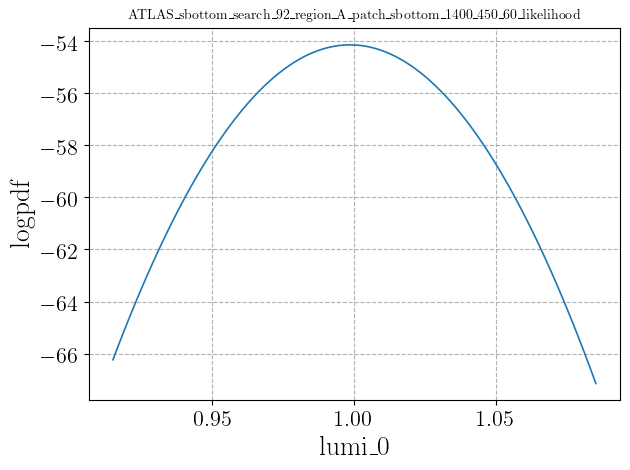

Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.00198109999999474 s.
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_figure_par_5.pdf.


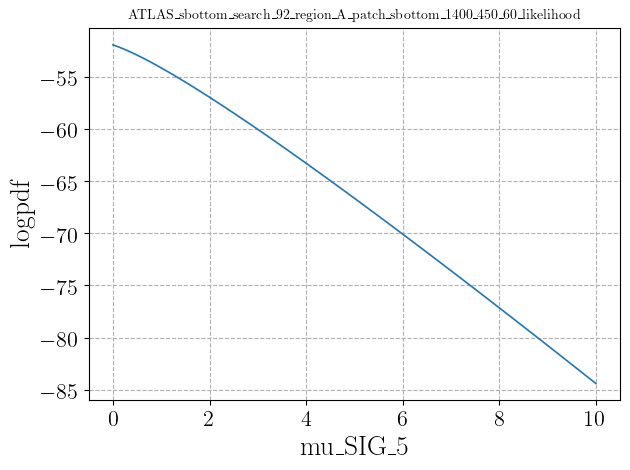

Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.0018953000000010434 s.


In [8]:
lik.plot_logpdf_par([[0,lik.pars_bounds[0,0],lik.pars_bounds[0,1]],[5,lik.pars_bounds[5,0],lik.pars_bounds[5,1]]],overwrite=True)

In [22]:
lik.compute_maximum_logpdf()

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Maximum likelihood computed in 1.6806027000000014 s.


In [23]:
lik.compute_profiled_maxima(pars=[5],pars_ranges=[[0,3,20]],spacing="grid",verbose=2)

FloatProgress(value=0.0, layout=Layout(height='14px', margin='-5px 0px -20px 0px', padding='0px', width='500px…

Total number of points: 20
Log-pdf values lie in the range [ 50.42330266364782 , 57.35259502322179 ]
20 local maxima computed in 34.788976299999995 s.


In [24]:
lik.save_likelihood(overwrite=True)

Likelihood pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.pickle saved in 0.1442400000000248 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.0009179999999844313 s.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.json saved in 0.006815700000004199 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.0009263999999973294 s.


### Import one Likelihood, generation of "define_logpdf.py", and build and run Sampler

In [2]:
lik = DNNLikelihood.Likelihood(name = None,
                               logpdf = None,
                               logpdf_args = None,
                               pars_pos_poi = None,
                               pars_pos_nuis = None,
                               pars_init = None,
                               pars_labels = None,
                               pars_bounds = None,
                               output_folder = None,
                               likelihood_input_file= "outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.pickle")

Likelihood loaded in 0.10940249999999985 .
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.log saved in 0.0015580000000010585 s.


In [32]:
lik.pars_init

array([1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [26]:
lik.save_likelihood_script()

File C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py correctly generated.


In [33]:
list(lik.__dict__.keys())

['verbose',
 'likelihood_input_file',
 'likelihood_input_json_file',
 'likelihood_input_log_file',
 'likelihood_input_pickle_file',
 'name',
 'logpdf_args',
 'pars_pos_poi',
 'pars_pos_nuis',
 'pars_init',
 'pars_labels',
 'generic_pars_labels',
 'pars_bounds',
 'output_folder',
 'output_files_base_path',
 'likelihood_output_json_file',
 'likelihood_output_log_file',
 'likelihood_output_pickle_file',
 'likelihood_script_file',
 'figure_files_base_path',
 'Y_logpdf_max',
 'X_prof_logpdf_max',
 'Y_prof_logpdf_max',
 'X_prof_logpdf_max_tmp',
 'figures_list',
 'log',
 'logpdf',
 'X_logpdf_max',
 'Y_prof_logpdf_max_tmp']

In [34]:
Sampler1 = DNNLikelihood.Sampler(new_sampler=True,
                              likelihood_script_file="outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py",#None,#
                              likelihood=None,#lik,#
                              nsteps=10000,
                              moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                              parallel_CPU=True,
                              vectorize=False)

Likelihood loaded in 0.022373800000025312 .


In [47]:
list(Sampler1.__dict__.keys())

['verbose',
 'new_sampler',
 'likelihood_script_file',
 'name',
 'logpdf',
 'logpdf_args',
 'pars_pos_poi',
 'pars_pos_nuis',
 'pars_init_vec',
 'pars_labels',
 'generic_pars_labels',
 'output_folder',
 'nwalkers',
 'ndims',
 'nsteps',
 'output_files_base_path',
 'backend_file',
 'data_file',
 'figure_files_base_path',
 'moves_str',
 'moves',
 'parallel_CPU',
 'vectorize',
 'backend',
 'sampler']

In [43]:
DNNLikelihood.utils.dic_minus_keys(Sampler1.__dict__,["logpdf","logpdf_args","pars_pos_poi",
                                                      "pars_pos_nuis","pars_init_vec","pars_labels","generic_pars_labels",
                                                      "nwalkers","ndim","backend","sampler","moves","new_sampler"])

{'verbose': True,
 'likelihood_script_file': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py',
 'name': 'ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler',
 'output_folder': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles',
 'ndims': 64,
 'nsteps': 10000,
 'output_files_base_path': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler',
 'backend_file': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5',
 'data_file': 'C:\\Users\\Admin\\Dropbox\\Work\\09_Resources\\Git\\GitHub\\DNNLikelihood\\ATLAS\\outfiles\\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_data

In [4]:
Sampler1.run_sampler()

Initialize backend in file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5
Initial number of steps: 0
Running 44 parallel processes.


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:50<00:00, 43.36it/s]


Done in 243.4255566 seconds.
Final number of steps: 10000.


### Make sampler from "likelihood"

In [2]:
lik = DNNLikelihood.Likelihood(name = None,
                               logpdf = None,
                               logpdf_args = None,
                               pars_pos_poi = None,
                               pars_pos_nuis = None,
                               pars_init = None,
                               pars_labels = None,
                               pars_bounds = None,
                               output_folder = None,
                               likelihood_input_file= "outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood.pickle",
                               verbose=True)

Likelihood loaded in 0.013548899999999975 .


In [3]:
Sampler1 = DNNLikelihood.Sampler(new_sampler=True,
                                 likelihood_script_file=None,#"outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py",#None,#
                                 likelihood=lik,#None,#
                                 nsteps=1000,
                                 moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                                 parallel_CPU=True,
                                 vectorize=False,
                                 sampler_input_file=None,
                                 verbose=1)

File C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py correctly generated.
Likelihood loaded in 0.09416380000000046 .
Created backend C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 for chains ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler in 9.2513877 s.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json saved in 0.0007033999999990215 s.
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.log already exists.
Sampler log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_sear

In [4]:
Sampler1.run_sampler()

Initialize backend in file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5
Initial number of steps: 0
Running 44 parallel processes.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.10it/s]


Sampler log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.log saved in 0.0010380000000012046 s.
Done in 31.5828336 seconds.
Final number of steps: 1000.


In [5]:
Sampler2 = DNNLikelihood.Sampler(new_sampler=False,
                                 likelihood_script_file=None,#"outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py",#None,#
                                 likelihood=lik,#None,#
                                 nsteps=2000,
                                 moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                                 parallel_CPU=True,
                                 vectorize=False,
                                 sampler_input_file=None,
                                 verbose=1)

File C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py correctly generated.
Loaded sampler log in 0.0054960000000008336 .
Loaded backend C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 for chains ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler in 1.2482525000000066 s.
Available number of steps: 1000.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json saved in 0.0007440000000045188 s.
Sampler log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.log saved in 0.0009456999999954974 s.


In [6]:
Sampler2.run_sampler()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Initial number of steps: 1000
Running 44 parallel processes.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.49it/s]


Sampler log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.log saved in 0.0009882000000089874 s.
Done in 31.252257799999995 seconds.
Final number of steps: 2000.


### Make sampler from "likelihood_script_file"

In [2]:
Sampler1 = DNNLikelihood.Sampler(new_sampler=True,
                                 likelihood_script_file="outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script",#None,#
                                 likelihood=None,#lik,#
                                 nsteps=1000,
                                 moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                                 parallel_CPU=True,
                                 vectorize=False,
                                 sampler_input_file=None,
                                 verbose=1)

Likelihood loaded in 0.012953800000000015 .
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 already exists.
Created backend C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 for chains ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler in 8.2458008 s.
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json already exists.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json saved in 0.00255470000000102 s.
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_regio

In [3]:
Sampler1.run_sampler()

Initialize backend in file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5
Initial number of steps: 0
Running 44 parallel processes.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.83it/s]


Done in 31.780423000000006 seconds.
Final number of steps: 1000.


In [6]:
Sampler2 = DNNLikelihood.Sampler(new_sampler=False,
                                 likelihood_script_file="outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script",#None,#
                                 likelihood=None,#lik,#
                                 nsteps=2000,
                                 moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                                 parallel_CPU=True,
                                 vectorize=False,
                                 sampler_input_file=None,
                                 verbose=1)

Sampler log loaded in 0.005393900000001395 .
Sampler loaded in 0.0002063999999961652 .
Loaded backend C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 for chains ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler in 0.25193280000002005 s.
Available number of steps: 1000.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json saved in 0.0008455999999910091 s.
Sampler log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.log saved in 0.000809299999986024 s.


In [7]:
Sampler2.run_sampler()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Initial number of steps: 1000
Running 44 parallel processes.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.46it/s]


Done in 31.295928000000004 seconds.
Final number of steps: 2000.


### Make sampler from "sampler_input_file"

In [2]:
Sampler1 = DNNLikelihood.Sampler(new_sampler=True,
                                 likelihood_script_file=None,#"outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script",#
                                 likelihood=None,#lik,#
                                 nsteps=1000,
                                 moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                                 parallel_CPU=True,
                                 vectorize=False,
                                 sampler_input_file="outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler",
                                 verbose=1)

Likelihood loaded in 0.014445500000000777 .
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 already exists.
Created backend C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 for chains ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler in 8.259389400000002 s.
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json already exists.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json saved in 0.002746500000000651 s.
The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search

In [3]:
Sampler1.run_sampler()

Initialize backend in file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5
Initial number of steps: 0
Running 44 parallel processes.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.25it/s]


Done in 31.55132300000001 seconds.
Final number of steps: 1000.


In [4]:
Sampler2 = DNNLikelihood.Sampler(new_sampler=False,
                                 likelihood_script_file=None,#"outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script",
                                 likelihood=None,#lik,#
                                 nsteps=2000,
                                 moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                                 parallel_CPU=True,
                                 vectorize=False,
                                 sampler_input_file="outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler",
                                 verbose=1)

Loaded sampler log in 0.005521200000004001 .
Loaded sampler in 0.00035770000002344204 .
Loaded backend C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5 for chains ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler in 0.2515388999999857 s.
Available number of steps: 1000.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.json saved in 0.0008406999999976961 s.
Sampler log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler.log saved in 0.0007516999999950258 s.


In [5]:
Sampler2.run_sampler()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Initial number of steps: 1000
Running 44 parallel processes.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.42it/s]


Done in 31.419219499999997 seconds.
Final number of steps: 2000.


### Import sampler and study samples

In [2]:
Sampler1 = DNNLikelihood.Sampler(new_sampler=False,
                                 likelihood_script_file="outfiles/ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_likelihood_script.py",#None,#
                                 likelihood=None,#lik,#
                                 nsteps=10000,
                                 moves_str="[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0002, mode='random',factor=None),1)]",
                                 parallel_CPU=True,
                                 vectorize=False)

Likelihood loaded in 0.09489190000000036 .
Loading existing sampler from backend file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5
Notice: when loading sampler from backend, all parameters of the sampler but the 'logpdf', its args 'logpdf_args', and 'moves' are set by the backend. All other parameters are set consistently with the ``sampler class attributes.
Pay attention that they are consistent with the parameters used to produce the sampler saved in backend.
Initialize backend in file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_backend.h5
Initial number of steps: 50000
Please increase nsteps to run for more steps
Done in 0.23853850000000065 seconds.
Final number of steps: 50000.
Sampler for chains ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler from 

In [9]:
Sampler1.run_sampler()

  0%|                                                                                        | 0/40000 [00:00<?, ?it/s]

Initial number of steps: 10000
Running 44 parallel processes.


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [15:25<00:00, 43.20it/s]


Done in 926.5295831000001 seconds.
Final number of steps: 50000.


In [10]:
start = timer()
res = Sampler1.gelman_rubin(pars=[0,5],nsteps=[500,1000,5000,10000,50000])
end = timer()
print(res)
print(end-start)

[[0.00000000e+00 5.00000000e+02 1.46666904e+00 1.79586118e-04
  8.39014314e-05]
 [0.00000000e+00 1.00000000e+03 1.32761212e+00 2.14155669e-04
  1.21925081e-04]
 [0.00000000e+00 5.00000000e+03 1.08810709e+00 2.66980990e-04
  2.25727206e-04]
 [0.00000000e+00 1.00000000e+04 1.04278230e+00 2.84175652e-04
  2.61497512e-04]
 [0.00000000e+00 5.00000000e+04 1.00934801e+00 2.87788904e-04
  2.82513159e-04]
 [5.00000000e+00 5.00000000e+02 5.53999891e+01 7.63123509e-01
  2.51127420e-04]
 [5.00000000e+00 1.00000000e+03 3.95913138e+01 7.64302987e-01
  4.92472259e-04]
 [5.00000000e+00 5.00000000e+03 1.81042469e+01 7.74030377e-01
  2.38501534e-03]
 [5.00000000e+00 1.00000000e+04 1.28452530e+01 7.81831514e-01
  4.78514297e-03]
 [5.00000000e+00 5.00000000e+04 5.74408364e+00 7.86262473e-01
  2.40534096e-02]]
83.3341312


The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_Rc_0.pdf already exists.
New file name set to C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_Rc_0_2020-04-06-21-19-36.pdf
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_Rc_0_2020-04-06-21-19-36.pdf.


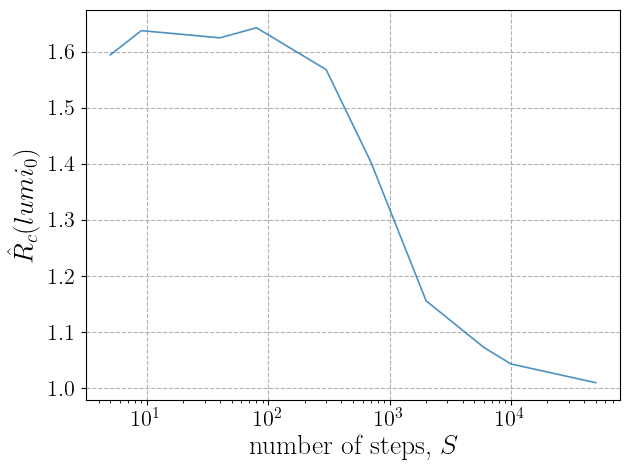

The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtVhat_0.pdf already exists.
New file name set to C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtVhat_0_2020-04-06-21-19-37.pdf
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtVhat_0_2020-04-06-21-19-37.pdf.


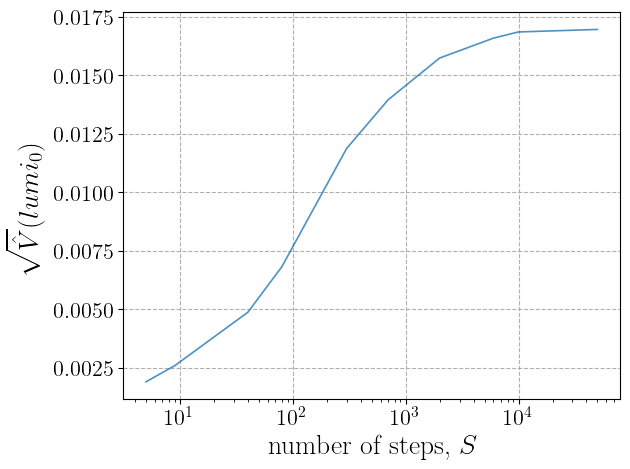

The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtW_0.pdf already exists.
New file name set to C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtW_0_2020-04-06-21-19-37.pdf
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtW_0_2020-04-06-21-19-37.pdf.


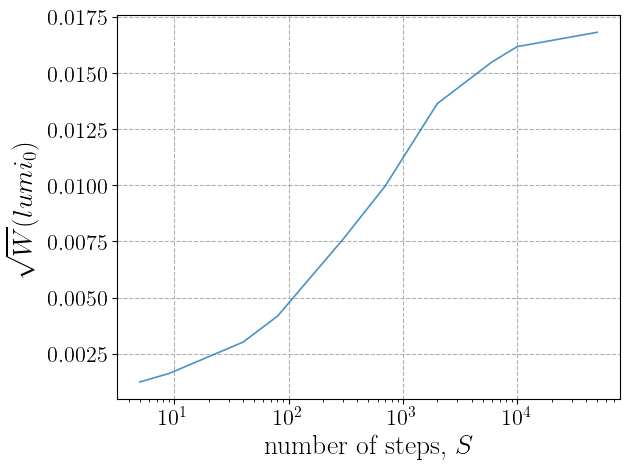

The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_Rc_5.pdf already exists.
New file name set to C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_Rc_5_2020-04-06-21-20-54.pdf
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_Rc_5_2020-04-06-21-20-54.pdf.


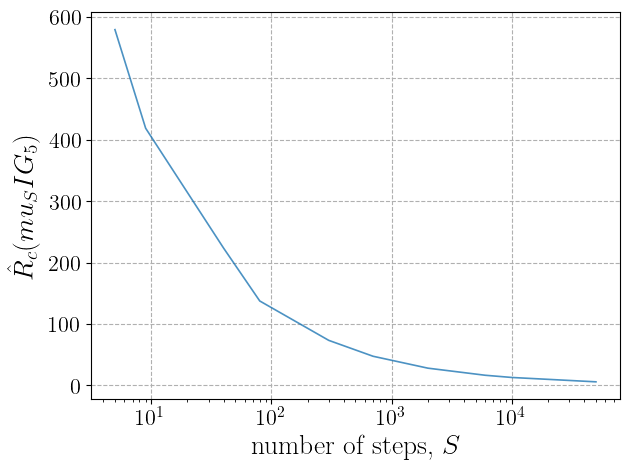

The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtVhat_5.pdf already exists.
New file name set to C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtVhat_5_2020-04-06-21-20-55.pdf
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtVhat_5_2020-04-06-21-20-55.pdf.


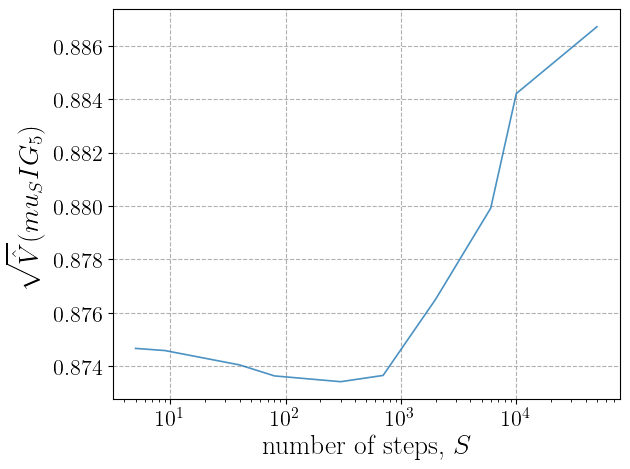

The file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtW_5.pdf already exists.
New file name set to C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtW_5_2020-04-06-21-20-56.pdf
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\ATLAS_sbottom_search_92_region_A_patch_sbottom_1400_450_60_sampler_figure_GR_sqrtW_5_2020-04-06-21-20-56.pdf.


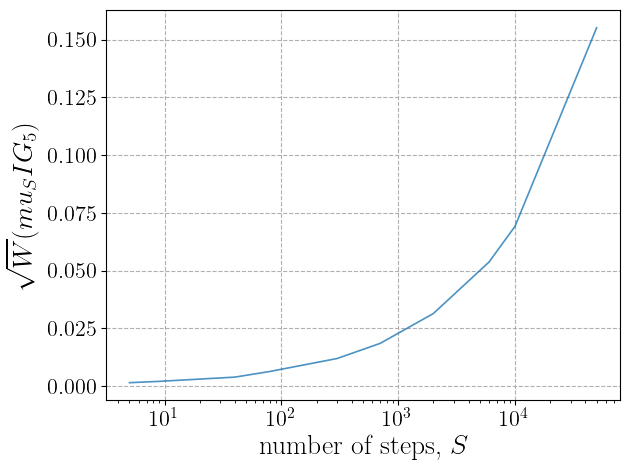

156.90011030000005


In [11]:
start = timer()
Sampler1.plot_gelman_rubin(pars=[0,5], npoints=10)
end = timer()
print(end-start)

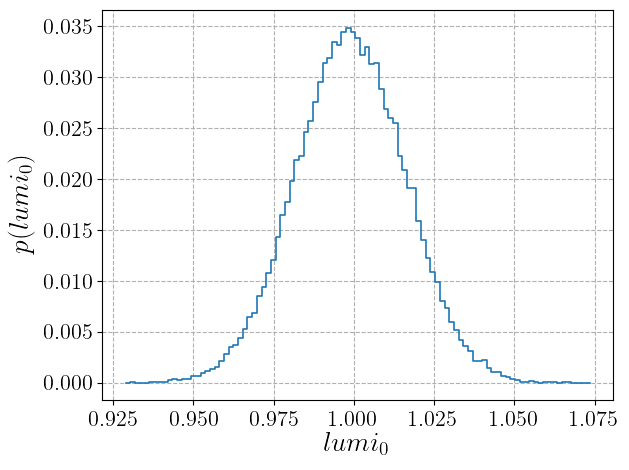

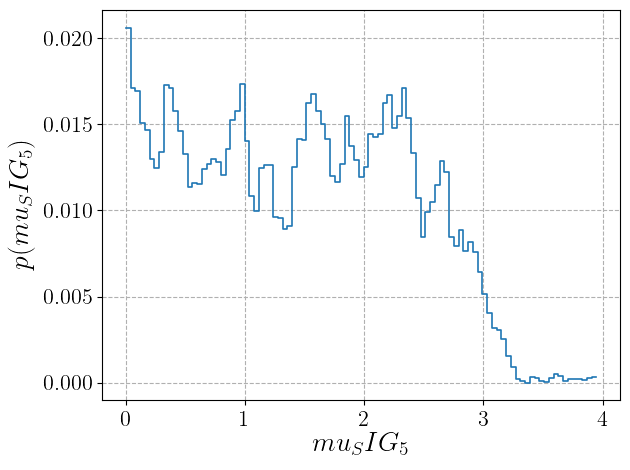

16.2959335999999


In [12]:
start = timer()
Sampler1.plot_dist(pars=[0,5])
end = timer()
print(end-start)

There is at least one chain starting with 451 duplicate steps. Autocorrelation will be computer starting at 461 steps.
Bounds ( -5.0 , 5.0 ) delivered non-finite log-prior. Increasing bound to ( -10.0 , 10.0 ) and retrying.
Bounds ( -10.0 , 10.0 ) delivered non-finite log-prior. Increasing bound to ( -15.0 , 15.0 ) and retrying.
Succeeded with bounds ( -15.0 , 15.0 ).


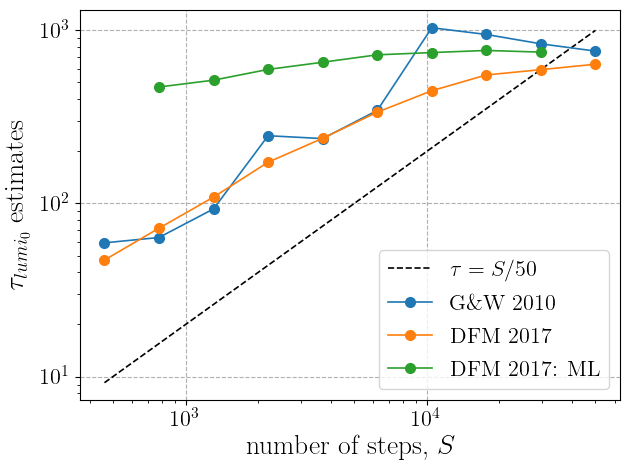

There is at least one chain starting with 327 duplicate steps. Autocorrelation will be computer starting at 337 steps.


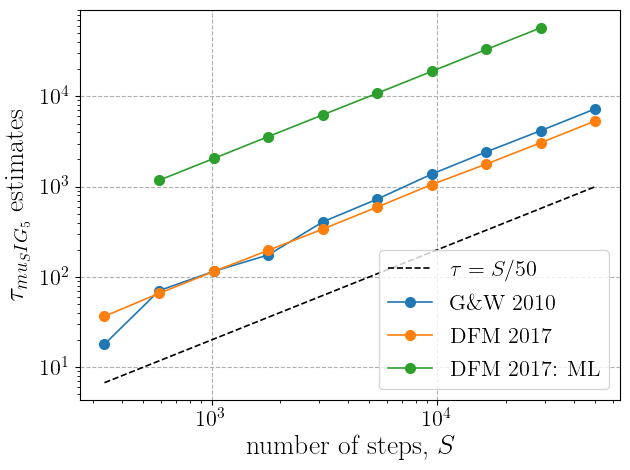

206.84704759999977


In [13]:
start = timer()
Sampler1.plot_autocorr(pars=[0,5],methods=["G&W 2010", "DFM 2017","DFM 2017: ML","DFM 2017: ML"])
end = timer()
print(end-start)

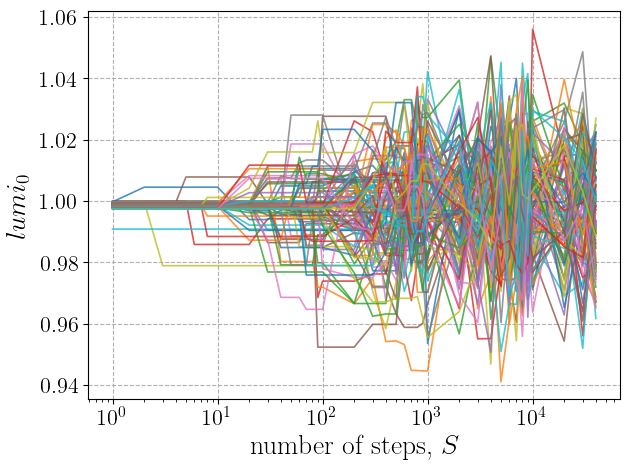

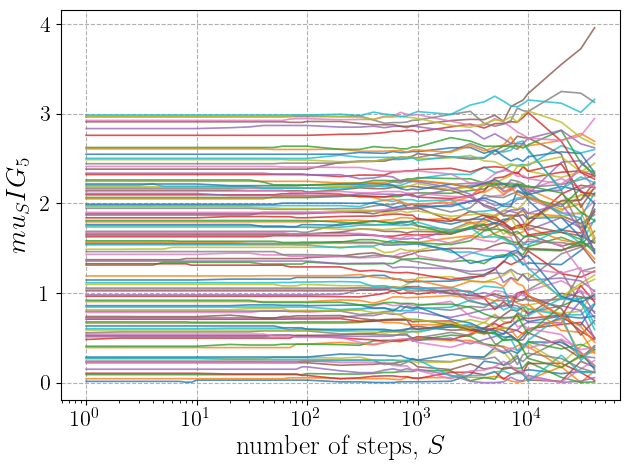

16.034330200000113


In [14]:
start = timer()
Sampler1.plot_chains(pars=[0,5],n_chains=100)
end = timer()
print(end-start)

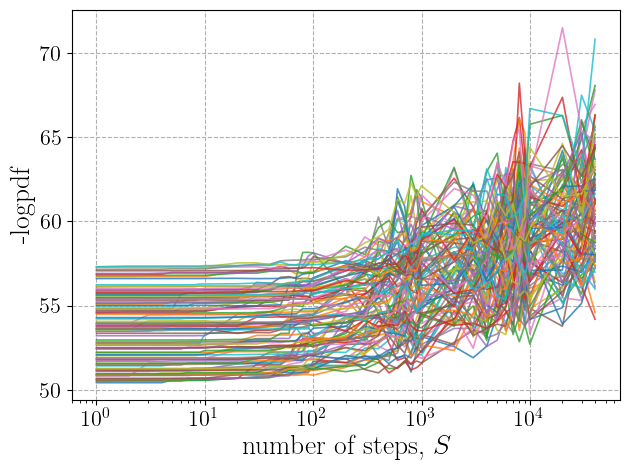

0.8049018000001524


In [15]:
start = timer()
Sampler1.plot_chains_logprob(n_chains=100)
end = timer()
print(end-start)

### Data

In [23]:
Data1 = Sampler1.get_data_object(test_fraction=0.1,dtype='float64',save=True)

Notice: When requiring an unbiased data sample please check that the required burnin is compatible with MCMC convergence.
There are non-unique samples
2000000 unique samples generated in 2.684190400000034 s.
Saved 2000000 (data_X, data_Y) samples in file bigfiles/lik_A_0_data_sample.h5 in 1.0571442000000388 s.


In [27]:
DataSample1.test_fraction

0.1

In [16]:
DataSample1.define_test_fraction(test_fraction=DataSample1.test_fraction)

In [25]:
prova = np.concatenate((np.array([],dtype='int'),np.array([12])))
prova

array([12])

In [28]:
print(DataSample1.name,DataSample1.npoints,DataSample1.ndim,len(DataSample1.data_X),len(DataSample1.data_Y))

lik_A_0_2020-02-18-15-03-01 2000000 64 2000000 2000000


In [32]:
np.array(range(200)).dtype

dtype('int32')

In [2]:
DataSample2 = source.Data_sample(data_X = None,
                                 data_Y = None,
                                 dtype="float64",
                                 pars_pos_poi=None,
                                 pars_pos_nuis=None,
                                 pars_labels=None,
                                 test_fraction = 1,
                                 name = None,
                                 data_sample_input_filename="bigfiles/lik_A_0_data_sample.h5",
                                 data_sample_output_filename=None,
                                 load_on_RAM = False)

Opened h5py dataset with 2000000 (data_X, data_Y) samples from file None in 0.010778600000008964 s.


In [3]:
print(DataSample2.name,DataSample2.npoints,DataSample2.ndim,len(DataSample2.data_X),len(DataSample2.data_Y))

lik_A_0_2020-02-18-15-03-01 2000000 64 2000000 2000000


In [4]:
DataSample2.data_X[0:10]

array([[ 9.98337480e-01,  1.01597059e+00,  9.77180593e-01,
         9.60536910e-01, -1.24544442e-02,  1.95782869e+00,
        -4.89516516e-08,  3.54511974e-03, -3.44757779e-02,
         1.08603979e-03,  1.26431773e-09, -1.08019609e-07,
        -1.83754191e-01, -1.47052272e-01, -2.65294081e-01,
        -1.20855747e-01, -1.20694326e-01,  0.00000000e+00,
         3.81222444e-11, -4.89516516e-08, -1.20525672e-04,
         1.43894640e-03,  4.86083104e-04,  2.58803794e-03,
         1.64096079e-04,  7.19398814e-05, -4.23779840e-10,
         1.68594708e-09,  1.05389330e-02, -9.55842738e-03,
        -9.45081975e-08,  5.97282436e-04, -2.80211453e-03,
        -8.46307534e-02, -8.34061374e-02, -5.37175876e-02,
        -1.41651797e-01,  2.54427567e-07, -2.64555874e-03,
         0.00000000e+00, -1.48981205e-11, -1.52469092e-02,
         0.00000000e+00, -2.36246535e-11,  0.00000000e+00,
         0.00000000e+00, -1.96413197e-02,  4.21489756e-02,
        -2.73472385e-12, -2.06583109e-02,  6.89569993e-0

In [7]:
DataSample2.pars_pos_nuis[:]

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [8]:
lista_X = DataSample2.data_X[0:1000]
lista_Y = DataSample2.data_Y[0:1000]

In [9]:
DataSample3 = source.Data_sample(data_X = lista_X,
                                 data_Y = lista_Y,
                                 pars_pos_poi=DataSample2.pars_pos_poi,
                                 pars_pos_nuis=DataSample2.pars_pos_nuis,
                                 pars_labels=DataSample2.pars_labels,
                                 test_fraction = 0.3,
                                 name = None,
                                 data_sample_input_filename=None,
                                 data_sample_output_filename="bigfiles/lik_A_0_data_sample_new.h5",
                                 load_on_RAM = False)

In [10]:
print(DataSample3.name,DataSample3.npoints,DataSample3.ndim,len(DataSample3.data_X),len(DataSample3.data_Y))

data_sample_2020-02-18-15-06-29 1000 64 1000 1000


In [11]:
DataSample3.save_samples()

Saved 1000 (data_X, data_Y) samples in file bigfiles/lik_A_0_data_sample_new.h5 in 0.004246499999993603 s.


In [12]:
DataSample2.close_samples()
DataSample3.close_samples()

Closed bigfiles/lik_A_0_data_sample.h5
No dataset to close.


### Build DNNLikelihood

In [2]:
model_data_ensemble_kwargs = {"npoints_list": [[int(i/5) for i in j] for j in [[20000,10000],[10000,5000]]], 
                              "scalerX_list": [True],
                              "scalerY_list": [True],
                              "weighted_list": [False]}
model_define_ensemble_kwargs={"hid_layers_list": [[[300, "selu"], [300, "selu"],[300, "selu"]],[[500, "selu"], [500, "selu"],[500, "selu"]]],
                              "act_func_out_layer_list": ["linear"], 
                              "dropout_rate_list": [0],#,0.1],
                              "batch_norm_list": [True,False], 
                              "kernel_initializer_list": ['glorot_uniform']}
model_optimizers_ensemble_kwargs = {"optimizers_list": [{"Adam": {"lr": 0.001, 
                                                                  "beta_1": 0.9, 
                                                                  "beta_2": 0.999, 
                                                                  "amsgrad": False}}]}
                                                        #{"SGD": {"lr": 0.01, 
                                                        #         "momentum": 0.0, 
                                                        #         "nesterov": False}},"adam"]}
model_compile_ensemble_kwargs={"losses_list": ["mse","R2_metric"],
                               "metrics": ["mse","msle","me","R2_metric"]}
model_callbacks_ensemble_kwargs = {"callbacks_list": [[{"TensorBoard": {"histogram_freq": 1,
                                                                        "profile_batch": 100000000},
                                                        "EarlyStopping": {"monitor": "loss",
                                                                         "mode": "min",
                                                                         "patience": 100,
                                                                         "min_delta": 0.0001,
                                                                         "restore_best_weights": True}},
                                                       {"ReduceLROnPlateau": {"monitor": "loss",
                                                                             "mode": "min",
                                                                             "factor": 0.2,
                                                                             "min_lr": 0.00008,
                                                                             "patience": 10,
                                                                             "min_delta": 0.0001}},
                                                       #{"ModelCheckpoint": {"filepath": "automatically set by the framework",
                                                       #                    "monitor": "loss",
                                                       #                    "mode": "min",
                                                       #                    "save_best_only": True,
                                                       #                    "save_freq": "epoch"}},
                                                       "TerminateOnNaN"],
                                                      [#{"PlotLossesKeras": {"fig_path": "automatically set by the framework"}},
                                                       {"TensorBoard": {"histogram_freq": 1,
                                                                       "profile_batch": 100000000},
                                                        "ReduceLROnPlateau": {"monitor": "loss",
                                                                             "mode": "min",
                                                                             "factor": 0.2,
                                                                             "min_lr": 0.00008,
                                                                             "patience": 100,
                                                                             "min_delta": 0.0001}},
                                                       "ModelCheckpoint"]]}
model_train_ensemble_kwargs={"epochs_list": [100],
                             "batch_size_list": [512,1024]}
#model_kwargs = {**models_data_kwargs, **models_define_kwargs, **models_compile_kwargs, **models_fit_kwargs}
#res = list(product_dict(**model_kwargs))
#type(res)

In [3]:
DNNLik_ensemble1 = source.DNNLik_ensemble(DNNLik_ensemble_input_folder=None,
                                          ensemble_name=None,
                                          data_sample=None,
                                          data_sample_input_filename="bigfiles/lik_A_0_data_sample.h5",
                                          ensemble_folder=None,
                                          load_on_RAM=False,
                                          seed=1,
                                          dtype = "float32",
                                          same_data=True,
                                          model_data_ensemble_kwargs=model_data_ensemble_kwargs,
                                          model_define_ensemble_kwargs=model_define_ensemble_kwargs,
                                          model_optimizers_ensemble_kwargs=model_optimizers_ensemble_kwargs,
                                          model_compile_ensemble_kwargs=model_compile_ensemble_kwargs,
                                          model_callbacks_ensemble_kwargs=model_callbacks_ensemble_kwargs,
                                          model_train_ensemble_kwargs=model_train_ensemble_kwargs,
                                          gpus_id_list="all",
                                          verbose=True)

2 GPUs available
88 CPU cores available
2 GPUs have been set:
['/device:GPU:0', 'device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5']
['/device:GPU:1', 'device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5'] .
Working with float32 precision.
Opened h5py dataset with 2000000 (data_X, data_Y) samples from file None in 0.01081739999999698 s.
Ensemble folder C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40 created.
Ensemble results will be saved in the folder C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/ensemble .
64 members (DNNLikelihoods) generated in 0.08339379999999963 s.
Results for member 'n' will be saved in the folders DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40 _member_n.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DN

In [4]:
#DNNLik_ensemble1.generate_data_members(members_list=range(20),test=True,verbose=-1)#members_list=list(range(50,55)),verbose=-1)

In [5]:
DNNLik_ensemble1.members[0].model_build(verbose=-1,gpu="auto")
DNNLik_ensemble1.members[0].model_train(verbose=2)
DNNLik_ensemble1.members[0].model_store(verbose=-1)

Building tf model for member 0 on device ['/device:GPU:0', 'device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5']
Added 4000 (X_train, Y_train) samples and 2000 (X_val, Y_val) samples in 3.863111100000001 s.
Train on 4000 samples, validate on 2000 samples
Epoch 1/100
4000/4000 - 2s - loss: 1.3024 - mean_squared_error: 1.3024 - mean_squared_logarithmic_error: 0.1545 - mean_error: 0.0351 - R2_metric: -3.0086e-01 - val_loss: 0.7755 - val_mean_squared_error: 0.7755 - val_mean_squared_logarithmic_error: 0.1100 - val_mean_error: 0.1797 - val_R2_metric: 0.0636
Epoch 2/100
4000/4000 - 0s - loss: 0.5490 - mean_squared_error: 0.5490 - mean_squared_logarithmic_error: 0.0771 - mean_error: 0.0292 - R2_metric: 0.4515 - val_loss: 0.5154 - val_mean_squared_error: 0.5154 - val_mean_squared_logarithmic_error: 0.0722 - val_mean_error: 0.1386 - val_R2_metric: 0.3787
Epoch 3/100
4000/4000 - 0s - loss: 0.3812 - mean_squared_error: 0.3812 - mean_squared_logarithmic_error: 

Epoch 28/100
4000/4000 - 0s - loss: 0.0283 - mean_squared_error: 0.0283 - mean_squared_logarithmic_error: 0.0051 - mean_error: 0.0409 - R2_metric: 0.9713 - val_loss: 0.0952 - val_mean_squared_error: 0.0952 - val_mean_squared_logarithmic_error: 0.0147 - val_mean_error: 0.1239 - val_R2_metric: 0.8846
Epoch 29/100
4000/4000 - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - mean_squared_logarithmic_error: 0.0054 - mean_error: 0.0475 - R2_metric: 0.9698 - val_loss: 0.0890 - val_mean_squared_error: 0.0890 - val_mean_squared_logarithmic_error: 0.0135 - val_mean_error: 0.0919 - val_R2_metric: 0.8921
Epoch 30/100
4000/4000 - 0s - loss: 0.0315 - mean_squared_error: 0.0315 - mean_squared_logarithmic_error: 0.0057 - mean_error: 0.0306 - R2_metric: 0.9683 - val_loss: 0.0849 - val_mean_squared_error: 0.0849 - val_mean_squared_logarithmic_error: 0.0121 - val_mean_error: 0.0890 - val_R2_metric: 0.8970
Epoch 31/100
4000/4000 - 0s - loss: 0.0302 - mean_squared_error: 0.0302 - mean_squared_logarithmic_e

Epoch 56/100
4000/4000 - 0s - loss: 0.0198 - mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 0.0037 - mean_error: 0.0326 - R2_metric: 0.9799 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - val_mean_squared_logarithmic_error: 0.0093 - val_mean_error: 0.0080 - val_R2_metric: 0.9239
Epoch 57/100
4000/4000 - 0s - loss: 0.0193 - mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 0.0033 - mean_error: 0.0254 - R2_metric: 0.9803 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - val_mean_squared_logarithmic_error: 0.0091 - val_mean_error: 0.0192 - val_R2_metric: 0.9249
Epoch 58/100
4000/4000 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 0.0044 - mean_error: 0.0464 - R2_metric: 0.9761 - val_loss: 0.0675 - val_mean_squared_error: 0.0675 - val_mean_squared_logarithmic_error: 0.0103 - val_mean_error: 0.0216 - val_R2_metric: 0.9200
Epoch 59/100
4000/4000 - 0s - loss: 0.0222 - mean_squared_error: 0.0222 - mean_squared_logarithmic_e

Epoch 84/100
4000/4000 - 0s - loss: 0.0093 - mean_squared_error: 0.0093 - mean_squared_logarithmic_error: 0.0016 - mean_error: 0.0307 - R2_metric: 0.9906 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_squared_logarithmic_error: 0.0077 - val_mean_error: 0.0136 - val_R2_metric: 0.9384
Epoch 85/100
4000/4000 - 0s - loss: 0.0073 - mean_squared_error: 0.0073 - mean_squared_logarithmic_error: 0.0014 - mean_error: 0.0182 - R2_metric: 0.9927 - val_loss: 0.0512 - val_mean_squared_error: 0.0512 - val_mean_squared_logarithmic_error: 0.0076 - val_mean_error: 0.0095 - val_R2_metric: 0.9392
Epoch 86/100
4000/4000 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - mean_squared_logarithmic_error: 0.0016 - mean_error: 0.0327 - R2_metric: 0.9914 - val_loss: 0.0520 - val_mean_squared_error: 0.0520 - val_mean_squared_logarithmic_error: 0.0077 - val_mean_error: 0.0116 - val_R2_metric: 0.9381
Epoch 87/100
4000/4000 - 0s - loss: 0.0084 - mean_squared_error: 0.0084 - mean_squared_logarithmic_e

../DNNLikelihood_dev\source\DNNLik.py:1176: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_model.onnx created and saved. 0.06707529999999906 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_history.json created and saved. 0.005522299999995539 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/D

In [4]:
#print(model_data_ensemble_kwargs == DNNLik_ensemble1._DNNLik_ensemble__model_data_ensemble_kwargs)
#print(model_define_ensemble_kwargs == DNNLik_ensemble1._DNNLik_ensemble__model_define_ensemble_kwargs)
#print(model_optimizers_ensemble_kwargs == DNNLik_ensemble1._DNNLik_ensemble__model_optimizers_ensemble_kwargs)
#print(model_compile_ensemble_kwargs == DNNLik_ensemble1._DNNLik_ensemble__model_compile_ensemble_kwargs)
#print(model_callbacks_ensemble_kwargs == DNNLik_ensemble1._DNNLik_ensemble__model_callbacks_ensemble_kwargs)
#print(model_fit_ensemble_kwargs == DNNLik_ensemble1._DNNLik_ensemble__model_fit_ensemble_kwargs)

In [5]:
#DNNLik_ensemble1.ensemble_results_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01'

In [6]:
#DNNLik_ensemble1.model_data_ensemble_kwargs_list
#DNNLik_ensemble1.model_define_ensemble_kwargs_list
#DNNLik_ensemble1.model_optimizers_ensemble_kwargs_list
#DNNLik_ensemble1.model_compile_ensemble_kwargs_list
#DNNLik_ensemble1.model_callbacks_ensemble_kwargs_list
#DNNLik_ensemble1.model_fit_ensemble_kwargs_list

In [6]:
#for k,v in DNNLik_ensemble1.members.items():
#    v.member_results_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_'+str(k)

In [5]:
start = timer()
for i in range(20):
    DNNLik_ensemble1.train_member_on_device(member=i,gpu=0,verbose=-1)
    #DNNLik_ensemble1.members[i].model_build(verbose=-1)
    #DNNLik_ensemble1.members[i].model_train(verbose=2)
    #DNNLik_ensemble1.members[i].model_store(verbose=-1)
end = timer()
print(end-start)

Building tf model for member 0 on device ['/device:GPU:0', 'device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5']
Scaling training data.
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Start training of model for member 0 .


../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 0 successfully trained for 100 epochs in 11.131984300000013 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.003557399999991162 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 modified and saved in 0.00662389999999391 s.
Saving model to json f

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 1 successfully trained for 100 epochs in 7.875492400000013 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.0031691000000080294 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 modified and saved in 0.005509299999999939 s.
Saving model to json 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 2 successfully trained for 100 epochs in 15.174136599999997 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.003306699999995999 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 modified and saved in 0.006757699999980105 s.
Saving model to json 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 3 successfully trained for 100 epochs in 12.113194399999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5 created and saved in 0.002672399999994468 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5 modified and saved in 0.005766699999981029 s.
Saving model to json 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 4 successfully trained for 100 epochs in 10.797816600000004 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.0027762999999936255 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 modified and saved in 0.006129299999997784 s.
Saving model to json

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 5 successfully trained for 100 epochs in 8.265495399999992 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.002989600000006476 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 modified and saved in 0.005353600000006509 s.
Saving model to json f

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 6 successfully trained for 100 epochs in 14.873861000000005 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.00379180000001611 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 modified and saved in 0.006097000000011121 s.
Saving model to json f

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 7 successfully trained for 100 epochs in 12.111203399999994 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_idx.h5 created and saved in 0.0034395000000131404 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_idx.h5 modified and saved in 0.005754999999993515 s.
Saving model to json

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 8 successfully trained for 100 epochs in 10.3941509 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.0037202999999976782 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 modified and saved in 0.007455499999991844 s.
Saving model to json file C:

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 9 successfully trained for 100 epochs in 7.924510600000019 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003326500000014221 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 modified and saved in 0.005255799999986266 s.
Saving model to json f

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 10 successfully trained for 100 epochs in 14.45860829999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.0024046999999995933 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 modified and saved in 0.005111999999996897 s.
Saving model

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 11 successfully trained for 100 epochs in 11.797048000000018 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_idx.h5 created and saved in 0.0036992999999938547 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_idx.h5 modified and saved in 0.005325200000015684 s.
Saving mode

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 12 successfully trained for 100 epochs in 8.220832900000005 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.003591099999994185 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 modified and saved in 0.005307700000003024 s.
Saving model 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 13 successfully trained for 100 epochs in 6.212630100000013 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.0026556000000255153 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 modified and saved in 0.005433199999970384 s.
Saving model

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 14 successfully trained for 100 epochs in 11.119961199999977 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 created and saved in 0.006509999999991578 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 modified and saved in 0.007850700000005872 s.
Saving model

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 15 successfully trained for 100 epochs in 8.80404500000003 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.0034413000000199645 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 modified and saved in 0.006003500000019812 s.
Saving model 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 16 successfully trained for 100 epochs in 8.343632200000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.003403900000023441 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 modified and saved in 0.006862500000011096 s.
Saving model 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 17 successfully trained for 100 epochs in 6.27462109999999 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.0035123999999768785 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 modified and saved in 0.005300699999963854 s.
Saving model 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 18 successfully trained for 100 epochs in 10.89722949999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5 created and saved in 0.003645899999980884 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5 modified and saved in 0.005352200000004359 s.
Saving model 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 19 successfully trained for 100 epochs in 8.708377499999983 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.0035126000000218482 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 modified and saved in 0.005531299999972816 s.
Saving model

In [9]:
#for i in [1,3,5,7]:
#    DNNLik_ensemble1.train_member_on_device(member=i,gpu=0,verbose=False)
#    DNNLik_ensemble1.train_member_on_device(member=i+1,gpu=1,verbose=False)

In [9]:
DNNLik_ensemble1.train_member_on_device(member=0,gpu=0,verbose=2)

Model already built.
Scaling training data.
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Start training of model for member 0 .
Train on 4000 samples, validate on 2000 samples
Epoch 1/100
4000/4000 - 1s - loss: 0.0684 - mean_squared_error: 0.0078 - mean_squared_logarithmic_error: 0.0014 - R2_metric: 0.9922 - val_loss: 0.1506 - val_mean_squared_error: 0.0465 - val_mean_squared_logarithmic_error: 0.0065 - val_R2_metric: 0.9450
Epoch 2/100
4000/4000 - 0s - loss: 0.0653 - mean_squared_error: 0.0073 - mean_squared_logarithmic_error: 0.0011 - R2_metric: 0.9928 - val_loss: 0.1501 - val_mean_squared_error: 0.0460 - val_mean_squared_logarithmic_error: 0.0063 - val_R2_metric: 0.9454
Epoch 3/100
4000/4000 - 0s - loss: 0.0638 - mean_squared_error: 0.0071 - mean_squared_logarithmic_error: 0.0011 - R2_metric: 0.9926 - val_loss: 0.1501 - val_mean_squared_error: 0.0460 - val_mean_squared_logarithmic_error: 0.0064 - val_R2_metric: 0.9454
Epoch 4/1

Epoch 33/100
4000/4000 - 0s - loss: 0.0689 - mean_squared_error: 0.0079 - mean_squared_logarithmic_error: 0.0013 - R2_metric: 0.9918 - val_loss: 0.1487 - val_mean_squared_error: 0.0456 - val_mean_squared_logarithmic_error: 0.0064 - val_R2_metric: 0.9459
Epoch 34/100
4000/4000 - 0s - loss: 0.0654 - mean_squared_error: 0.0072 - mean_squared_logarithmic_error: 0.0013 - R2_metric: 0.9927 - val_loss: 0.1493 - val_mean_squared_error: 0.0454 - val_mean_squared_logarithmic_error: 0.0062 - val_R2_metric: 0.9462
Epoch 35/100
4000/4000 - 0s - loss: 0.0804 - mean_squared_error: 0.0104 - mean_squared_logarithmic_error: 0.0019 - R2_metric: 0.9895 - val_loss: 0.1489 - val_mean_squared_error: 0.0455 - val_mean_squared_logarithmic_error: 0.0063 - val_R2_metric: 0.9460
Epoch 36/100
4000/4000 - 0s - loss: 0.0620 - mean_squared_error: 0.0065 - mean_squared_logarithmic_error: 0.0010 - R2_metric: 0.9935 - val_loss: 0.1482 - val_mean_squared_error: 0.0450 - val_mean_squared_logarithmic_error: 0.0062 - val_R2

Epoch 66/100
4000/4000 - 0s - loss: 0.0585 - mean_squared_error: 0.0057 - mean_squared_logarithmic_error: 9.9236e-04 - R2_metric: 0.9942 - val_loss: 0.1478 - val_mean_squared_error: 0.0447 - val_mean_squared_logarithmic_error: 0.0063 - val_R2_metric: 0.9469
Epoch 67/100
4000/4000 - 0s - loss: 0.0668 - mean_squared_error: 0.0076 - mean_squared_logarithmic_error: 0.0013 - R2_metric: 0.9923 - val_loss: 0.1472 - val_mean_squared_error: 0.0447 - val_mean_squared_logarithmic_error: 0.0062 - val_R2_metric: 0.9469
Epoch 68/100
4000/4000 - 0s - loss: 0.0703 - mean_squared_error: 0.0087 - mean_squared_logarithmic_error: 0.0015 - R2_metric: 0.9909 - val_loss: 0.1477 - val_mean_squared_error: 0.0448 - val_mean_squared_logarithmic_error: 0.0062 - val_R2_metric: 0.9468
Epoch 69/100
4000/4000 - 0s - loss: 0.0653 - mean_squared_error: 0.0072 - mean_squared_logarithmic_error: 0.0012 - R2_metric: 0.9926 - val_loss: 0.1488 - val_mean_squared_error: 0.0451 - val_mean_squared_logarithmic_error: 0.0063 - va

Epoch 99/100
4000/4000 - 0s - loss: 0.0556 - mean_squared_error: 0.0052 - mean_squared_logarithmic_error: 9.3009e-04 - R2_metric: 0.9948 - val_loss: 0.1465 - val_mean_squared_error: 0.0443 - val_mean_squared_logarithmic_error: 0.0060 - val_R2_metric: 0.9475
Epoch 100/100
4000/4000 - 0s - loss: 0.0799 - mean_squared_error: 0.0110 - mean_squared_logarithmic_error: 0.0020 - R2_metric: 0.9891 - val_loss: 0.1471 - val_mean_squared_error: 0.0443 - val_mean_squared_logarithmic_error: 0.0063 - val_R2_metric: 0.9474
existing history
Model for member 0 successfully trained for 100 epochs in 12.9944056 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-24-22-03-14/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-24-22-03-14/member_0/DNNLikEnsemble_lik_A_0_

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-24-22-03-14/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_model.h5 created and saved. 0.05645000000000522 s.
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-24-22-03-14/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-24-22-03-14/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_model.onnx created and saved. 0.07090050000000048 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-24-22-03-14/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_history.json
C:/Users/Admin/Dropbox/Work/09_Res

In [5]:
start = timer()
DNNLik_ensemble1.train_members_in_parallel(members_list=range(20), gpus_id_list="all", method="pool",verbose=-1)
end = timer()
print(end-start)

Training with pool parallel method failed. Trying with auto method.
Training with joblib parallel method.
Building tf model for member 0 on device Building tf model for member 1 ['/device:GPU:0', 'device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5']on device ['/device:GPU:1', 'device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5']

Scaling training data.
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Start training of model for member 1 .
Training with joblib parallel method failed.
Training with pool parallel method.
Training with pool parallel method failed.
Training with concurrent parallel method.
Model already built.Model already built.
Scaling training data.

Scaling training data.
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>][<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 1 successfully trained for 100 epochs in 13.981624199999999 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.0045153000000084376 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_me

C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_model.onnx created and saved. 0.08771790000000124 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_history.json created and saved. 0.005214399999999841 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_summary_log.json
C:/Users/Admin/Dr

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_model_graph.pdf  created and saved in 1.1116772000000026 s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_model.h5 created and saved. 0.4413895999999937 s.
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_model.onnx created and saved. 0.07562790000000064 s.
Saving history t

The maximum opset needed by this model is only 9.


no existing history
Model for member 0 successfully trained for 100 epochs in 16.5581337 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0038134999999925867 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_i

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 2 successfully trained for 100 epochs in 20.827059200000008 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.003377600000007419 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_mem

The maximum opset needed by this model is only 9.


 C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_model.onnx created and saved. 0.07521429999999896 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_history.json created and saved. 0.004579100000000835 s.
Saving summary_log to json file C:/Users/Admin/Dropbox

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 5 successfully trained for 100 epochs in 11.945538200000001 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.003925600000002305 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_mem

The maximum opset needed by this model is only 9.


no existing history
Model for member 4 successfully trained for 100 epochs in 14.338245700000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.00339799999999002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_memb

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 6 successfully trained for 100 epochs in 20.54155709999999 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.0028733000000045195 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_mem

The maximum opset needed by this model is only 9.


 C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx created and saved. 0.07289449999998965 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json created and saved. 0.004469000000000278 s.
Saving summary_log to json file C:/Users/Admin/Dropbox

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 9 successfully trained for 100 epochs in 11.821843000000001 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003245899999996027 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_mem

The maximum opset needed by this model is only 9.


no existing history
Model for member 8 successfully trained for 100 epochs in 13.879129699999993 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.003619100000008757 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_mem

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 10 successfully trained for 100 epochs in 20.399832000000004 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.003097999999994272 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-0

The maximum opset needed by this model is only 9.


 created and saved. 0.13808789999998794 s.
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_history.json created and saved. 0.016462099999984048 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json create

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 13 successfully trained for 100 epochs in 8.868067400000001 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.0037327000000004773 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-0

The maximum opset needed by this model is only 9.


no existing history
Model for member 12 successfully trained for 100 epochs in 10.287941399999994 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.002585199999998622 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 15 successfully trained for 100 epochs in 13.850404700000013 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.0025315000000034615 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-

The maximum opset needed by this model is only 9.


Model for member 14 successfully trained for 100 epochs in 14.07163490000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 created and saved in 0.0029065000000230157 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 17 successfully trained for 100 epochs in 8.903203999999988 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.0026504999999872325 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-0

The maximum opset needed by this model is only 9.


no existing history
Model for member 16 successfully trained for 100 epochs in 10.253195799999986 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.002488400000004276 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


no existing history
Model for member 19 successfully trained for 100 epochs in 13.95978169999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.003241300000013325 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03

The maximum opset needed by this model is only 9.


Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json created and saved. 0.004071699999997236 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_summary_log.json created and saved. 0.0021839999999997417 s.
S

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.715980200000018 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.0031256999999982327 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 14.090885299999997 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.003036299999990888 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 20.14613650000001 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.0035838999999668886 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json created and saved. 0.002648399999998219 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib  createdverbose_tf and saved in 0.0027015000000005784 s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerY.jlib  created and saved in 0.00270150

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.524031400000013 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.003717100000017126 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.801061300000015 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.0031043000000181564 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 6 successfully trained for 100 epochs in 20.132813999999996 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.003744100000005801 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


 C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx created and saved. 0.07126250000004575 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json created and saved. 0.007772299999999177 s.
Saving summary_log to json file C:/Users/Admin/Dropbox

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.328496200000018 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003990399999963756 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.391668700000025 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.003518200000030447 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx created and saved. 0.0780558999999812 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_history.json created and saved. 0.007173200000011093 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_summary_log.json
C:/Users/A

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.662737900000025 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.004082799999991948 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.212814100000003 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.00287869999999657 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 13.935688699999957 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.0033509000000435663 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx created and saved. 0.05348089999995409 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_history.json created and saved. 0.008117700000013883 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_summary_log.json
C:/Users/

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.680496199999993 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.004292599999985214 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.117627299999981 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.003288200000042707 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 13.91916759999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.005001899999967918 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_model.onnx created and saved. 0.06135019999999258 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json created and saved. 0.007347600000002785 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_summary_log.json
C:/Users/

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.486998400000004 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.0038554000000203814 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 13.802640399999973 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0036635999999816704 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 20.229451400000016 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.0030811999999968975 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.



C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib  createdverbose_tf and saved in 0.0030872999999473905 s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerY.jlib  created and saved in 0.0030872999999473905 s.
Saving model graph to pdf file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_model_graph.pdf
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_model.onnx
C

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.329349499999978 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.003309600000022783 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.608584699999994 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.0036845000000198525 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 6 successfully trained for 100 epochs in 20.268937400000027 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.002865299999996296 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx created and saved. 0.07411670000004733 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json created and saved. 0.01061770000001161 s.
Saving summary_log to json fil

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.104654700000026 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.0035280999999827145 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.089496399999973 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.0035012000000165244 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 19.396497399999987 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.0034984999999778665 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


 C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx created and saved. 0.07440920000010465 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_history.json created and saved. 0.009144799999944553 s.
Saving summary_log to json file C:/Users/Admin

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.61040950000006 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.0036363000000392276 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.047458100000085 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.0027921999999307445 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 13.920633500000008 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.003288900000029571 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


 14 successfully trained for 100 epochs in 14.11106559999996 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 created and saved in 0.003288200000042707 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 modified and sa

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.602425700000026 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.0037833999999747903 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.024367400000074 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.003581200000098761 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 13.555010400000015 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.003636600000049839 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


created and saved. 0.024920999999949345 s.
Saving model to h5 file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_model.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_model_graph.pdf  created and saved in 0.4303816999999981 s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_model.h5 created and saved. 0.05190909999998894 s.
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.451791100000037 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.003065999999989799 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 13.792144000000008 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0035585000000537548 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 20.53799659999993 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.003423600000019178 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json created and saved. 0.0042915999999877386 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib  createdverbose_tf and saved in 0.004453000000012253 s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerY.jlib  created and saved in 0.00445300

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.48509009999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.004408300000022791 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.75518169999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.002891399999953137 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 6 successfully trained for 100 epochs in 20.375991 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.0032401999999365216 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h

The maximum opset needed by this model is only 9.


 created and saved. 0.014556599999991704 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json created and saved. 0.002876300000025367 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.h5 created and s

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.004367799999955 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003498599999943508 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.118683499999975 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.0036843999999973676 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 19.6808724 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.003908599999931539 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerY.jlib  created and saved in 0.0028666000000612257 s.
Saving model graph to pdf file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_model_graph.pdf
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx created and saved. 0.073274500000025 s.
Saving histor

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.733905100000015 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.0040307000000439075 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.14385859999993 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.0029475000000047658 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 13.772493700000041 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.0038243000000193206 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx created and saved. 0.05729699999994864 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_history.json created and saved. 0.013744399999950474 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_summary_log.json
C:/Users/

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.612985099999946 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.0032750999999962005 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.011834000000022 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.0037452000000257613 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 13.714987199999996 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.0036017999999558015 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


Model for member 18 successfully trained for 100 epochs in 13.943154099999902 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5 created and saved in 0.003029000000083215 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.440662499999917 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.004778400000077454 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 14.226931700000023 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0039683999999624575 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 20.2015325000001 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.00298079999993206 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_

The maximum opset needed by this model is only 9.


s.
Saving model graph to pdf file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_model_graph.pdf
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_model.onnx created and saved. 0.07262100000002647 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_history.json
C:/Users/Admin/Dropbox/Work/09_Reso

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.318819699999949 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.004185399999983019 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.822301899999957 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.003086499999994885 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 6 successfully trained for 100 epochs in 20.25269830000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.0038715000000593136 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx created and saved. 0.0711969000000181 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json created and saved. 0.017077800000038224 s.
Saving summary_log to json fil

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.109468100000072 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.0035866999999143445 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.2926645 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.003805499999998574 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 19.583866700000044 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.0029970000000503205 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


 created and saved. 0.01601220000009107 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json created and saved. 0.0024263999999902808 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib  

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.826084300000048 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.0037269000000605956 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.154344200000082 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.0034732999999960157 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 15.950355999999942 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.0037125000000060027 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


 C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx created and saved. 0.056985600000075465 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_history.json created and saved. 0.017837699999972756 s.
Saving summary_log to json file C:/Users/Admi

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.726014200000009 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.004978900000082831 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.147300200000018 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.0038583000000471657 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 14.143703099999925 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.003381900000022142 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json created and saved. 0.017110399999978654 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_summary_log.json created and saved. 0.0020822000000180196 s.
S

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.497711299999992 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.0038316999999779 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 13.851528600000051 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.003999700000008488 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 21.41944890000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.0036578000000417887 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json created and saved. 0.002087200000005396 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib  createdverbose_tf and saved in 0.002940000000080545 s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerY.jlib  created and saved in 0.002940000

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.44566229999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.004850000000033106 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.924523799999974 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.003623599999968974 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 6 successfully trained for 100 epochs in 20.688208400000008 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.004348599999957514 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


 created and saved. 0.02135540000006131 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json created and saved. 0.002422700000010991 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_scalerX.jlib  createdve

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.176528599999983 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.0038534999998773856 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.360841399999913 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.0036094000001867244 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 19.8272414999999 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.004125400000020818 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_history.json created and saved. 0.021663799999942057 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json created and saved. 0.002092400000037742 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib
C:

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.816008899999815 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.003833999999869775 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.295866200000091 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.003683499999851847 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 13.877987299999859 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.004112000000077387 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


Model for member 14 successfully trained for 100 epochs in 14.137087999999949 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 created and saved in 0.003836399999954665 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.67847410000013 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.0038351000000602653 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.099655199999916 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.0038700000000062573 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 14.12585080000008 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.0034308000001601613 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


 18 successfully trained for 100 epochs in 14.318389799999977 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5 created and saved in 0.004002399999990303 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5 modified and s

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.532999000000018 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.003909400000111418 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 13.927706700000044 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0035779999998339918 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 20.83274540000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
existing history
Model for member 3 successfully trained for 100 epochs in 20.835113799999817 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.003933299999971496 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATL

The maximum opset needed by this model is only 9.


 created and saved. 0.029712999999901513 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json created and saved. 0.0025500000001557055 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib  created

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.661136299999953 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.004183099999863771 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.96620280000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.0030039999999189604 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx created and saved. 0.07696340000006785 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json created and saved. 0.024979700000130833 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_summary_log.json
C:/Users/Admin/Dr

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 12.945215599999983 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003218600000082006 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 15.262229700000034 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.003282800000079078 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 19.607175300000108 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.003785100000186503 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


 created and saved. 0.020630499999924723 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json created and saved. 0.0022278000001278997 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.65992180000012 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.0030801999998857355 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.043938400000116 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.003592899999830479 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 14 successfully trained for 100 epochs in 14.483006899999964 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 created and saved in 0.0040234000000509695 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_model.onnx created and saved. 0.05627150000009351 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_history.json created and saved. 0.022386999999980617 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_summary_log.json
C:/Users/

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.670430200000055 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.0035158000000592438 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.097624400000086 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.0030584999999518914 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 13.954955899999959 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.003926799999817376 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_model.onnx created and saved. 0.05774309999992511 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json created and saved. 0.023331000000098356 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_summary_log.json
C:/Users/

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.504224300000033 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.0033894999999120046 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 13.902819100000215 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0036050999999588385 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 3 successfully trained for 100 epochs in 21.17595849999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5 created and saved in 0.0034240999998473853 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5
existing history
Model for member 2 successfully trained for 100 epochs in 21.18914760000007 C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_model.onnx created and saved. 0.08584250000012617 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_history.json created and saved. 0.029149299999971845 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json
C:/Users/Admin/Dr

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.32410290000007 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.00402869999993527 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.489770900000167 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.0034269999998741696 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 6 successfully trained for 100 epochs in 20.609489300000178 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.0038996999999199033 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


 created and saved. 0.025900400000182344 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json created and saved. 0.002444900000000416 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_scalerX.jlib  createdv

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.474586300000055 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003684499999963009 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.411370599999827 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.0029152000001886336 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 19.84521609999979 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.0038288999999167572 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


 created and saved. 0.02568210000004001 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json created and saved. 0.0024116999998113897 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib  

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.695500100000118 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.003488300000071831 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.101184500000045 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.0029357000000800326 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 14.758917499999825 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.003921900000023015 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.h5 created and saved. 0.2246580000000904 s.
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_model_graph.pdf  created and saved in 0.40014369999994415 s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx created and saved. 0.053793600000062725 s.
Saving

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.830701699999963 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.0033266000000367058 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.120184799999834 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.0031416999997873063 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 13.934681599999976 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.003448799999887342 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


Model for member 18 successfully trained for 100 epochs in 14.171230599999944 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5 created and saved in 0.003308199999992212 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.560121299999992 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.0034173999999893567 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 13.837035300000025 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0037818000000697793 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 20.769437100000005 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.003533300000071904 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_history.json created and saved. 0.03636269999992692 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json created and saved. 0.002080900000009933 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib
C:/Users/Ad

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.39965970000003 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.004275900000038746 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.771183599999858 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.0032439999999951397 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 6 successfully trained for 100 epochs in 20.57674769999994 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5 created and saved in 0.003963199999816425 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_

The maximum opset needed by this model is only 9.


 created and saved. 0.031122999999979584 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.h5C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json created and saved. 0.16817359999981818 s.
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx
 created and saved.

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.186373400000093 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003878399999848625 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.258211200000005 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.0036235000000033324 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 20.39466040000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.0037818000000697793 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


 created and saved. 0.15683719999992718 s.
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_history.json created and saved. 0.037187799999856 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json created a

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.723519399999986 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.004209899999978006 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.147084899999982 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.00423640000008163 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 13.967916999999943 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.004109499999913169 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


s.
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_scalerY.jlib  created and saved in 0.0080476999999064 s.
Saving model graph to pdf file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_model_graph.pdf
Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_model.onnx created and saved. 0.05460620000008021 s.
Saving hist

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.725010200000042 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.00439009999990958 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.123374799999965 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.004011099999843282 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 14.048168900000064 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.0034583999999995285 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


Model for member 18 successfully trained for 100 epochs in 14.25718380000012 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5 created and saved in 0.004798899999968853 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_idx.h5

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 1 successfully trained for 100 epochs in 11.508372300000019 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5 created and saved in 0.00345740000011574 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_1_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_1/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_

The maximum opset needed by this model is only 9.


existing history
Model for member 0 successfully trained for 100 epochs in 13.85192219999999 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and saved in 0.0033682999999200547 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 2 successfully trained for 100 epochs in 20.68026880000002 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5 created and saved in 0.0034092999999302265 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_history.json created and saved. 0.037820600000031845 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_summary_log.json created and saved. 0.002073999999993248 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_2/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_2_scalerX.jlib
C:/Users/A

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 5 successfully trained for 100 epochs in 11.473424000000023 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5 created and saved in 0.0033699000000524393 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

The maximum opset needed by this model is only 9.


existing history
Model for member 4 successfully trained for 100 epochs in 13.902998999999909 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5 created and saved in 0.0032564999999067368 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_4_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_4/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_membe

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_model.onnx created and saved. 0.07772479999994175 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_history.json created and saved. 0.03446069999995416 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_7/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_7_summary_log.json
C:/Users/Admin/Dro

C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_model.onnx created and saved. 0.06891560000008212 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_history.json created and saved. 0.039291199999979654 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_6/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_6_summary_log.json
C:/Users/Admin/Dr

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 9 successfully trained for 100 epochs in 11.264422400000058 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5 created and saved in 0.003938699999935125 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_9_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_9/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

The maximum opset needed by this model is only 9.


existing history
Model for member 8 successfully trained for 100 epochs in 13.34771139999998 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5 created and saved in 0.0037724000001162494 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_8_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_8/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 10 successfully trained for 100 epochs in 19.86827949999997 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5 created and saved in 0.004857700000002296 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01

The maximum opset needed by this model is only 9.


 created and saved. 0.029723599999897488 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_summary_log.json created and saved. 0.0024978000001283363 s.
Saving scalers to jlib file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_10/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_10_scalerX.jlib 

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 13 successfully trained for 100 epochs in 8.686574400000154 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5 created and saved in 0.0030959000000621018 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_13_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_13/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


existing history
Model for member 12 successfully trained for 100 epochs in 10.134955799999943 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5 created and saved in 0.003299199999901248 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_12_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_12/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 15 successfully trained for 100 epochs in 13.985031299999946 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5 created and saved in 0.003471499999932348 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_15_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_15/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-0

The maximum opset needed by this model is only 9.


Model for member 14 successfully trained for 100 epochs in 14.238214700000071 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5 created and saved in 0.0039961999998467945 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_14/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_14_idx.

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 17 successfully trained for 100 epochs in 8.717010999999957 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5 created and saved in 0.00493840000012824 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_17_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_17/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_

The maximum opset needed by this model is only 9.


existing history
Model for member 16 successfully trained for 100 epochs in 10.152006799999981 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5 created and saved in 0.0036420999999791093 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_16_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_16/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

../DNNLikelihood_dev\source\DNNLik.py:849: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:865: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


existing history
Model for member 19 successfully trained for 100 epochs in 14.139948499999946 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5 created and saved in 0.0036238999998658983 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_19_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_19/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-

The maximum opset needed by this model is only 9.


 C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_model.onnx
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_model.onnx created and saved. 0.05652860000009241 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_2020-03-25-09-52-12/member_18/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_18_history.json created and saved. 0.033669299999928626 s.
Saving summary_log to json file C:/Users/Admin

In [6]:
for i in range(20):
    DNNLik_ensemble1.members[i].model

In [11]:
DNNLik_ensemble1.members[4].training_device

['/device:GPU:0',
 'device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5']

### Inference

In [7]:
DNNLik_ensemble1.members[0].model_compute_predictions(pars_list=[1,3],batch_size=DNNLik_ensemble1.members[0].batch_size,verbose=-1)

Compute predictions
Added 4000 (X_test, Y_test) samples in 0.11360980000000609 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_idx.h5 modified and saved in 0.0031784000000243395 s.
Evaluate all metrics on (scaled) train/val/test using best models


../DNNLikelihood_dev\source\DNNLik.py:1189: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)


Predict Y for train/val/test samples
Evaluate all metrics on (un-scaled) train/val/test using best models
Compute exp(Y_true) and exp(Y_pred) for train/val/test samples
Prediction on (4000,2000,4000) (train,val,test) points done in 1.037369300000023 s.
Compute Bayesian inference benchmarks
Computing weights (pred vs true) for reweighting of distributions
Computing HPDI (pred vs true) using reweighted distributions
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
Computing KS test between one-dimensional distributions (pred vs true) using reweighted distributions
Bayesian inference benchmarks computed in 1.0806579000000056 s.
Saving predictions to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__li

../DNNLikelihood_dev\source\DNNLik.py:778: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_figure_training_history_loss.pdf created and saved in 13.46813050000003 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40/member_0/DNNLik__lik_A_0_2020-03-26-16-38-44_member_0_summary_log.json created and saved. 0.002076600000009421 s.
All predictions done in 53.25811379999999 s.


In [21]:
def set_optimizer(opt):
    from tensorflow.keras import optimizers
    if type(opt) is dict:
        name = list(opt.keys())[0]
        string = name+"("
        for key, value in opt[name].items():
            if type(value) is str:
                value = "'"+value+"'"
            string = string+str(key)+"="+str(value)+", "
        optimizer_string = str("optimizers."+string+")").replace(", )", ")")
        optimizer = eval(optimizer_string)
    return optimizer_string

In [8]:
pars_init = np.array(model.config.suggested_init())
optimizer = {"Adam": {"lr": 0.01,"beta_1": 0.9,"beta_2": 0.999,"amsgrad": False}}
optimizer = "scipy"
#optimizer = set_optimizer(optimizer)
DNNLik_ensemble1.members[0].model_compute_max_logpdf(pars_init=pars_init,nsteps=5000,optimizer=optimizer)

Optimizing with scipy.optimize.


In [11]:
print(DNNLik_ensemble1.members[0].X_max_logpdf)
print(DNNLik_ensemble1.members[0].Y_max_logpdf)

[  1.1236779    0.49023687   1.13600982   1.59422027   0.48728514
 -23.8565027   -0.48624415   1.6045295    0.58408848  -0.4921368
   0.45877329  -0.11139277   2.87593247   1.50695431   0.33183445
  -0.38300397   1.17058638  -1.12061116   1.7142227    1.83423641
   0.48555821   0.5756384   -0.40584031   0.75728294  -1.96712771
  -1.39116052   0.61963988  -0.71251971   0.58657897  -0.22659861
   1.69441132  -0.08452469  -0.22277209   0.77065586   1.77164548
   0.0679413   -0.68768657  -2.31270532  -3.74073212  -0.21400604
  -0.80795359  -0.34678674  -1.51115202  -1.19875372   0.19465247
  -0.80657376  -1.46317361  -0.17585189   0.19583157  -1.27739347
   0.5670715    0.60296709  -1.63906579  -0.91570393   0.23018172
  -1.77084393   0.2757337    1.9102496    1.64337071   2.60333758
  -1.91410117   0.93442619   1.22293756   1.33443094]
30.999735


array([ 1.0200498e+00,  8.5901529e-01,  8.9621472e-01,  1.4200442e+00,
        2.1277168e-01, -1.3456868e+01, -9.5875138e-01, -3.3447954e-01,
        5.9095342e-02, -1.1817848e-01,  5.2103645e-01, -1.4792137e-01,
        1.7275016e+00,  1.0594194e+00,  1.7013012e-01,  2.1208833e-01,
        5.5986160e-01,  3.0819932e-03,  3.4221187e-01,  9.5339221e-01,
       -3.9792550e-01,  2.6104507e-01, -9.5877403e-01,  4.9606687e-01,
        1.7083465e-01, -4.0128127e-01,  1.0156112e+00,  6.6095304e-01,
       -3.9353997e-01,  8.3877861e-01,  3.8603371e-01,  8.1287432e-01,
       -1.8792196e-01,  1.1969668e+00,  6.2526768e-01,  1.6910516e-01,
       -4.8838729e-01, -2.3975055e-01, -1.3815087e+00, -4.7515156e-03,
       -2.0776640e-01,  3.6297610e-01, -8.9573985e-01,  2.4718784e-01,
        4.2162719e-01, -4.5868737e-01, -1.4208806e+00, -3.1041703e-01,
        9.1561061e-01, -8.5561734e-01,  4.2392448e-01,  9.0409058e-01,
       -6.3010655e-02, -7.8171676e-01,  9.0831786e-01, -7.9254824e-01,
      

In [15]:
oopt = set_optimizer(opt)
oopt._hyper['learning_rate']

0.001

In [28]:
#minimize(lambda x: -logpdf(x), np.full(npars,0).tolist(), method='Powell')['x']
def maximum_loglik(loglik,npars=None,pars_init=None,pars_bounds=None,optimizer="scipy",method="Powell"):
    minus_loglik = lambda x: -loglik(x)
    if npars is None and pars_init is not None:
        npars = len(pars_init)
    elif npars is not None and pars_init is None:
        pars_init = np.full(npars, 0)
    elif npars is None and pars_init is None:
        print("Please specify npars or pars_init or both")
    if optimizer is "scipy":
        if pars_bounds is None:
            print("Optimizing")
            ml = optimize.minimize(minus_loglik, pars_init, method=method)
        else:
            pars_bounds = np.array(pars_bounds)
            bounds = optimize.Bounds(pars_bounds[:,0], pars_bounds[:,1])
            ml = optimize.minimize(minus_loglik, pars_init, bounds=bounds,method='SLSQP')
        return [ml['x'],ml['fun']]
    

In [29]:
loglik = logpdf
pars_init = np.array(model.config.suggested_init())
start = timer()
res = maximum_loglik(loglik,npars=npars,pars_init=pars_init,pars_bounds=None)
end = timer()
print(end-start, res)
pars_best = res[0]

Optimizing


C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


1.9350100000000339 [array([ 9.99896122e-01,  1.01523596e+00,  9.83010735e-01,  9.94165887e-01,
       -3.70073084e-10,  1.49090858e-12,  2.16374615e-11, -9.16864538e-04,
       -2.98307352e-02,  5.24675950e-04, -4.89581590e-08,  2.32115447e-11,
       -9.94660683e-03, -3.78315444e-02, -1.46816871e-01, -1.02909161e-01,
       -1.02847869e-01,  0.00000000e+00,  5.12643223e-11, -1.71559114e-08,
       -1.80762411e-04,  5.80489299e-04,  2.40059593e-04,  1.18362277e-03,
        5.45682533e-05,  2.32706892e-05,  6.33798576e-10, -4.89581590e-08,
        9.57924385e-03, -1.14107649e-02,  2.61763105e-04,  8.22386738e-10,
       -1.92611219e-03, -1.27440414e-01,  5.23397011e-02,  1.09886452e-01,
       -9.01046757e-02,  0.00000000e+00, -1.58649903e-11,  0.00000000e+00,
       -1.60142378e-02, -2.15871587e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.98765546e-12, -1.16373725e-02,  3.45729638e-02,
       -6.08011635e-13, -2.11471089e-02,  7.77011332e-02, -2.16423581e-11,
     

In [30]:
loglik = logpdf
pars_init = np.array(model.config.suggested_init())
start = timer()
res = maximum_loglik(loglik,npars=npars,pars_init=pars_init,pars_bounds=pars_bounds)
end = timer()
print(end-start, res)
pars_best = res[0]

pyhf/src\pyhf\tensor\numpy_backend.py:252: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


1.380472999999938 [array([ 9.99892911e-01,  1.01529309e+00,  9.83025284e-01,  9.94135115e-01,
       -2.27930653e-04,  6.74816668e-15, -1.37724432e-08, -9.55612329e-04,
       -3.01524135e-02,  5.24379483e-04, -1.07787483e-07, -4.03594618e-07,
       -9.99448940e-03, -3.81744796e-02, -1.47879883e-01, -1.03919140e-01,
       -1.03325312e-01,  4.07447720e-07, -1.14765152e-07, -1.37724432e-08,
       -1.92229762e-04,  5.85813043e-04,  2.39659442e-04,  1.16422701e-03,
        5.66993340e-05,  1.96858578e-05,  4.66967423e-08,  2.66641608e-07,
        9.64102855e-03, -1.14385173e-02,  2.57108792e-04,  1.72137526e-04,
        2.08883803e-04, -1.28310980e-01,  5.26757412e-02,  1.10747017e-01,
       -9.11604166e-02, -1.76496917e-05, -4.58416203e-05,  1.12319285e-05,
       -1.59099834e-02, -7.50670466e-05, -4.18646653e-07, -7.56509749e-06,
       -4.92574917e-06, -3.03354933e-05, -1.16102020e-02,  3.46364437e-02,
        1.56881842e-04,  3.32446203e-03,  7.80578679e-02,  2.49383367e-07,
      

In [27]:
loglik = DNNLik_ensemble1.members[0].model_predict_scalar
#npars = DNNLik_ensemble1.members[0].ndim
pars_init = np.array(model.config.suggested_init())
start = timer()
res = maximum_loglik(loglik,npars=npars,pars_init=pars_init,pars_bounds=None)
end = timer()
print(end-start, res)

Optimizing
1234.5798132999998 [array([  1.1236779 ,   0.49023687,   1.13600982,   1.59422027,
         0.48728514, -23.8565027 ,  -0.48624415,   1.6045295 ,
         0.58408848,  -0.4921368 ,   0.45877329,  -0.11139277,
         2.87593247,   1.50695431,   0.33183445,  -0.38300397,
         1.17058638,  -1.12061116,   1.7142227 ,   1.83423641,
         0.48555821,   0.5756384 ,  -0.40584031,   0.75728294,
        -1.96712771,  -1.39116052,   0.61963988,  -0.71251971,
         0.58657897,  -0.22659861,   1.69441132,  -0.08452469,
        -0.22277209,   0.77065586,   1.77164548,   0.0679413 ,
        -0.68768657,  -2.31270532,  -3.74073212,  -0.21400604,
        -0.80795359,  -0.34678674,  -1.51115202,  -1.19875372,
         0.19465247,  -0.80657376,  -1.46317361,  -0.17585189,
         0.19583157,  -1.27739347,   0.5670715 ,   0.60296709,
        -1.63906579,  -0.91570393,   0.23018172,  -1.77084393,
         0.2757337 ,   1.9102496 ,   1.64337071,   2.60333758,
        -1.91410117,   0

In [210]:
sX.transform(pars_bounds[:,1].reshape(1,-1))[0]

array([  4.90796746, 133.01300094, 122.49250336, 130.31521743,
        43.84995748,  16.14203339,  47.9101999 ,  42.93170297,
        42.56767493,  41.25070248,  44.80260259,  44.61210759,
        40.52852284,  42.04039765,  46.67956986,  45.29340779,
        42.91059545,  44.40874059,  39.99013003,  44.15033409,
        46.19085867,  43.46364915,  42.35264423,  42.08572065,
        41.6213961 ,  44.96488649,  43.64491658,  47.32621728,
        41.87233098,  45.35145461,  47.3478935 ,  44.66969639,
        40.8805403 ,  41.18729997,  40.30799348,  39.59599153,
        45.16149878,  40.32751236,  44.25513141,  43.26686666,
        45.31407612,  43.15826273,  43.79523634,  42.32784238,
        41.61187922,  45.1319892 ,  42.97118706,  42.47693132,
        40.68616955,  45.06515341,  40.24686736,  43.34584408,
        47.56972966,  44.0200493 , 130.62012819,  46.23505325,
        36.85702972,  37.50640812,  41.65590486,  48.03151311,
        43.2367756 , 437.34089299, 282.3007699 , 210.65

In [211]:
x_var.numpy()[0]

array([ 1.4385321e+00, -1.9568173e+00,  3.9994556e-01,  5.4067440e+00,
       -1.5747069e+00, -1.7154713e+01, -2.0418231e+00, -1.6815637e+00,
       -7.0302778e-01,  1.1074690e+00, -2.5959127e+00, -3.7712176e+00,
        6.0699477e+00,  6.3153734e+00,  2.3045115e+00, -2.0484354e+00,
       -3.2732472e+00, -1.1085771e+00,  7.1286001e+00,  3.5423434e+00,
       -1.6187919e+00, -4.0372210e+00, -8.9370852e+00,  4.5277820e+00,
       -3.9815953e-01, -4.5946627e+00, -2.2799094e+00,  2.9094446e+00,
        1.6455202e+00, -4.2790289e+00,  5.5461435e+00, -8.1274873e-01,
       -8.8862830e-01,  1.6076224e-01,  3.2200718e+00,  2.1746039e+00,
       -1.5723195e+00, -4.7434778e+00, -1.7226056e+00, -4.1141081e+00,
       -1.9776250e+00,  3.9462781e+00, -1.7745621e+00, -2.4267509e+00,
        2.6568706e+00, -2.6051135e+00, -2.5873015e+00, -1.2658402e+00,
        1.1090417e-02, -8.1243496e+00,  1.4458672e+00,  3.6191964e+00,
       -1.8349051e+00,  9.6789964e-02,  6.2931406e-01, -4.7350211e+00,
      

In [212]:
start = timer()
lst = []
for i in range(x_var.shape[1]):
    pars_bounds_lower = sX.transform(pars_bounds[:,0].reshape(1,-1))[0]
    pars_bounds_upper = sX.transform(pars_bounds[:,1].reshape(1,-1))[0]
    lst.append(pars_bounds_lower[i]<x_var.numpy()[0][i]<pars_bounds_upper[i])
print(lst)
if np.all(lst):
    fun
else:
    -np.inf
end = timer()
end-start

[True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


0.02610120000099414

In [ ]:
start = timer()
lst = []
for i in range(len(pars_init)):
    lst.append(pars_bounds[i][0]<pars_init[i]<pars_bounds[i][1])
if np.all(lst):
    fun
else:
    -np.inf
end = timer()
end-start

In [8]:
pars_init = np.array(model.config.suggested_init())

In [9]:
DNNLik_ensemble1.members[0].model_predict_scalar(pars_init)

-53.630737

In [229]:
nsteps = 10000
import tensorflow as tf
start = timer()
## Scalers
sX = DNNLik_ensemble1.members[0].scalerX
sY = DNNLik_ensemble1.members[0].scalerY

pars_init = np.array(model.config.suggested_init())
x_init_value = sX.transform(pars_init.reshape(1,-1))
x_best_value = sX.transform(pars_best.reshape(1,-1))
x_var = tf.Variable(x_init_value, dtype=tf.float32)
x_best = tf.Variable(x_best_value, dtype=tf.float32)
model_output = DNNLik_ensemble1.members[0].model(x_var)
# Now, define the objective function that has to be minimized
#f = lambda: tf.reshape(-1*sY.inverse_transform(DNNLik_ensemble1.members[0].model(x_var)),[])
def f():
    lst = []
    pars_bounds_lower = sX.transform(pars_bounds[:,0].reshape(1,-1))[0]
    pars_bounds_upper = sX.transform(pars_bounds[:,1].reshape(1,-1))[0]
    for i in range(x_var.shape[1]):
        lst.append(pars_bounds_lower[i]<x_var.numpy()[0][i]<pars_bounds_upper[i])
    if np.all(lst):
        return tf.reshape(-1*(DNNLik_ensemble1.members[0].model(x_var)),[])
    else:
        return tf.reshape(-1*(DNNLik_ensemble1.members[0].model(x_var)+np.inf),[])
#f = lambda: tf.reshape(-1*DNNLik_ensemble1.members[0].model(x_var),[])
# Define the optimizer
lr = 0.01
optimizer = tf.keras.optimizers.SGD(lr)#learning_rate=0.01)
### Run the optimization steps
run_lenght = 500
nruns = int(nsteps/run_lenght)
last_run_length = nsteps-run_lenght*nruns
if last_run_length != 0:
    nruns = nruns+1
print(nsteps,run_lenght,nruns,last_run_length)
tolerance = 0.001
for i in range(nruns):
    step_before = i*run_lenght+1
    value_before = sY.inverse_transform([-f().numpy()])[0]
    print(nruns,i,i+1<nruns)
    if i+1<nruns:
        for j in range(1,run_lenght):
            optimizer.minimize(f,var_list=[x_var])
        step_after = (i+1)*run_lenght
    else:
        for j in range(1,last_run_length):
            optimizer.minimize(f,var_list=[x_var])
        step_after = i*run_lenght+last_run_length
    value_after = sY.inverse_transform([-f().numpy()])[0]
    variation = np.abs(value_before-value_after)/np.abs(value_before)
    if value_after<value_before:
        optimizer = tf.keras.optimizers.SGD(lr/2)
        print("Learning rate reduced")
    print("Step:",step_before,"Value:",value_before,"-- Step:",step_after,"Value:",value_after,r"-- % Variation",variation)
    if variation < tolerance:
        print("Converged to tolerance",tolerance)
        break
end = timer()
x_final = sX.inverse_transform(x_var.numpy())[0]
y_final = sY.inverse_transform([-f().numpy()])[0]
print(end-start, [x_final,y_final])

10000 500 20 0
20 0 True
Step: 1 Value: -53.630737 -- Step: 500 Value: -50.954895 -- % Variation 0.04989382
20 1 True
Step: 501 Value: -50.954895 -- Step: 1000 Value: inf -- % Variation inf
20 2 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 1001 Value: inf -- Step: 1500 Value: inf -- % Variation nan
20 3 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 1501 Value: inf -- Step: 2000 Value: inf -- % Variation nan
20 4 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 2001 Value: inf -- Step: 2500 Value: inf -- % Variation nan
20 5 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 2501 Value: inf -- Step: 3000 Value: inf -- % Variation nan
20 6 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 3001 Value: inf -- Step: 3500 Value: inf -- % Variation nan
20 7 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 3501 Value: inf -- Step: 4000 Value: inf -- % Variation nan
20 8 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 4001 Value: inf -- Step: 4500 Value: inf -- % Variation nan
20 9 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 4501 Value: inf -- Step: 5000 Value: inf -- % Variation nan
20 10 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 5001 Value: inf -- Step: 5500 Value: inf -- % Variation nan
20 11 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 5501 Value: inf -- Step: 6000 Value: inf -- % Variation nan
20 12 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 6001 Value: inf -- Step: 6500 Value: inf -- % Variation nan
20 13 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 6501 Value: inf -- Step: 7000 Value: inf -- % Variation nan
20 14 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 7001 Value: inf -- Step: 7500 Value: inf -- % Variation nan
20 15 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 7501 Value: inf -- Step: 8000 Value: inf -- % Variation nan
20 16 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 8001 Value: inf -- Step: 8500 Value: inf -- % Variation nan
20 17 True


C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


Step: 8501 Value: inf -- Step: 9000 Value: inf -- % Variation nan
20 18 True
Step: 9001 Value: inf -- Step: 9500 Value: inf -- % Variation nan
20 19 False
Step: 9501 Value: inf -- Step: 9500 Value: inf -- % Variation nan
212.3948547 [array([ 1.00632107e+00,  9.80221689e-01,  9.81128752e-01,  1.02588320e+00,
        1.41426459e-01, -3.11496043e+00, -2.02393785e-01, -2.38533452e-01,
        5.19172661e-02,  2.18851238e-01, -1.79621279e-01,  1.38715869e-02,
       -9.83937830e-02,  1.33787245e-01, -4.00025696e-02, -1.95085853e-01,
       -2.08773628e-01, -1.67635113e-01,  2.58507639e-01,  2.52111889e-02,
       -1.04536764e-01,  1.13409370e-01, -2.89755583e-01,  3.43896598e-01,
        1.31347857e-03, -6.43741935e-02,  1.17593639e-01,  2.98716221e-02,
       -6.97171614e-02,  1.31233871e-01,  2.42522433e-01, -7.69667029e-02,
       -8.87193307e-02, -1.23340888e-02, -7.31375143e-02,  5.03850020e-02,
       -9.27686633e-05, -1.62493899e-01,  8.29006284e-02, -9.22246575e-02,
       -1.982150

C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\Admin\Anaconda3\envs\TensorFlow2-GPU\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


In [198]:
tf.reshape(-1*(DNNLik_ensemble1.members[0].model(x_var)),[])

<tf.Tensor: shape=(), dtype=float32, numpy=-7.490266>

In [159]:
nsteps = 10000
import tensorflow as tf
start = timer()
## Scalers
sX = DNNLik_ensemble1.members[0].scalerX
sY = DNNLik_ensemble1.members[0].scalerY

pars_init = np.array(model.config.suggested_init())
x_init_value = sX.transform(pars_init.reshape(1,-1))
x_best_value = sX.transform(pars_best.reshape(1,-1))
x_var = tf.Variable(x_init_value, dtype=tf.float32)
x_best = tf.Variable(x_best_value, dtype=tf.float32)
model_output = DNNLik_ensemble1.members[0].model(x_var)
# Now, define the objective function that has to be minimized
#f = lambda: tf.reshape(-1*sY.inverse_transform(DNNLik_ensemble1.members[0].model(x_var)),[])
f = lambda: tf.reshape(-1*(DNNLik_ensemble1.members[0].model(x_var)),[])
#f = lambda: tf.reshape(-1*DNNLik_ensemble1.members[0].model(x_var),[])
# Define the optimizer
lr = 1
optimizer = tf.keras.optimizers.SGD(lr)#learning_rate=0.01)
### Run the optimization steps
run_lenght = 500
nruns = int(nsteps/run_lenght)
last_run_length = nsteps-run_lenght*nruns
if last_run_length != 0:
    nruns = nruns+1
print(nsteps,run_lenght,nruns,last_run_length)
tolerance = 0.001
for i in range(nruns):
    step_before = i*run_lenght+1
    value_before = sY.inverse_transform([-f().numpy()])[0]
    print(nruns,i,i+1<nruns)
    if i+1<nruns:
        for j in range(1,run_lenght):
            optimizer.minimize(f,var_list=[x_var])
        step_after = (i+1)*run_lenght
    else:
        "qui"
        for j in range(1,last_run_length):
            optimizer.minimize(f,var_list=[x_var])
        step_after = i*run_lenght+last_run_length
    value_after = sY.inverse_transform([-f().numpy()])[0]
    variation = np.abs(value_before-value_after)/np.abs(value_before)
    if value_after<value_before:
        optimizer = tf.keras.optimizers.SGD(lr/2)
        print("Learning rate reduced")
    print("Step:",step_before,"Value:",value_before,"-- Step:",step_after,"Value:",value_after,r"-- % Variation",variation)
    if variation < tolerance:
        print("Converged to tolerance",tolerance)
        break
end = timer()
x_final = sX.inverse_transform(x_var.numpy())[0]
y_final = sY.inverse_transform([-f().numpy()])[0]
print(end-start, [x_final,y_final])

10000 500 20 0
20 0 True
Step: 1 Value: -53.630737 -- Step: 500 Value: -38.853363 -- % Variation 0.27553928
20 1 True
Step: 501 Value: -38.853363 -- Step: 1000 Value: -35.50466 -- % Variation 0.086188205
20 2 True
Step: 1001 Value: -35.50466 -- Step: 1500 Value: -33.75347 -- % Variation 0.049322825
20 3 True
Step: 1501 Value: -33.75347 -- Step: 2000 Value: -32.89512 -- % Variation 0.025430055
20 4 True
Step: 2001 Value: -32.89512 -- Step: 2500 Value: -32.353275 -- % Variation 0.016471848
20 5 True
Step: 2501 Value: -32.353275 -- Step: 3000 Value: -32.073196 -- % Variation 0.008656895
20 6 True
Step: 3001 Value: -32.073196 -- Step: 3500 Value: -31.511292 -- % Variation 0.017519455
20 7 True
Step: 3501 Value: -31.511292 -- Step: 4000 Value: -31.29528 -- % Variation 0.006855036
20 8 True
Step: 4001 Value: -31.29528 -- Step: 4500 Value: -31.075506 -- % Variation 0.0070226
20 9 True
Step: 4501 Value: -31.075506 -- Step: 5000 Value: -30.926613 -- % Variation 0.0047913413
20 10 True
Step: 500

In [154]:
logpdf(pars_init)

-54.15281350372808

In [158]:
pars_wrong = pars_init
pars_wrong[2] = 0
logpdf(pars_wrong)

-inf

In [151]:
pars_bounds

array([[ 9.150e-01,  1.085e+00],
       [ 1.000e-10,  1.000e+01],
       [ 1.000e-10,  1.000e+01],
       [ 1.000e-10,  1.000e+01],
       [-5.000e+00,  5.000e+00],
       [ 0.000e+00,  1.000e+01],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5.000e+00,  5.000e+00],
       [-5

In [118]:
x_final = sX.inverse_transform(x_var.numpy())[0]
y_final = sY.inverse_transform([-f().numpy()])[0]
print(end-start, [x_final,y_final])

181.36289430000033 [array([ 1.08588529e+00,  5.70574343e-01,  1.06341386e+00,  1.71836257e+00,
       -4.70165163e-01, -2.48768406e+01, -1.17771387e+00,  5.92457116e-01,
        6.15144432e-01, -1.10349774e+00, -7.03681931e-02, -1.19055405e-01,
        2.30192924e+00,  8.98760676e-01,  6.26784384e-01, -2.55747914e-01,
        1.54235870e-01, -9.72196043e-01,  1.17762899e+00,  9.73356187e-01,
       -2.86694944e-01,  5.80441833e-01, -1.12160516e+00,  1.12944806e+00,
       -1.03601480e+00, -1.49944103e+00,  6.39658511e-01, -6.27866745e-01,
       -8.95966113e-01, -9.35276508e-01,  1.37648439e+00, -6.79030955e-01,
       -1.15481094e-02,  2.77599275e-01,  1.42492282e+00, -7.03845231e-04,
       -8.14336240e-01, -2.37574267e+00, -2.11725450e+00, -6.03646159e-01,
       -4.45653707e-01,  1.51907369e-01, -1.22610056e+00, -9.78773654e-01,
        3.95861506e-01, -1.55015254e+00, -9.85870600e-01, -1.47434294e-01,
        2.19341591e-02, -1.44379997e+00,  1.09535968e+00,  3.91627699e-01,
     

In [119]:
logpdf(x_final)

-inf

In [64]:
import tensorflow as tf
## Scalers
sX = DNNLik_ensemble1.members[0].scalerX
sY = DNNLik_ensemble1.members[0].scalerY

pars_init = np.array(model.config.suggested_init())
x_init_value = sX.transform(pars_init.reshape(1,-1))
x_best_value = sX.transform(pars_best.reshape(1,-1))
x_var = tf.Variable(x_init_value, dtype=tf.float32)
x_best = tf.Variable(x_best_value, dtype=tf.float32)
model_output = DNNLik_ensemble1.members[0].model(x_var)
# Now, define the objective function that has to be minimized
#f = lambda: tf.reshape(-1*sY.inverse_transform(DNNLik_ensemble1.members[0].model(x_var)),[])
f = lambda: tf.reshape(-1*((DNNLik_ensemble1.members[0].model(x_var)*sY.scale_)+sY.mean_),[])
#f = lambda: tf.reshape(-1*DNNLik_ensemble1.members[0].model(x_var),[])
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)#learning_rate=0.01)
### Run the optimization steps
for i in range(10000):
    if (i % 500) == 0:
        print("Step:",i,"Value:",f().numpy())
    optimizer.minimize(f,var_list=[x_var])
    #print(f)

Step: 0 Value: 53.630737
Step: 500 Value: 44.604404
Step: 1000 Value: 43.5337
Step: 1500 Value: 43.321705
Step: 2000 Value: 43.188065
Step: 2500 Value: 43.004265
Step: 3000 Value: 42.70085
Step: 3500 Value: 41.86269
Step: 4000 Value: 41.504513
Step: 4500 Value: 41.315125
Step: 5000 Value: 41.023132
Step: 5500 Value: 40.66276
Step: 6000 Value: 40.366272
Step: 6500 Value: 39.38861
Step: 7000 Value: 38.083847
Step: 7500 Value: 36.978767
Step: 8000 Value: 36.275948
Step: 8500 Value: 35.835495
Step: 9000 Value: 35.29706
Step: 9500 Value: 34.483524


In [61]:
pars_init = np.array(model.config.suggested_init())
x_init_value = sX.transform(pars_init.reshape(1,-1))
x_best_value = sX.transform(pars_best.reshape(1,-1))
x_var = tf.Variable(x_init_value, dtype=tf.float32)
x_best = tf.Variable(x_best_value, dtype=tf.float32)
print(DNNLik_ensemble1.members[0].model(x_var))
print(DNNLik_ensemble1.members[0].model(x_best))
print(tf.reshape((-1*DNNLik_ensemble1.members[0].model(x_var)*sY.scale_)+sY.mean_,[]))
print(tf.reshape((-1*DNNLik_ensemble1.members[0].model(x_best)*sY.scale_)+sY.mean_,[]))

tf.Tensor([[1.2721983]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6837182]], shape=(1, 1), dtype=float32)
tf.Tensor(-59.67755, shape=(), dtype=float32)
tf.Tensor(-63.03206, shape=(), dtype=float32)


In [42]:
logpdf(pars_best)

-50.42332718936675

In [52]:
pars_init

array([1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [58]:
sX.inverse_transform(sX.transform(pars_init.reshape(1,-1))[0])

array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
       -1.73472348e-18,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.77555756e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.38777878e-17,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [59]:
np.max(pars_best-sX.inverse_transform(sX.transform(pars_best.reshape(1,-1)))[0])

1.010993036789145e-16

In [43]:
sX.inverse_transform(x_best.numpy())[0]

array([ 9.9989611e-01,  1.0152359e+00,  9.8301071e-01,  9.9416590e-01,
       -1.2139750e-09, -9.2228660e-09, -1.7884492e-10, -9.1686496e-04,
       -2.9830735e-02,  5.2467588e-04, -4.8953172e-08, -1.3163934e-10,
       -9.9466136e-03, -3.7831549e-02, -1.4681686e-01, -1.0290916e-01,
       -1.0284787e-01,  5.6686076e-11,  4.1071823e-11, -1.6947281e-08,
       -1.8076210e-04,  5.8048905e-04,  2.4005976e-04,  1.1836229e-03,
        5.4568158e-05,  2.3270712e-05,  3.0616609e-10, -4.8784305e-08,
        9.5792441e-03, -1.1410765e-02,  2.6176311e-04,  9.0850860e-10,
       -1.9261122e-03, -1.2744041e-01,  5.2339699e-02,  1.0988645e-01,
       -9.0104677e-02,  7.7912163e-11,  2.1747547e-10,  1.4238685e-10,
       -1.6014237e-02, -2.1587156e-03,  3.6334677e-10, -9.9118776e-11,
        9.3983543e-11,  3.0330832e-10, -1.1637373e-02,  3.4572963e-02,
        2.8221593e-11, -2.1147110e-02,  7.7701136e-02, -4.5225036e-11,
       -2.6722584e-04,  7.2101220e-03,  9.5590925e-01, -2.9775214e-01,
      

In [41]:
print(logpdf(sX.inverse_transform(x_var.numpy())[0]))
print(logpdf(sX.inverse_transform(x_best.numpy())[0]))

-54.15281349389508
-inf


In [30]:
tf.reshape((-1*DNNLik_ensemble1.members[0].model(x_var)*sY.scale_)+sY.mean_,[])

<tf.Tensor: shape=(), dtype=float32, numpy=-59.67755>

In [17]:
tf.reshape(sY.inverse_transform(-1*DNNLik_ensemble1.members[0].model(x_var)),[])

<tf.Tensor: shape=(), dtype=float32, numpy=-1800.9172>

In [ ]:
DNNLik_ensemble1.members[0].model(x_init_value)

In [ ]:
DNNLik_ensemble1.members[0].model(x_var)

In [122]:
logpdf(sX.inverse_transform(x_var.numpy())[0])

-inf

In [31]:
logpdf(pars_init)

-54.15281350372808

In [111]:
pars_init = np.array(model.config.suggested_init())
x_init_value = sX.transform(pars_init.reshape(1,-1))
x_var = tf.Variable(x_init_value, dtype=tf.float32)
sY.inverse_transform([f().numpy()])

array([-59.67755], dtype=float32)

In [104]:
sX.transform(pars_init.reshape(1,-1))

array([[ 1.94619367e-02, -2.26253731e-01,  2.54323547e-01,
         4.29748543e-01,  1.34536813e-01, -1.47198075e-01,
        -7.02690170e-02, -5.58939239e-02,  2.64431245e-01,
         3.79691403e-03, -2.83744058e-03, -4.71093327e-02,
         6.97628228e-01,  9.82574230e-01,  2.03058847e+00,
         1.15274309e+00,  9.72082023e-01, -7.65638878e-02,
         5.89876323e-02, -2.58918332e-02,  5.07920753e-02,
         3.18319210e-02, -1.28079891e-01, -6.35311404e-02,
         1.64305654e-02, -7.42876307e-03,  8.78836970e-02,
        -2.89885914e-02, -1.02999862e-01,  3.68776426e-02,
         5.13435758e-06, -3.90606780e-02,  3.35077485e-02,
         9.36525446e-01,  4.99604158e-02, -3.53159989e-01,
         1.09069239e+00,  5.44876132e-02, -7.11576646e-02,
         6.73619871e-02,  2.05878327e-01,  8.45082105e-02,
        -7.07470115e-02, -2.09619887e-02,  3.79559541e-02,
         1.00522956e-01,  8.84886116e-02, -2.89822972e-01,
         1.11114019e-01,  2.31187371e-01, -6.26134292e-0

In [96]:
logpdf(sX.inverse_transform(x_var[0].numpy()))

-inf

In [87]:
sY.inverse_transform([-81.])[0]

-249.15242697946067

In [67]:
pars_init = res[0]
x_init_value = pars_init.reshape(1,-1)
x_var = tf.Variable(x_init_value, dtype=tf.float32)
sY.inverse_transform([f().numpy()])[0]

-57.321983

In [76]:
-DNNLik_ensemble1.members[0].model(x_var)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.5453608]], dtype=float32)>

In [30]:
start=timer()
res=f()
end=timer()
print(end-start,res.numpy())

0.0054205999999794585 tf.Tensor(-2.903995, shape=(), dtype=float32)


In [52]:
sY.inverse_transform([1.])

array([-54.2776213])

In [54]:
f().numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=-2.903995>>

In [56]:
sX = DNNLik_ensemble1.members[0].scalerX
sY = DNNLik_ensemble1.members[0].scalerY
sY.inverse_transform([f().numpy()])[0]

-63.55555

In [23]:
[x_var,f()]

[<tf.Variable 'Variable:0' shape=(1, 64) dtype=float32, numpy=
 array([[-7.24478588e-02,  5.99899627e-02, -1.37682640e-04,
         -8.50403830e-02, -5.83902560e-02, -3.95145267e-01,
          2.56250314e-02, -5.47130965e-02,  6.76932409e-02,
         -2.08667424e-02, -5.35122119e-02,  3.64143662e-02,
          3.71428132e-02, -6.99327514e-02,  3.50145213e-02,
         -1.63304769e-02, -1.68878771e-02,  4.06145640e-02,
          3.41666006e-02, -6.32932559e-02, -2.94153895e-02,
         -1.02327587e-02, -5.33852093e-02,  7.12980181e-02,
         -2.74655558e-02, -2.99060531e-02,  4.05667275e-02,
         -8.11386574e-03,  5.97178340e-02,  6.13902994e-02,
         -4.84372117e-03,  4.34960611e-02, -3.78720537e-02,
          3.60650197e-03, -3.88790853e-02, -7.42573887e-02,
         -1.55575722e-02, -3.85670587e-02,  5.38701611e-03,
          8.20147991e-03,  2.79697031e-02,  2.14725863e-02,
         -1.98131036e-02,  2.71487311e-02,  2.15158649e-02,
          8.68178252e-03, -2.25662328

In [15]:
DNNLik_ensemble1.members[0].model_predict_scalar(DNNLik_ensemble1.members[0].X_val[0])

-51.489307

In [16]:
from scipy import optimize
fn = lambda x: -DNNLik_ensemble1.members[0].model_predict_scalar(x)
#fn(np.full(DNNLik_ensemble1.members[0].ndim, 0))
start=timer()
res = optimize.minimize(fn, np.full(DNNLik_ensemble1.members[0].ndim, 0), method='Powell')
end=timer()
print(end-start,res)

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encoun

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encoun

1152.8482684    direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.39514648e+36, -4.57515784e+36, -9.13307914e+36, ...,
        -1.86876053e+36,  1.68712362e+36, -4.09553485e+36]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 63358
     nit: 70
  status: 3
 success: False
       x: array([ 5.00568645e+36, -1.64153413e+37, -3.27688391e+37,  3.15242222e+37,
       -5.96891012e+37, -9.4

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:


In [ ]:
from scipy import optimize
fn = lambda x: -DNNLik_ensemble1.members[0].model_predict_scalar(x)
#fn(np.full(DNNLik_ensemble1.members[0].ndim, 0))
start=timer()
res = optimize.minimize(fn, np.full(DNNLik_ensemble1.members[0].ndim, 0), method='Powell')
end=timer()
print(end-start,res)

In [24]:
from scipy import optimize
def maximum_loglik(loglik,npars=0,pars_bounds=None):
    minus_loglik = lambda x: -loglik(x)
    if pars_bounds is None:
        ml = optimize.minimize(minus_loglik, np.full(npars, 0), method='Powell')
    else:
        pars_bounds = np.array(pars_bounds)
        bounds = optimize.Bounds(pars_bounds[:,0], pars_bounds[:,1])
        ml = optimize.minimize(minus_loglik, np.full(npars, 0), bounds=bounds, method="L-BFGS-B")
    return [ml['x'],ml['fun']]

In [27]:
npars = DNNLik_ensemble1.members[0].ndim
start = timer()
res = maximum_loglik(logpdf,npars=npars,pars_bounds=None)
end = timer()
print(end-start, res)

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in subtract
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2653: RuntimeWarning: invalid value encountered in subtract
  if 2.0 * (fx - fval) <= bnd:


0.6340734000000339 [array([217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 217.38603277, 217.38603277,
       217.38603277, 217.38603277, 

In [ ]:
npars = DNNLik_ensemble1.members[0].ndim
start = timer()
res = maximum_loglik(logpdf,npars=npars,pars_bounds=pars_bounds)
end = timer()
print(end-start, res)

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: RuntimeWarning: invalid value encountered in less_equal
  return (lb <= x).all() and (x <= ub).all()
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:308: Runtim

In [24]:
loglik = DNNLik_ensemble1.members[0].model_predict_scalar
npars = DNNLik_ensemble1.members[0].ndim
start = timer()
res = maximum_loglik(loglik,npars=npars,pars_bounds=pars_bounds)
end = timer()
print(end-start, res)

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value 

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encoun

1149.8468586 [array([ 5.00568645e+36, -1.64153413e+37, -3.27688391e+37,  3.15242222e+37,
       -5.96891012e+37, -9.42091593e+38,  1.09777637e+38, -7.62142348e+37,
       -9.57080020e+36, -9.38189283e+37, -2.00338995e+37,  9.61622135e+37,
        6.31476696e+37, -4.23546150e+37,  1.14962358e+38,  4.31775071e+37,
        1.82823788e+36,  5.17389120e+37,  2.91591423e+37, -2.31550370e+38,
        2.78979064e+37,  4.40586027e+37, -3.25233531e+37,  6.59182855e+36,
       -3.36307448e+37, -4.65049604e+37, -6.97746286e+36,  3.75216279e+37,
       -2.73752658e+37, -1.31638880e+37,  3.97606394e+37, -8.62266166e+37,
       -7.62035400e+34, -3.12486012e+37,  1.12834559e+37, -5.35678598e+37,
       -3.96325459e+37, -7.25064296e+37,  1.74883245e+37, -5.59956761e+37,
       -1.26259635e+38, -1.65354665e+37,  4.97991418e+37, -6.72196751e+37,
       -7.25724530e+37, -6.57142545e+37,  1.21335677e+38, -1.72060295e+36,
       -7.10943216e+37, -6.57095373e+37, -1.75196523e+37, -8.74754204e+37,
       -1.1

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\optimize.py:2644: RuntimeWarning: invalid value encountered in greater
  if (fx2 - fval) > delta:


### Import DNNLik

In [11]:
member_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0'
newlik = source.DNNLik(DNNLik_input_folder=member_folder)

When providing DNNLik input folder all arguments but load_on_RAM and dtype are ignored and the object is constructed from saved data


TypeError: 'NoneType' object is not subscriptable

In [11]:
available_points_tot = newlik.data_sample.npoints
available_points_train = (1-newlik.data_sample.test_fraction)*available_points_tot
available_points_test = newlik.data_sample.test_fraction*available_points_tot

In [ ]:
newlik.npoints_train+newlik.npoints_val

In [3]:
len(newlik.history['loss'])

100

In [4]:
newlik.generate_train_data()
newlik.model_fit(verbose=2)

Added 0 (X_train, Y_train) samples and 0 (X_val, Y_val) samples in 0.475496500000002 s.
Scaling training data.
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Start training of model for member 0 .
Train on 4000 samples, validate on 2000 samples
Epoch 1/100
4000/4000 - 1s - loss: 0.0817 - mean_squared_error: 0.0111 - mean_squared_logarithmic_error: 0.0019 - R2_metric: 0.9887 - val_loss: 0.1518 - val_mean_squared_error: 0.0446 - val_mean_squared_logarithmic_error: 0.0065 - val_R2_metric: 0.9471
Epoch 2/100
4000/4000 - 0s - loss: 0.0705 - mean_squared_error: 0.0082 - mean_squared_logarithmic_error: 0.0014 - R2_metric: 0.9918 - val_loss: 0.1505 - val_mean_squared_error: 0.0439 - val_mean_squared_logarithmic_error: 0.0061 - val_R2_metric: 0.9479
Epoch 3/100
4000/4000 - 0s - loss: 0.0666 - mean_squared_error: 0.0074 - mean_squared_logarithmic_error: 0.0012 - R2_metric: 0.9924 - val_loss: 0.1478 - val_mean_squared_error: 0.0424 - val_mean_

Epoch 33/100
4000/4000 - 0s - loss: 0.0650 - mean_squared_error: 0.0069 - mean_squared_logarithmic_error: 0.0012 - R2_metric: 0.9928 - val_loss: 0.1388 - val_mean_squared_error: 0.0401 - val_mean_squared_logarithmic_error: 0.0054 - val_R2_metric: 0.9525
Epoch 34/100
4000/4000 - 0s - loss: 0.0595 - mean_squared_error: 0.0058 - mean_squared_logarithmic_error: 0.0010 - R2_metric: 0.9941 - val_loss: 0.1401 - val_mean_squared_error: 0.0405 - val_mean_squared_logarithmic_error: 0.0055 - val_R2_metric: 0.9521
Epoch 35/100
4000/4000 - 0s - loss: 0.0757 - mean_squared_error: 0.0090 - mean_squared_logarithmic_error: 0.0016 - R2_metric: 0.9909 - val_loss: 0.1392 - val_mean_squared_error: 0.0400 - val_mean_squared_logarithmic_error: 0.0054 - val_R2_metric: 0.9526
Epoch 36/100
4000/4000 - 0s - loss: 0.0558 - mean_squared_error: 0.0052 - mean_squared_logarithmic_error: 8.6801e-04 - R2_metric: 0.9947 - val_loss: 0.1386 - val_mean_squared_error: 0.0399 - val_mean_squared_logarithmic_error: 0.0053 - va

Epoch 66/100
4000/4000 - 0s - loss: 0.0520 - mean_squared_error: 0.0046 - mean_squared_logarithmic_error: 7.6465e-04 - R2_metric: 0.9954 - val_loss: 0.1377 - val_mean_squared_error: 0.0395 - val_mean_squared_logarithmic_error: 0.0054 - val_R2_metric: 0.9532
Epoch 67/100
4000/4000 - 0s - loss: 0.0610 - mean_squared_error: 0.0062 - mean_squared_logarithmic_error: 0.0011 - R2_metric: 0.9937 - val_loss: 0.1389 - val_mean_squared_error: 0.0399 - val_mean_squared_logarithmic_error: 0.0054 - val_R2_metric: 0.9528
Epoch 68/100
4000/4000 - 0s - loss: 0.0645 - mean_squared_error: 0.0073 - mean_squared_logarithmic_error: 0.0013 - R2_metric: 0.9924 - val_loss: 0.1383 - val_mean_squared_error: 0.0396 - val_mean_squared_logarithmic_error: 0.0054 - val_R2_metric: 0.9530
Epoch 69/100
4000/4000 - 0s - loss: 0.0605 - mean_squared_error: 0.0061 - mean_squared_logarithmic_error: 0.0010 - R2_metric: 0.9937 - val_loss: 0.1390 - val_mean_squared_error: 0.0400 - val_mean_squared_logarithmic_error: 0.0054 - va

Epoch 99/100
4000/4000 - 0s - loss: 0.0503 - mean_squared_error: 0.0042 - mean_squared_logarithmic_error: 7.5844e-04 - R2_metric: 0.9958 - val_loss: 0.1377 - val_mean_squared_error: 0.0394 - val_mean_squared_logarithmic_error: 0.0053 - val_R2_metric: 0.9534
Epoch 100/100
4000/4000 - 0s - loss: 0.0766 - mean_squared_error: 0.0101 - mean_squared_logarithmic_error: 0.0018 - R2_metric: 0.9900 - val_loss: 0.1386 - val_mean_squared_error: 0.0395 - val_mean_squared_logarithmic_error: 0.0054 - val_R2_metric: 0.9532
existing history
Model for member 0 successfully trained for 100 epochs in 7.107364499999999 s.


In [6]:
len(newlik.history['loss'])

200

In [22]:
new_hist = utility.convert_types_dict(newlik.predictions)
type(list(new_hist['HPDI'].keys())[0])

int

In [18]:
[1,2,3]+[4,5]

[1, 2, 3, 4, 5]

In [16]:
newlik.model_compute_predictions(pars_list=[11],batch_size=newlik.batch_size,verbose=-1)

Compute predictions
Loading train data
Added 0 (X_train, Y_train) samples and 0 (X_val, Y_val) samples in 0.38760530000001836 s.
Added 4000 (X_test, Y_test) samples in 0.07049259999999435 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 modified and saved in 0.0020387000000141597 s.
Evaluate all metrics on (scaled) train/val/test using best models


../DNNLikelihood_dev\source\DNNLik.py:739: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)


Predict Y for train/val/test samples
Evaluate all metrics on (un-scaled) train/val/test using best models
Compute exp(Y_true) and exp(Y_pred) for train/val/test samples
Prediction on (4000,2000,4000) (train,val,test) points done in 0.8535265999999808 s.
Compute Bayesian inference benchmarks
Computing weights (pred vs true) for reweighting of distributions
Computing HPDI (pred vs true) using reweighted distributions
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
Computing KS test between one-dimensional distributions (pred vs true) using reweighted distributions
Bayesian inference benchmarks computed in 0.8458769000000075 s.
Saving predictions to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_predictions.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood

In [39]:
dic = {1: {'a':1}, 2: {'b':2}}
dic = {**dic, **{2: {'c':2}}}

{1: 'a', 2: 'c'}

In [47]:
1 in newlik.predictions['HPDI'].keys()

True

In [45]:
newlik.predictions['HPDI'].keys()
newlik.predictions['HPDI'][1].keys()
newlik.predictions['HPDI'][1]['true'].keys()
newlik.predictions['HPDI'][1]['true']['train'].keys()

dict_keys([0.5, 0.6826894921370859, 0.9544997361036416, 0.9973002039367398])

In [17]:
newlik.predictions['HPDI'].keys()

dict_keys([1, 2])

In [4]:
member_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0'
summary_log_files = []
for _, _, f in os.walk(member_folder):
    for file in f:
        if "summary_log.json" in file:
            summary_log_files.append(file)
summary_log_file = os.path.join(member_folder, summary_log_files[-1])
with open(summary_log_file) as json_file:
    summary_log = json.load(json_file)
summary_log

{'Date time': '2020-03-03-15-00-34',
 '_DNNLik__model_callbacks_member_kwargs': {'callbacks': [{'EarlyStopping': {'min_delta': 0.0001,
     'mode': 'min',
     'monitor': 'loss',
     'patience': 100,
     'restore_best_weights': True}},
   {'ReduceLROnPlateau': {'factor': 0.2,
     'min_delta': 0.0001,
     'min_lr': 8e-05,
     'mode': 'min',
     'monitor': 'loss',
     'patience': 10}},
   'TerminateOnNaN']},
 '_DNNLik__model_compile_member_kwargs': {'loss': 'mae',
  'metrics': ['mse', 'msle', 'R2_metric']},
 '_DNNLik__model_data_member_kwargs': {'npoints': [4000, 2000, 4000],
  'scalerX': True,
  'scalerY': True,
  'weighted': False},
 '_DNNLik__model_define_member_kwargs': {'act_func_out_layer': 'linear',
  'batch_norm': True,
  'dropout_rate': 0,
  'hid_layers': [['300', 'selu'], ['300', 'selu'], ['300', 'selu']],
  'kernel_initializer': 'glorot_uniform'},
 '_DNNLik__model_optimizer_member_kwargs': {'optimizer': {'Adam': {'amsgrad': False,
    'beta_1': 0.9,
    'beta_2': 0.999,

To import:
 - summary_log (most DNNLik attributes)
 - data_sample
 - optimizer, loss, metrics, callbacks
 - model
 - idx_train, idx_val, idx_test
 - X_train, X_val, X_test, Y_train, Y_val, Y_test
 - scalerX, scalerY
 - history
 - predictions

In [81]:
prova = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0'
os.path.split(prova)
os.walk(prova)

<generator object walk at 0x000001DD4A64B348>

In [87]:
import_from_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0'
json_files = []
for r, _, f in os.walk(import_from_folder):
    for file in f:
        if "summary_log.json" in file:
            json_files.append(file)
json_file = os.path.join(import_from_folder, json_files[-1])
#current_file = DNNLik_ensemble1.members[0].summary_log_json_filename
with open(json_file) as js_file: 
    summary_log = json.load(js_file)

In [112]:
summary_log['ndim']

64

In [83]:
json_files = []
for r, _, f in os.walk(prova):
    for file in f:
        if "summary_log.json" in file:
            json_files.append(file)
json_file = json_files[-1]

DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_summary_log.json


In [79]:
json_files[-1]

'DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_history.json'

In [75]:
summary_log['member_name']

'DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0'

In [66]:
summary_log['data_sample_input_filename'] = "bigfiles/lik_A_0_data_sample.h5"

In [9]:
newlik = source.DNNLik(ensemble_name=summary_log['ensemble_name'],
                       member_number=summary_log['member_number'],
                       data_sample=None,
                       data_sample_input_filename=summary_log['data_sample_input_filename'],
                       ensemble_results_folder=summary_log['ensemble_results_folder'],
                       load_on_RAM=False,
                       seed=summary_log['seed'],
                       dtype=summary_log['dtype'],
                       same_data=summary_log['same_data'],
                       model_data_member_kwargs=summary_log['_DNNLik__model_data_member_kwargs'],
                       model_define_member_kwargs=summary_log['_DNNLik__model_define_member_kwargs'],
                       model_optimizer_member_kwargs=summary_log['_DNNLik__model_optimizer_member_kwargs'],
                       model_compile_member_kwargs=summary_log['_DNNLik__model_compile_member_kwargs'],
                       model_callbacks_member_kwargs=summary_log['_DNNLik__model_callbacks_member_kwargs'],
                       model_fit_member_kwargs=summary_log['_DNNLik__model_fit_member_kwargs']
                       )

The folder C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0 already exists.
New folder name set to C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0_2020-03-02-22-53-44


In [10]:
current_file = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_history.json'
#current_file = DNNLik_ensemble1.members[0].summary_log_json_filename
with open(current_file) as json_file: 
    history = json.load(json_file)
newlik.history = history

In [11]:
newlik.history

{'R2_metric': [-0.33873021602630615,
  0.42885133624076843,
  0.6224206686019897,
  0.6978591084480286,
  0.739310085773468,
  0.7973678708076477,
  0.8244069814682007,
  0.8476848602294922,
  0.8693090677261353,
  0.887178361415863,
  0.9013481736183167,
  0.9171319007873535,
  0.9249887466430664,
  0.9264863729476929,
  0.9289008378982544,
  0.9306600093841553,
  0.9366486668586731,
  0.9333170056343079,
  0.9449009895324707,
  0.9505001902580261,
  0.9534623622894287,
  0.9468035697937012,
  0.952341616153717,
  0.9450572729110718,
  0.9417659640312195,
  0.9541376233100891,
  0.9455680847167969,
  0.9544224143028259,
  0.9560332298278809,
  0.9577871561050415,
  0.9596563577651978,
  0.9582376480102539,
  0.954821765422821,
  0.9545398354530334,
  0.9550365805625916,
  0.9598953723907471,
  0.9631100296974182,
  0.9643168449401855,
  0.9606170058250427,
  0.9599930047988892,
  0.9657334089279175,
  0.9662113785743713,
  0.9649041295051575,
  0.9717761874198914,
  0.9760329127311707

In [12]:
from tensorflow.keras.models import Model, load_model
current_file = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_model.h5'
model = load_model(current_file, custom_objects={'R2_metric': newlik.R2_metric, 'Rt_metric': newlik.Rt_metric})
newlik.model = model

In [13]:
newlik.model

In [14]:
import joblib
current_file = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_scalerX.jlib'
scalerX = joblib.load(current_file)
current_file = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_scalerX.jlib'
scalerY = joblib.load(current_file)
newlik.scalerX, newlik.scalerY = scalerX, scalerY

In [18]:
import h5py
current_file = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5'
h5_in = h5py.File(current_file, 'r')
data = h5_in.require_group("idx")
newlik.idx_train = data["idx_train"][:]
newlik.idx_val = data["idx_val"][:]
newlik.data_sample.data_dictionary['idx_train'] = newlik.idx_train
newlik.data_sample.data_dictionary['X_train'] = newlik.data_sample.data_X[newlik.idx_train].astype(newlik.dtype)
newlik.data_sample.data_dictionary['Y_train'] = newlik.data_sample.data_Y[newlik.idx_train].astype(newlik.dtype)
newlik.data_sample.data_dictionary['idx_val'] = newlik.idx_val
newlik.data_sample.data_dictionary['X_val'] = newlik.data_sample.data_X[newlik.idx_val].astype(newlik.dtype)
newlik.data_sample.data_dictionary['Y_val'] = newlik.data_sample.data_Y[newlik.idx_val].astype(newlik.dtype)
try:
    newlik.idx_test = data["idx_test"][:]
    newlik.data_sample.data_dictionary['idx_test'] = newlik.idx_test
    newlik.data_sample.data_dictionary['X_test'] = newlik.data_sample.data_X[newlik.idx_test].astype(newlik.dtype)
    newlik.data_sample.data_dictionary['Y_test'] = newlik.data_sample.data_Y[newlik.idx_test].astype(newlik.dtype)
except:
    pass
h5_in.close()

In [49]:
dict_1 = newlik.data_sample.data_dictionary
dict_2 = DNNLik_ensemble1.members[0].data_sample.data_dictionary
arr = []
if dict_1.keys() == dict_2.keys():
    for k in dict_1.keys():
        arr.append(np.all(dict_1[k] == dict_2[k]))
        #print(k,np.all(dict_1[k] == dict_2[k]))
    if np.all(arr):
        print("data_samples are identical")
    else:
        print("data_samples are different")
else:
    print("data_samples are different")

data_samples are identical


In [59]:
np.all(newlik.model(dict_1['X_train'][:1]).numpy()==DNNLik_ensemble1.members[0].model(dict_1['X_train'][:1]).numpy())

True

In [60]:
current_file = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_predictions.json'
#current_file = DNNLik_ensemble1.members[0].summary_log_json_filename
with open(current_file) as json_file: 
    predictions = json.load(json_file)
newlik.predictions = predictions

In [61]:
newlik.predictions

{'HPDI': {'0': {'pred': {'test': {'0.5': {'Bin width': 0.0037517547607421875,
      'Intervals': [[0.9687297940254211, 0.9687297940254211],
       [0.9874886274337769, 0.9874886274337769],
       [0.994992196559906, 1.0099992752075195]],
      'Number of bins': 25,
      'Probability': 0.5},
     '0.6826894921370859': {'Bin width': 0.0037517547607421875,
      'Intervals': [[0.9687297940254211, 0.9687297940254211],
       [0.9799851179122925, 1.0099992752075195]],
      'Number of bins': 25,
      'Probability': 0.6826894921370859},
     '0.9544997361036416': {'Bin width': 0.0037517547607421875,
      'Intervals': [[0.9537227153778076, 0.9537227153778076],
       [0.9687297940254211, 1.0362616777420044]],
      'Number of bins': 25,
      'Probability': 0.9544997361036416},
     '0.9973002039367398': {'Bin width': 0.0037517547607421875,
      'Intervals': [[0.9537227153778076, 1.0400134325027466]],
      'Number of bins': 50,
      'Probability': 0.9973002039367398}},
    'train': {'0.

### Import DNNLikEnsemble

In [5]:
ensemble_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40'
DNNLik_ensemble1 = source.DNNLik_ensemble(DNNLik_ensemble_input_folder=ensemble_folder)
DNNLik_ensemble1.members[0].generate_train_data()

2 GPUs available
88 CPU cores available
2 GPUs have been set:
['/device:GPU:0', 'device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5']
['/device:GPU:1', 'device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5'] .
When providing DNNLik input folder all arguments but load_on_RAM and dtype are ignored and the object is constructed from saved data
Working with float32 precision.
Opened h5py dataset with 2000000 (data_X, data_Y) samples from file None in 0.010041000000001077 s.
Results available for members [0] .
Results not available for members [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63] .
64 members imported in 5.0712310999999985 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikel

In [12]:
dic_ensemble_original=utility.dic_minus_keys(DNNLik_ensemble1.__dict__,['data_sample',
                                                  'members',
                                                  'DNNLik_ensemble_input_folder',
                                                  'summary_log_json_filename'])
dic_ensemble_new=utility.dic_minus_keys(newlikensemble.__dict__,['data_sample',
                                                  'members',
                                                  'DNNLik_ensemble_input_folder',
                                                  'summary_log_json_filename'])
utility.convert_types_dict(dic_ensemble_original)==utility.convert_types_dict(dic_ensemble_new)

True

In [13]:
#for key in dic_ensemble_original.keys():
#    #print(DNNLik_ensemble1.__dict__[key])
#    #print(newlikensemble.__dict__[key])
#    #if not DNNLik_ensemble1.__dict__[key]==newlikensemble.__dict__[key]:
#    if key is not "seeds":
#        if not dic_ensemble_original[key]==dic_ensemble_new[key]:
#            print(key,dic_ensemble_original[key]==dic_ensemble_new[key])
#    else:
#        if not (dic_ensemble_original[key]==dic_ensemble_new[key]).all():
#            print(key,dic_ensemble_original[key]==dic_ensemble_new[key])

In [14]:
dic_member_original=utility.dic_minus_keys(DNNLik_ensemble1.members[0].__dict__,['data_sample', 'optimizer', 'loss',
                                      'metrics', 'callbacks',
                                      'history',  'predictions', 'model',
                                      'idx_train', 'idx_val', 'idx_test',
                                      'X_train', 'X_val', 'X_test',
                                      'Y_train', 'Y_val', 'Y_test',
                                      'scalerX', 'scalerY',
                                      'DNNLik_input_folder'])
dic_member_new=utility.dic_minus_keys(newlikensemble.members[0].__dict__,['data_sample', 'optimizer', 'loss',
                                      'metrics', 'callbacks',
                                      'history',  'predictions', 'model',
                                      'idx_train', 'idx_val', 'idx_test',
                                      'X_train', 'X_val', 'X_test',
                                      'Y_train', 'Y_val', 'Y_test',
                                      'scalerX', 'scalerY',
                                      'DNNLik_input_folder'])
dic_member_original==dic_member_new

True

In [15]:
dic_member_original=utility.dic_minus_keys(DNNLik_ensemble1.members[1].__dict__,['data_sample', 'optimizer', 'loss',
                                      'metrics', 'callbacks',
                                      'history',  'predictions', 'model',
                                      'idx_train', 'idx_val', 'idx_test',
                                      'X_train', 'X_val', 'X_test',
                                      'Y_train', 'Y_val', 'Y_test',
                                      'scalerX', 'scalerY',
                                      'DNNLik_input_folder'])
dic_member_new=utility.dic_minus_keys(newlikensemble.members[1].__dict__,['data_sample', 'optimizer', 'loss',
                                      'metrics', 'callbacks',
                                      'history',  'predictions', 'model',
                                      'idx_train', 'idx_val', 'idx_test',
                                      'X_train', 'X_val', 'X_test',
                                      'Y_train', 'Y_val', 'Y_test',
                                      'scalerX', 'scalerY',
                                      'DNNLik_input_folder'])
dic_member_original==dic_member_new

True

In [16]:
newlikensemble.data_sample.data_dictionary

{'X_train': array([[0.9986566 , 1.0158387 , 0.9782332 , ..., 1.0025027 , 0.99705654,
         0.9973862 ],
        [0.99887514, 1.0156127 , 0.9789584 , ..., 1.0024776 , 0.9969855 ,
         0.9975432 ],
        [0.99838835, 1.0157648 , 0.97732323, ..., 1.002543  , 0.997135  ,
         0.99711794],
        ...,
        [1.0080986 , 1.0317477 , 0.9046842 , ..., 0.9844209 , 1.059603  ,
         0.9826643 ],
        [1.0125421 , 1.0188397 , 0.9795489 , ..., 1.0392213 , 0.97685117,
         0.96015763],
        [1.0147821 , 0.9462896 , 1.0931638 , ..., 1.047824  , 1.02995   ,
         1.0435963 ]], dtype=float32),
 'Y_train': array([-53.68733 , -53.06872 , -54.48124 , ..., -54.613514, -57.294464,
        -59.674644], dtype=float32),
 'X_val': array([[0.99942565, 1.0154282 , 0.9809008 , ..., 1.0023816 , 0.9967411 ,
         0.99803835],
        [1.0098586 , 1.015664  , 0.9782066 , ..., 1.002506  , 0.99706024,
         0.9973587 ],
        [1.0050266 , 1.0161543 , 0.97937936, ..., 1.002362  ,

In [17]:
newlikensemble.members[0].X_train

AttributeError: 'DNNLik' object has no attribute 'X_train'

In [18]:
for i in [0,11,23]:
    #newlikensemble.members[i].model_define(verbose=-1)
    #newlikensemble.members[i].model_compile(verbose=-1)
    newlikensemble.members[i].model_fit(verbose=2)
    newlikensemble.members[i].model_store(verbose=-1)

Added 0 (X_train, Y_train) samples and 0 (X_val, Y_val) samples in 0.4723421999999573 s.
Train on 4000 samples, validate on 2000 samples
Epoch 1/100
4000/4000 - 1s - loss: 0.0665 - mean_squared_error: 0.0072 - mean_squared_logarithmic_error: 0.0013 - R2_metric: 0.9928 - val_loss: 0.1464 - val_mean_squared_error: 0.0440 - val_mean_squared_logarithmic_error: 0.0061 - val_R2_metric: 0.9478
Epoch 2/100
4000/4000 - 0s - loss: 0.0633 - mean_squared_error: 0.0067 - mean_squared_logarithmic_error: 0.0011 - R2_metric: 0.9934 - val_loss: 0.1462 - val_mean_squared_error: 0.0442 - val_mean_squared_logarithmic_error: 0.0060 - val_R2_metric: 0.9476
Epoch 3/100
4000/4000 - 0s - loss: 0.0614 - mean_squared_error: 0.0065 - mean_squared_logarithmic_error: 0.0010 - R2_metric: 0.9932 - val_loss: 0.1481 - val_mean_squared_error: 0.0444 - val_mean_squared_logarithmic_error: 0.0061 - val_R2_metric: 0.9472
Epoch 4/100
4000/4000 - 0s - loss: 0.0593 - mean_squared_error: 0.0060 - mean_squared_logarithmic_error:

Epoch 33/100
4000/4000 - 0s - loss: 0.0666 - mean_squared_error: 0.0074 - mean_squared_logarithmic_error: 0.0013 - R2_metric: 0.9923 - val_loss: 0.1457 - val_mean_squared_error: 0.0439 - val_mean_squared_logarithmic_error: 0.0059 - val_R2_metric: 0.9480
Epoch 34/100
4000/4000 - 0s - loss: 0.0629 - mean_squared_error: 0.0065 - mean_squared_logarithmic_error: 0.0012 - R2_metric: 0.9934 - val_loss: 0.1452 - val_mean_squared_error: 0.0438 - val_mean_squared_logarithmic_error: 0.0059 - val_R2_metric: 0.9481
Epoch 35/100
4000/4000 - 0s - loss: 0.0785 - mean_squared_error: 0.0096 - mean_squared_logarithmic_error: 0.0017 - R2_metric: 0.9902 - val_loss: 0.1452 - val_mean_squared_error: 0.0435 - val_mean_squared_logarithmic_error: 0.0059 - val_R2_metric: 0.9484
Epoch 36/100
4000/4000 - 0s - loss: 0.0589 - mean_squared_error: 0.0058 - mean_squared_logarithmic_error: 9.4012e-04 - R2_metric: 0.9942 - val_loss: 0.1452 - val_mean_squared_error: 0.0435 - val_mean_squared_logarithmic_error: 0.0059 - va

Epoch 66/100
4000/4000 - 0s - loss: 0.0556 - mean_squared_error: 0.0052 - mean_squared_logarithmic_error: 9.1611e-04 - R2_metric: 0.9947 - val_loss: 0.1448 - val_mean_squared_error: 0.0432 - val_mean_squared_logarithmic_error: 0.0060 - val_R2_metric: 0.9486
Epoch 67/100
4000/4000 - 0s - loss: 0.0643 - mean_squared_error: 0.0069 - mean_squared_logarithmic_error: 0.0013 - R2_metric: 0.9930 - val_loss: 0.1447 - val_mean_squared_error: 0.0434 - val_mean_squared_logarithmic_error: 0.0059 - val_R2_metric: 0.9485
Epoch 68/100
4000/4000 - 0s - loss: 0.0683 - mean_squared_error: 0.0081 - mean_squared_logarithmic_error: 0.0014 - R2_metric: 0.9915 - val_loss: 0.1435 - val_mean_squared_error: 0.0427 - val_mean_squared_logarithmic_error: 0.0059 - val_R2_metric: 0.9493
Epoch 69/100
4000/4000 - 0s - loss: 0.0632 - mean_squared_error: 0.0066 - mean_squared_logarithmic_error: 0.0011 - R2_metric: 0.9932 - val_loss: 0.1444 - val_mean_squared_error: 0.0431 - val_mean_squared_logarithmic_error: 0.0059 - va

Epoch 99/100
4000/4000 - 0s - loss: 0.0526 - mean_squared_error: 0.0046 - mean_squared_logarithmic_error: 8.5106e-04 - R2_metric: 0.9954 - val_loss: 0.1427 - val_mean_squared_error: 0.0423 - val_mean_squared_logarithmic_error: 0.0056 - val_R2_metric: 0.9498
Epoch 100/100
4000/4000 - 0s - loss: 0.0778 - mean_squared_error: 0.0105 - mean_squared_logarithmic_error: 0.0019 - R2_metric: 0.9895 - val_loss: 0.1443 - val_mean_squared_error: 0.0428 - val_mean_squared_logarithmic_error: 0.0060 - val_R2_metric: 0.9492
Model for member 0 successfully trained for 100 epochs in 10.758230700000013 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 created and s

../DNNLikelihood_dev\source\DNNLik.py:776: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:792: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_model.onnx created and saved. 0.06480950000013763 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_history.json created and saved. 0.007877799999960189 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_20

Epoch 22/100
4000/4000 - 0s - loss: -3.7072e+05 - mean_squared_error: 369818.7188 - mean_squared_logarithmic_error: 22.2657 - R2_metric: -3.7134e+05 - val_loss: -3.9111e+05 - val_mean_squared_error: 345379.2500 - val_mean_squared_logarithmic_error: 18.8673 - val_R2_metric: -3.9362e+05
Epoch 23/100
4000/4000 - 0s - loss: -3.8119e+05 - mean_squared_error: 380807.3750 - mean_squared_logarithmic_error: 22.3963 - R2_metric: -3.8107e+05 - val_loss: -4.1482e+05 - val_mean_squared_error: 366158.5000 - val_mean_squared_logarithmic_error: 18.9787 - val_R2_metric: -4.1742e+05
Epoch 24/100
4000/4000 - 0s - loss: -3.9222e+05 - mean_squared_error: 392003.5625 - mean_squared_logarithmic_error: 22.5297 - R2_metric: -3.9236e+05 - val_loss: -4.2594e+05 - val_mean_squared_error: 375998.2500 - val_mean_squared_logarithmic_error: 19.1514 - val_R2_metric: -4.2862e+05
Epoch 25/100
4000/4000 - 0s - loss: -4.0467e+05 - mean_squared_error: 403503.9688 - mean_squared_logarithmic_error: 22.6730 - R2_metric: -4.03

Epoch 51/100
4000/4000 - 0s - loss: -8.0093e+05 - mean_squared_error: 799857.0625 - mean_squared_logarithmic_error: 25.2091 - R2_metric: -8.0131e+05 - val_loss: -8.6150e+05 - val_mean_squared_error: 762503.3125 - val_mean_squared_logarithmic_error: 22.5708 - val_R2_metric: -8.6776e+05
Epoch 52/100
4000/4000 - 0s - loss: -8.2167e+05 - mean_squared_error: 819347.2500 - mean_squared_logarithmic_error: 25.3210 - R2_metric: -8.2212e+05 - val_loss: -8.8080e+05 - val_mean_squared_error: 779845.6250 - val_mean_squared_logarithmic_error: 22.6400 - val_R2_metric: -8.8731e+05
Epoch 53/100
4000/4000 - 0s - loss: -8.4103e+05 - mean_squared_error: 839201.8125 - mean_squared_logarithmic_error: 25.3592 - R2_metric: -8.4237e+05 - val_loss: -9.0341e+05 - val_mean_squared_error: 799928.9375 - val_mean_squared_logarithmic_error: 22.7287 - val_R2_metric: -9.1011e+05
Epoch 54/100
4000/4000 - 0s - loss: -8.6138e+05 - mean_squared_error: 859474.0625 - mean_squared_logarithmic_error: 25.4695 - R2_metric: -8.60

Epoch 80/100
4000/4000 - 0s - loss: -1.5272e+06 - mean_squared_error: 1523493.6250 - mean_squared_logarithmic_error: 27.7527 - R2_metric: -1.5261e+06 - val_loss: -1.7745e+06 - val_mean_squared_error: 1569949.0000 - val_mean_squared_logarithmic_error: 25.9577 - val_R2_metric: -1.7871e+06
Epoch 81/100
4000/4000 - 0s - loss: -1.5625e+06 - mean_squared_error: 1554892.7500 - mean_squared_logarithmic_error: 27.8660 - R2_metric: -1.5669e+06 - val_loss: -1.8178e+06 - val_mean_squared_error: 1608048.1250 - val_mean_squared_logarithmic_error: 26.1354 - val_R2_metric: -1.8307e+06
Epoch 82/100
4000/4000 - 0s - loss: -1.5915e+06 - mean_squared_error: 1586703.8750 - mean_squared_logarithmic_error: 27.9531 - R2_metric: -1.5926e+06 - val_loss: -1.8521e+06 - val_mean_squared_error: 1638583.7500 - val_mean_squared_logarithmic_error: 26.1775 - val_R2_metric: -1.8652e+06
Epoch 83/100
4000/4000 - 0s - loss: -1.6225e+06 - mean_squared_error: 1619094.0000 - mean_squared_logarithmic_error: 27.9848 - R2_metric

../DNNLikelihood_dev\source\DNNLik.py:776: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:792: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_model.onnx created and saved. 0.06535409999992225 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_history.json created and saved. 0.007249399999864181 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_li

Epoch 20/100
4000/4000 - 0s - loss: -1.8215e+16 - mean_squared_error: 18155097343131648.0000 - mean_squared_logarithmic_error: 169.7303 - R2_metric: -1.8218e+16 - val_loss: -2.1083e+16 - val_mean_squared_error: 18738658844606464.0000 - val_mean_squared_logarithmic_error: 171.9978 - val_R2_metric: -2.1269e+16
Epoch 21/100
4000/4000 - 0s - loss: -1.9706e+16 - mean_squared_error: 19618128560390144.0000 - mean_squared_logarithmic_error: 170.4302 - R2_metric: -1.9759e+16 - val_loss: -2.2768e+16 - val_mean_squared_error: 20236855106600960.0000 - val_mean_squared_logarithmic_error: 172.7185 - val_R2_metric: -2.2969e+16
Epoch 22/100
4000/4000 - 0s - loss: -2.1246e+16 - mean_squared_error: 21174482974539776.0000 - mean_squared_logarithmic_error: 171.1684 - R2_metric: -2.1314e+16 - val_loss: -2.4571e+16 - val_mean_squared_error: 21839955944800256.0000 - val_mean_squared_logarithmic_error: 173.4336 - val_R2_metric: -2.4788e+16
Epoch 23/100
4000/4000 - 0s - loss: -2.2869e+16 - mean_squared_error: 

Epoch 47/100
4000/4000 - 0s - loss: -1.1737e+17 - mean_squared_error: 117056206916288512.0000 - mean_squared_logarithmic_error: 186.4982 - R2_metric: -1.1748e+17 - val_loss: -1.3443e+17 - val_mean_squared_error: 119541068835323904.0000 - val_mean_squared_logarithmic_error: 189.8041 - val_R2_metric: -1.3564e+17
Epoch 48/100
4000/4000 - 0s - loss: -1.2439e+17 - mean_squared_error: 124305330027888640.0000 - mean_squared_logarithmic_error: 187.0603 - R2_metric: -1.2446e+17 - val_loss: -1.4287e+17 - val_mean_squared_error: 127045682371493888.0000 - val_mean_squared_logarithmic_error: 190.3241 - val_R2_metric: -1.4415e+17
Epoch 49/100
4000/4000 - 0s - loss: -1.3254e+17 - mean_squared_error: 132083541570748416.0000 - mean_squared_logarithmic_error: 187.6267 - R2_metric: -1.3273e+17 - val_loss: -1.5174e+17 - val_mean_squared_error: 134937753497370624.0000 - val_mean_squared_logarithmic_error: 190.9140 - val_R2_metric: -1.5311e+17
Epoch 50/100
4000/4000 - 0s - loss: -1.4056e+17 - mean_squared_e

Epoch 74/100
4000/4000 - 0s - loss: -5.2615e+17 - mean_squared_error: 522391855690678272.0000 - mean_squared_logarithmic_error: 200.4319 - R2_metric: -5.2815e+17 - val_loss: -5.9583e+17 - val_mean_squared_error: 529991233385267200.0000 - val_mean_squared_logarithmic_error: 204.1087 - val_R2_metric: -6.0125e+17
Epoch 75/100
4000/4000 - 0s - loss: -5.5005e+17 - mean_squared_error: 549195509634433024.0000 - mean_squared_logarithmic_error: 200.8733 - R2_metric: -5.4970e+17 - val_loss: -6.2644e+17 - val_mean_squared_error: 557222150675628032.0000 - val_mean_squared_logarithmic_error: 204.6172 - val_R2_metric: -6.3214e+17
Epoch 76/100
4000/4000 - 0s - loss: -5.7948e+17 - mean_squared_error: 576944949736505344.0000 - mean_squared_logarithmic_error: 201.3478 - R2_metric: -5.8022e+17 - val_loss: -6.5829e+17 - val_mean_squared_error: 585556118646816768.0000 - val_mean_squared_logarithmic_error: 205.1159 - val_R2_metric: -6.6428e+17
Epoch 77/100
4000/4000 - 0s - loss: -6.0998e+17 - mean_squared_e

Model for member 23 successfully trained for 100 epochs in 8.914972300000045 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_idx.h5 created and saved in 0.0038468999998713116 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_idx.h5 modified and saved in 0.006099899999981062 s.
Saving model to json file C:/Use

../DNNLikelihood_dev\source\DNNLik.py:776: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
../DNNLikelihood_dev\source\DNNLik.py:792: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


Saving model to onnx file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_model.onnx


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_model.onnx created and saved. 0.057600200000024415 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_history.json created and saved. 0.007497399999920162 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_l

In [26]:
for i in [0,11,23]:
    newlikensemble.members[i].model_compute_predictions(pars_list=[8,13],batch_size=DNNLik_ensemble1.members[0].batch_size,verbose=-1)

Compute predictions
Added 4000 (X_test, Y_test) samples in 0.11732970000048226 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_0_idx.h5 modified and saved in 0.002088000000185275 s.
Evaluate all metrics on (scaled) train/val/test using best models


../DNNLikelihood_dev\source\DNNLik.py:792: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)


Predict Y for train/val/test samples
Evaluate all metrics on (un-scaled) train/val/test using best models
Compute exp(Y_true) and exp(Y_pred) for train/val/test samples
Prediction on (4000,2000,4000) (train,val,test) points done in 0.4454348999997819 s.
Compute Bayesian inference benchmarks
Computing weights (pred vs true) for reweighting of distributions
Computing HPDI (pred vs true) using reweighted distributions
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
Computing KS test between one-dimensional distributions (pred vs true) using reweighted distributions
Bayesian inference benchmarks computed in 0.9492152000002534 s.
Saving predictions to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_0/DNNLikEns

../DNNLikelihood_dev\source\DNNLik.py:792: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)


Evaluate all metrics on (un-scaled) train/val/test using best models
Compute exp(Y_true) and exp(Y_pred) for train/val/test samples
Prediction on (4000,2000,4000) (train,val,test) points done in 0.3076129999999466 s.
Compute Bayesian inference benchmarks
Computing weights (pred vs true) for reweighting of distributions
Computing HPDI (pred vs true) using reweighted distributions
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
Computing KS test between one-dimensional distributions (pred vs true) using reweighted distributions


../DNNLikelihood_dev\source\DNNLik.py:697: RuntimeWarning: overflow encountered in exp
  [Y_train_exp, Y_val_exp, Y_test_exp, Y_pred_train_exp, Y_pred_val_exp, Y_pred_test_exp] = [np.exp(Y) for Y in [self.Y_train, self.Y_val, self.Y_test, Y_pred_train, Y_pred_val, Y_pred_test]]
../DNNLikelihood_dev\source\DNNLik.py:703: RuntimeWarning: overflow encountered in true_divide
  [W_train, W_val, W_test] = [utility.normalize_weights(W) for W in [Y_pred_train_exp/Y_train_exp, Y_pred_val_exp/Y_val_exp, Y_pred_test_exp/Y_test_exp]]
../DNNLikelihood_dev\source\utility.py:162: RuntimeWarning: invalid value encountered in true_divide
  return x/np.sum(x)*len(x)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  retur

Bayesian inference benchmarks computed in 1.025169100000312 s.
Saving predictions to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_predictions.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_11/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_11_predictions.json created and saved. 0.01446100000066508 s.
All predictions done in 1.3476365000005899 s.
Compute predictions
Added 0 (X_test, Y_test) samples in 0.03319519999968179 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnse

../DNNLikelihood_dev\source\DNNLik.py:792: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)


Evaluate all metrics on (un-scaled) train/val/test using best models
Compute exp(Y_true) and exp(Y_pred) for train/val/test samples
Prediction on (4000,2000,4000) (train,val,test) points done in 0.27285570000003645 s.
Compute Bayesian inference benchmarks
Computing weights (pred vs true) for reweighting of distributions
Computing HPDI (pred vs true) using reweighted distributions
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
For some probability values there are different numbers of intervals. In this case error is not computed and is set to None.
Computing KS test between one-dimensional distributions (pred vs true) using reweighted distributions


../DNNLikelihood_dev\source\DNNLik.py:697: RuntimeWarning: overflow encountered in exp
  [Y_train_exp, Y_val_exp, Y_test_exp, Y_pred_train_exp, Y_pred_val_exp, Y_pred_test_exp] = [np.exp(Y) for Y in [self.Y_train, self.Y_val, self.Y_test, Y_pred_train, Y_pred_val, Y_pred_test]]
../DNNLikelihood_dev\source\utility.py:162: RuntimeWarning: invalid value encountered in true_divide
  return x/np.sum(x)*len(x)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Bayesian inference benchmarks computed in 1.0405145999993692 s.
Saving predictions to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_predictions.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_23/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_23_predictions.json created and saved. 0.011544400000275346 s.
All predictions done in 1.32551710000007 s.


In [28]:
newlikensemble.members[0].predictions['HPDI'].keys()

dict_keys(['1', '13', '3', '8'])

In [29]:
for i in [3,5]:
    newlikensemble.members[i].model_define(verbose=-1)
    newlikensemble.members[i].model_compile(verbose=-1)
    newlikensemble.members[i].model_fit(verbose=2)
    newlikensemble.members[i].model_store(verbose=-1)

Model for member 3 defined in 0.16205380000064906 s.
Model for member 3 compiled in 0.047888800000691845 s.
Added 0 (X_train, Y_train) samples and 0 (X_val, Y_val) samples in 0.4828444999993735 s.
Train on 4000 samples, validate on 2000 samples
Epoch 1/100
4000/4000 - 1s - loss: 0.9717 - mean_squared_error: 1.5588 - mean_squared_logarithmic_error: 0.1861 - R2_metric: -5.6335e-01 - val_loss: 0.7349 - val_mean_squared_error: 0.8861 - val_mean_squared_logarithmic_error: 0.1152 - val_R2_metric: -1.6909e-02
Epoch 2/100
4000/4000 - 0s - loss: 0.7021 - mean_squared_error: 0.8126 - mean_squared_logarithmic_error: 0.1001 - R2_metric: 0.1853 - val_loss: 0.6507 - val_mean_squared_error: 0.7105 - val_mean_squared_logarithmic_error: 0.0900 - val_R2_metric: 0.1819
Epoch 3/100
4000/4000 - 0s - loss: 0.5770 - mean_squared_error: 0.5547 - mean_squared_logarithmic_error: 0.0711 - R2_metric: 0.4454 - val_loss: 0.5749 - val_mean_squared_error: 0.5590 - val_mean_squared_logarithmic_error: 0.0765 - val_R2_m

Epoch 33/100
4000/4000 - 0s - loss: 0.1476 - mean_squared_error: 0.0376 - mean_squared_logarithmic_error: 0.0059 - R2_metric: 0.9619 - val_loss: 0.3045 - val_mean_squared_error: 0.1422 - val_mean_squared_logarithmic_error: 0.0238 - val_R2_metric: 0.8355
Epoch 34/100
4000/4000 - 0s - loss: 0.1412 - mean_squared_error: 0.0340 - mean_squared_logarithmic_error: 0.0055 - R2_metric: 0.9658 - val_loss: 0.2975 - val_mean_squared_error: 0.1367 - val_mean_squared_logarithmic_error: 0.0238 - val_R2_metric: 0.8422
Epoch 35/100
4000/4000 - 0s - loss: 0.1509 - mean_squared_error: 0.0376 - mean_squared_logarithmic_error: 0.0064 - R2_metric: 0.9622 - val_loss: 0.2903 - val_mean_squared_error: 0.1355 - val_mean_squared_logarithmic_error: 0.0219 - val_R2_metric: 0.8434
Epoch 36/100
4000/4000 - 0s - loss: 0.1351 - mean_squared_error: 0.0314 - mean_squared_logarithmic_error: 0.0052 - R2_metric: 0.9679 - val_loss: 0.2767 - val_mean_squared_error: 0.1218 - val_mean_squared_logarithmic_error: 0.0205 - val_R2

Epoch 66/100
4000/4000 - 0s - loss: 0.1149 - mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 0.0038 - R2_metric: 0.9784 - val_loss: 0.1981 - val_mean_squared_error: 0.0681 - val_mean_squared_logarithmic_error: 0.0099 - val_R2_metric: 0.9221
Epoch 67/100
4000/4000 - 0s - loss: 0.1225 - mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 0.0044 - R2_metric: 0.9761 - val_loss: 0.1921 - val_mean_squared_error: 0.0655 - val_mean_squared_logarithmic_error: 0.0093 - val_R2_metric: 0.9250
Epoch 68/100
4000/4000 - 0s - loss: 0.1109 - mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 0.0035 - R2_metric: 0.9794 - val_loss: 0.2056 - val_mean_squared_error: 0.0717 - val_mean_squared_logarithmic_error: 0.0110 - val_R2_metric: 0.9178
Epoch 69/100
4000/4000 - 0s - loss: 0.1209 - mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 0.0044 - R2_metric: 0.9765 - val_loss: 0.2041 - val_mean_squared_error: 0.0744 - val_mean_squared_logarithmic_error: 0.0113 - val_R2

Epoch 99/100
4000/4000 - 0s - loss: 0.1010 - mean_squared_error: 0.0164 - mean_squared_logarithmic_error: 0.0029 - R2_metric: 0.9837 - val_loss: 0.1766 - val_mean_squared_error: 0.0562 - val_mean_squared_logarithmic_error: 0.0080 - val_R2_metric: 0.9357
Epoch 100/100
4000/4000 - 0s - loss: 0.1085 - mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 0.0033 - R2_metric: 0.9809 - val_loss: 0.1927 - val_mean_squared_error: 0.0661 - val_mean_squared_logarithmic_error: 0.0097 - val_R2_metric: 0.9243
Model for member 3 successfully trained for 100 epochs in 13.015924000000268 s.
Saving data indices to file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_idx.h5 created and saved

../DNNLikelihood_dev\source\DNNLik.py:776: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_model.onnx created and saved. 0.06962649999968562 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_history.json created and saved. 0.004197999999632884 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_3/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_3_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_20

Epoch 24/100
4000/4000 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - mean_squared_logarithmic_error: 0.0078 - R2_metric: 0.9545 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - val_mean_squared_logarithmic_error: 0.0509 - val_R2_metric: 0.6490
Epoch 25/100
4000/4000 - 0s - loss: 0.0429 - mean_squared_error: 0.0429 - mean_squared_logarithmic_error: 0.0075 - R2_metric: 0.9570 - val_loss: 0.2965 - val_mean_squared_error: 0.2965 - val_mean_squared_logarithmic_error: 0.0511 - val_R2_metric: 0.6567
Epoch 26/100
4000/4000 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - mean_squared_logarithmic_error: 0.0077 - R2_metric: 0.9548 - val_loss: 0.2807 - val_mean_squared_error: 0.2807 - val_mean_squared_logarithmic_error: 0.0475 - val_R2_metric: 0.6750
Epoch 27/100
4000/4000 - 0s - loss: 0.0417 - mean_squared_error: 0.0417 - mean_squared_logarithmic_error: 0.0074 - R2_metric: 0.9584 - val_loss: 0.2733 - val_mean_squared_error: 0.2733 - val_mean_squared_logarithmic_error: 0.0467 - val_R2

Epoch 57/100
4000/4000 - 0s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_squared_logarithmic_error: 0.0030 - R2_metric: 0.9838 - val_loss: 0.0847 - val_mean_squared_error: 0.0847 - val_mean_squared_logarithmic_error: 0.0128 - val_R2_metric: 0.9029
Epoch 58/100
4000/4000 - 0s - loss: 0.0207 - mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 0.0039 - R2_metric: 0.9790 - val_loss: 0.0805 - val_mean_squared_error: 0.0805 - val_mean_squared_logarithmic_error: 0.0120 - val_R2_metric: 0.9077
Epoch 59/100
4000/4000 - 0s - loss: 0.0187 - mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 0.0032 - R2_metric: 0.9815 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_mean_squared_logarithmic_error: 0.0130 - val_R2_metric: 0.9031
Epoch 60/100
4000/4000 - 0s - loss: 0.0177 - mean_squared_error: 0.0177 - mean_squared_logarithmic_error: 0.0034 - R2_metric: 0.9822 - val_loss: 0.0800 - val_mean_squared_error: 0.0800 - val_mean_squared_logarithmic_error: 0.0118 - val_R2

Epoch 90/100
4000/4000 - 0s - loss: 0.0134 - mean_squared_error: 0.0134 - mean_squared_logarithmic_error: 0.0025 - R2_metric: 0.9866 - val_loss: 0.0651 - val_mean_squared_error: 0.0651 - val_mean_squared_logarithmic_error: 0.0095 - val_R2_metric: 0.9255
Epoch 91/100
4000/4000 - 0s - loss: 0.0147 - mean_squared_error: 0.0147 - mean_squared_logarithmic_error: 0.0028 - R2_metric: 0.9853 - val_loss: 0.0617 - val_mean_squared_error: 0.0617 - val_mean_squared_logarithmic_error: 0.0087 - val_R2_metric: 0.9295
Epoch 92/100
4000/4000 - 0s - loss: 0.0169 - mean_squared_error: 0.0169 - mean_squared_logarithmic_error: 0.0030 - R2_metric: 0.9831 - val_loss: 0.0658 - val_mean_squared_error: 0.0658 - val_mean_squared_logarithmic_error: 0.0099 - val_R2_metric: 0.9247
Epoch 93/100
4000/4000 - 0s - loss: 0.0149 - mean_squared_error: 0.0149 - mean_squared_logarithmic_error: 0.0028 - R2_metric: 0.9851 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - val_mean_squared_logarithmic_error: 0.0087 - val_R2

../DNNLikelihood_dev\source\DNNLik.py:776: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_model.onnx created and saved. 0.06793999999990774 s.
Saving history to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_history.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_history.json created and saved. 0.004628000000593602 s.
Saving summary_log to json file C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01/member_5/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01_member_5_summary_log.json
C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_20

In [24]:
newlikensemble.members[0].history

{'R2_metric': [-0.33873021602630615,
  0.42885133624076843,
  0.6224206686019897,
  0.6978591084480286,
  0.7393100261688232,
  0.7973678708076477,
  0.8244093656539917,
  0.8476824760437012,
  0.8693352341651917,
  0.8871772885322571,
  0.9045522212982178,
  0.9191523790359497,
  0.9227311015129089,
  0.9247027635574341,
  0.9273505210876465,
  0.9345728754997253,
  0.9375061392784119,
  0.9355512261390686,
  0.940966010093689,
  0.9453749656677246,
  0.9521451592445374,
  0.9478731751441956,
  0.9533283710479736,
  0.9458027482032776,
  0.9453676342964172,
  0.9498276710510254,
  0.9504367709159851,
  0.9579581022262573,
  0.9580784440040588,
  0.9573807716369629,
  0.9580881595611572,
  0.9603244066238403,
  0.9582414627075195,
  0.9557430744171143,
  0.9569851160049438,
  0.9668917655944824,
  0.9661952257156372,
  0.9577866196632385,
  0.9551467895507812,
  0.9630215167999268,
  0.9668725728988647,
  0.9679287075996399,
  0.9574406147003174,
  0.9665261507034302,
  0.9716830253601

### Tensorboard

In [ ]:
%load_ext tensorboard


In [9]:
%tensorboard --logdir DNNLik_ensemble1.members[0].tensorboard_log_dir

Reusing TensorBoard on port 6006 (pid 11588), started 5:35:43 ago. (Use '!kill 11588' to kill it.)

In [5]:
from tensorboard import notebook
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir DNNLik_ensemble1.members[0].tensorboard_log_dir (started 0:03:53 ago; port 6006, pid 37476).


In [8]:
%tensorboard --logdir {logs_base_dir} --host localhost

Reusing TensorBoard on port 6006 (pid 4076), started 0:01:17 ago. (Use '!kill 4076' to kill it.)

In [7]:
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir DNNLik_ensemble1.members[0].tensorboard_log_dir (started 5:45:23 ago; pid 11588)
  - port 6006: logdir os.path.split(DNNLik_ensemble1.members[0].tensorboard_log_dir)[0] (started 5:53:18 ago; pid 35460)


In [17]:
tensorboard --logdir=DNNLik_ensemble1.members[0].tensorboard_log_dir --host=127.0.0.1

Reusing TensorBoard on port 6006 (pid 36284), started 0:01:04 ago. (Use '!kill 36284' to kill it.)

In [12]:
%tensorboard --logdir {logs_base_dir} --host localhost

Reusing TensorBoard on port 6006 (pid 28720), started 0:01:02 ago. (Use '!kill 28720' to kill it.)

In [18]:
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir DNNLik_ensemble1.members[0].tensorboard_log_dir (started 0:01:25 ago; port 6006, pid 36284).


### Other

In [152]:
[f for f in dir(DNNLik_ensemble1.members[0]) if not f.startswith('__')]

['R2_metric',
 'Rt_metric',
 'X_test',
 'X_train',
 'X_val',
 'Y_test',
 'Y_train',
 'Y_val',
 '_DNNLik__check_ensemble_results_folder',
 '_DNNLik__model_callbacks_member_kwargs',
 '_DNNLik__model_compile_member_kwargs',
 '_DNNLik__model_data_member_kwargs',
 '_DNNLik__model_define_member_kwargs',
 '_DNNLik__model_optimizer_member_kwargs',
 '_DNNLik__model_train_member_kwargs',
 '_DNNLik__set_dtype',
 '_DNNLik__set_member_results_folder',
 '_DNNLik__set_seed',
 'act_func_out_layer',
 'batch_norm',
 'batch_size',
 'callbacks',
 'callbacks_strings',
 'compute_sample_weights',
 'define_scalers',
 'dropout_rate',
 'dtype',
 'ensemble_name',
 'ensemble_results_folder',
 'exact_epochs',
 'generate_summary_log',
 'generate_test_data',
 'generate_train_data',
 'hid_layers',
 'history',
 'history_json_filename',
 'idx_filename',
 'idx_test',
 'idx_train',
 'idx_val',
 'kernel_initializer',
 'loss',
 'loss_string',
 'member_name',
 'member_number',
 'member_results_folder',
 'metrics',
 'metrics

In [121]:
getattr(DNNLik_ensemble1.members[0],"R2_metric")

<bound method DNNLik.R2_metric of <source.DNNLik.DNNLik object at 0x000001CAB080F088>>

In [129]:
pickle_out = open(DNNLik_ensemble1.members[0].member_results_folder+"/member_0.pickle", 'wb')
pickle.dump(DNNLik_ensemble1.members[0].model_define, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
pickle_out.close()

TypeError: can't pickle _thread.RLock objects

In [9]:
def get_unpicklable(instance, exception=None, string='', first_only=True):
    """
    Recursively go through all attributes of instance and return a list of whatever
    can't be pickled.

    Set first_only to only print the first problematic element in a list, tuple or
    dict (otherwise there could be lots of duplication).
    """
    problems = []
    if isinstance(instance, tuple) or isinstance(instance, list):
        for k, v in enumerate(instance):
            try:
                pickle.dumps(v)
            except BaseException as e:
                problems.extend(get_unpicklable(v, e, string + f'[{k}]'))
                if first_only:
                    break
    elif isinstance(instance, dict):
        for k in instance:
            try:
                pickle.dumps(k)
            except BaseException as e:
                problems.extend(get_unpicklable(
                    k, e, string + f'[key type={type(k).__name__}]'
                ))
                if first_only:
                    break
        for v in instance.values():
            try:
                pickle.dumps(v)
            except BaseException as e:
                problems.extend(get_unpicklable(
                    v, e, string + f'[val type={type(v).__name__}]'
                ))
                if first_only:
                    break
    else:
        for k, v in instance.__dict__.items():
            try:
                pickle.dumps(v)
            except BaseException as e:
                print("Cannot pickle",k)
                problems.extend(get_unpicklable(v, e, string + '.' + k))

    # if we get here, it means pickling instance caused an exception (string is not
    # empty), yet no member was a problem (problems is empty), thus instance itself
    # is the problem.
    if string != '' and not problems:
        problems.append(
            string + f" (Type '{type(instance).__name__}' caused: {exception})"
        )

    return problems

In [147]:
DNNLik_ensemble1.members[0].R2_metric

False

In [140]:
get_unpicklable(DNNLik_ensemble1.members[0].R2_metric,first_only=True)

[]

In [136]:
(DNNLik_ensemble1.members[0],

False

In [10]:
problems = get_unpicklable(DNNLik_ensemble1.members[0],first_only=False)

Cannot pickle data_sample
Cannot pickle data_X
Cannot pickle _id


AttributeError: 'h5py.h5d.DatasetID' object has no attribute '__dict__'

In [171]:
delattr(DNNLik_ensemble1.members[0],"data_sample")
delattr(DNNLik_ensemble1.members[0],"model")
delattr(DNNLik_ensemble1.members[0],"callbacks")
delattr(DNNLik_ensemble1.members[0],"metrics")

In [172]:
import pickle
pickle_out = open(DNNLik_ensemble1.members[0].member_results_folder+"/member_0.pickle", 'wb')
pickle.dump(DNNLik_ensemble1.members[0], pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
pickle_out.close()

In [5]:
DNNLik_ensemble1.ensemble_results_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01'

In [14]:
import pickle
pickle_in = open(DNNLik_ensemble1.members[0].member_results_folder+"/member_0.pickle", 'r')
#DNNLik_ensemble1.members[0] = pickle.load(pickle_in)
prova = pickle.load(pickle_in)
pickle_in.close()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 39: character maps to <undefined>

In [163]:
import pickle
missing_attrs = []
#pickle_out = open(DNNLik_ensemble1.members[0].member_results_folder+"/member_0.pickle", 'wb')
for k, v in DNNLik_ensemble1.members[0].__dict__.items():
    print(k)
    try:
        #pickle.dump(v, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dumps(v, protocol=pickle.HIGHEST_PROTOCOL)
    except BaseException as e:
        missing_attrs.append([k,e])
#pickle_out.close()

ndim
seed
dtype
same_data
_DNNLik__model_data_member_kwargs
_DNNLik__model_define_member_kwargs
_DNNLik__model_optimizer_member_kwargs
_DNNLik__model_compile_member_kwargs
_DNNLik__model_callbacks_member_kwargs
_DNNLik__model_train_member_kwargs
npoints_train
npoints_val
npoints_test
ensemble_name
member_number
member_name
ensemble_results_folder
member_results_folder
history_json_filename
summary_log_json_filename
predictions_json_filename
idx_filename
model_json_filename
model_h5_filename
model_onnx_filename
scalerX_jlib_filename
scalerY_jlib_filename
model_graph_pdf_filename
scalerX_bool
scalerY_bool
weighted
hid_layers
act_func_out_layer
dropout_rate
batch_norm
kernel_initializer
required_epochs
batch_size
optimizer_string
optimizer
loss_string
loss
metrics_string
metrics
callbacks_strings
callbacks
summary_log
predictions
idx_train
X_train
Y_train
idx_val
X_val
Y_val
scalerX
scalerY
model
model_params
model_trainable_params
model_non_trainable_params
history
exact_epochs
training_

In [167]:
DNNLik_ensemble1.members[0].model

In [164]:
missing_attrs

[['metrics', TypeError("can't pickle _thread.RLock objects")],
 ['callbacks', TypeError("can't pickle _thread.RLock objects")],
 ['model', TypeError("can't pickle _thread.RLock objects")]]

In [102]:
DNNLik_ensemble1.members[0].data_sample

In [96]:
list(DNNLik_ensemble1.members[0].__dict__.values())

 64,
 1,
 'float32',
 True,
 {'npoints': [20000, 10000, 20000],
  'scalerX': True,
  'scalerY': True,
  'weighted': False},
 {'hid_layers': [[300, 'selu'], [300, 'selu'], [300, 'selu']],
  'act_func_out_layer': 'linear',
  'dropout_rate': 0,
  'batch_norm': True,
  'kernel_initializer': 'glorot_uniform'},
 {'optimizer': {'Adam': {'lr': 0.001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'amsgrad': False}}},
 {'loss': 'mae', 'metrics': ['mse', 'msle', 'R2_metric']},
 {'callbacks': [{'EarlyStopping': {'monitor': 'loss',
     'mode': 'min',
     'patience': 100,
     'min_delta': 0.0001,
     'restore_best_weights': True}},
   {'ReduceLROnPlateau': {'monitor': 'loss',
     'mode': 'min',
     'factor': 0.2,
     'min_lr': 8e-05,
     'patience': 10,
     'min_delta': 0.0001}},
   'TerminateOnNaN']},
 {'epochs': 200,
  'batch_size': 512,
  'scaleX': False,
  'scaleY': False,
  'weighted': False},
 20000,
 10000,
 20000,
 'DNNLikEnsemble_lik_A_0_2020-02-18-15-03-01',
 0,
 'DNNLikEnsemble_lik

In [111]:
pippo.pippo = 2

In [118]:
delattr(DNNLik_ensemble1.members[0],"data_sample")

In [115]:
DNNLik_ensemble1.members[0].pippo

AttributeError: 'DNNLik' object has no attribute 'pippo'

In [109]:
[[key,type(value)] for key, value in list(DNNLik_ensemble1.members[0].__dict__.items())]

[['data_sample', source.data_sample.Data_sample],
 ['ndim', int],
 ['seed', numpy.int32],
 ['dtype', str],
 ['same_data', bool],
 ['_DNNLik__model_data_member_kwargs', dict],
 ['_DNNLik__model_define_member_kwargs', dict],
 ['_DNNLik__model_optimizer_member_kwargs', dict],
 ['_DNNLik__model_compile_member_kwargs', dict],
 ['_DNNLik__model_callbacks_member_kwargs', dict],
 ['_DNNLik__model_train_member_kwargs', dict],
 ['npoints_train', int],
 ['npoints_val', int],
 ['npoints_test', int],
 ['ensemble_name', str],
 ['member_number', int],
 ['member_name', str],
 ['ensemble_results_folder', str],
 ['member_results_folder', str],
 ['history_json_filename', str],
 ['summary_log_json_filename', str],
 ['predictions_json_filename', str],
 ['idx_filename', str],
 ['model_json_filename', str],
 ['model_h5_filename', str],
 ['model_onnx_filename', str],
 ['scalerX_jlib_filename', str],
 ['scalerY_jlib_filename', str],
 ['model_graph_pdf_filename', str],
 ['scalerX_bool', bool],
 ['scalerY_bool',

### Stacking

In [35]:
DNNLik_ensemble1.model_define_stacked(list(range(50,53)))

Model for member 50 is not defined. Please define and train members before stacking them.


UnboundLocalError: local variable 'model' referenced before assignment

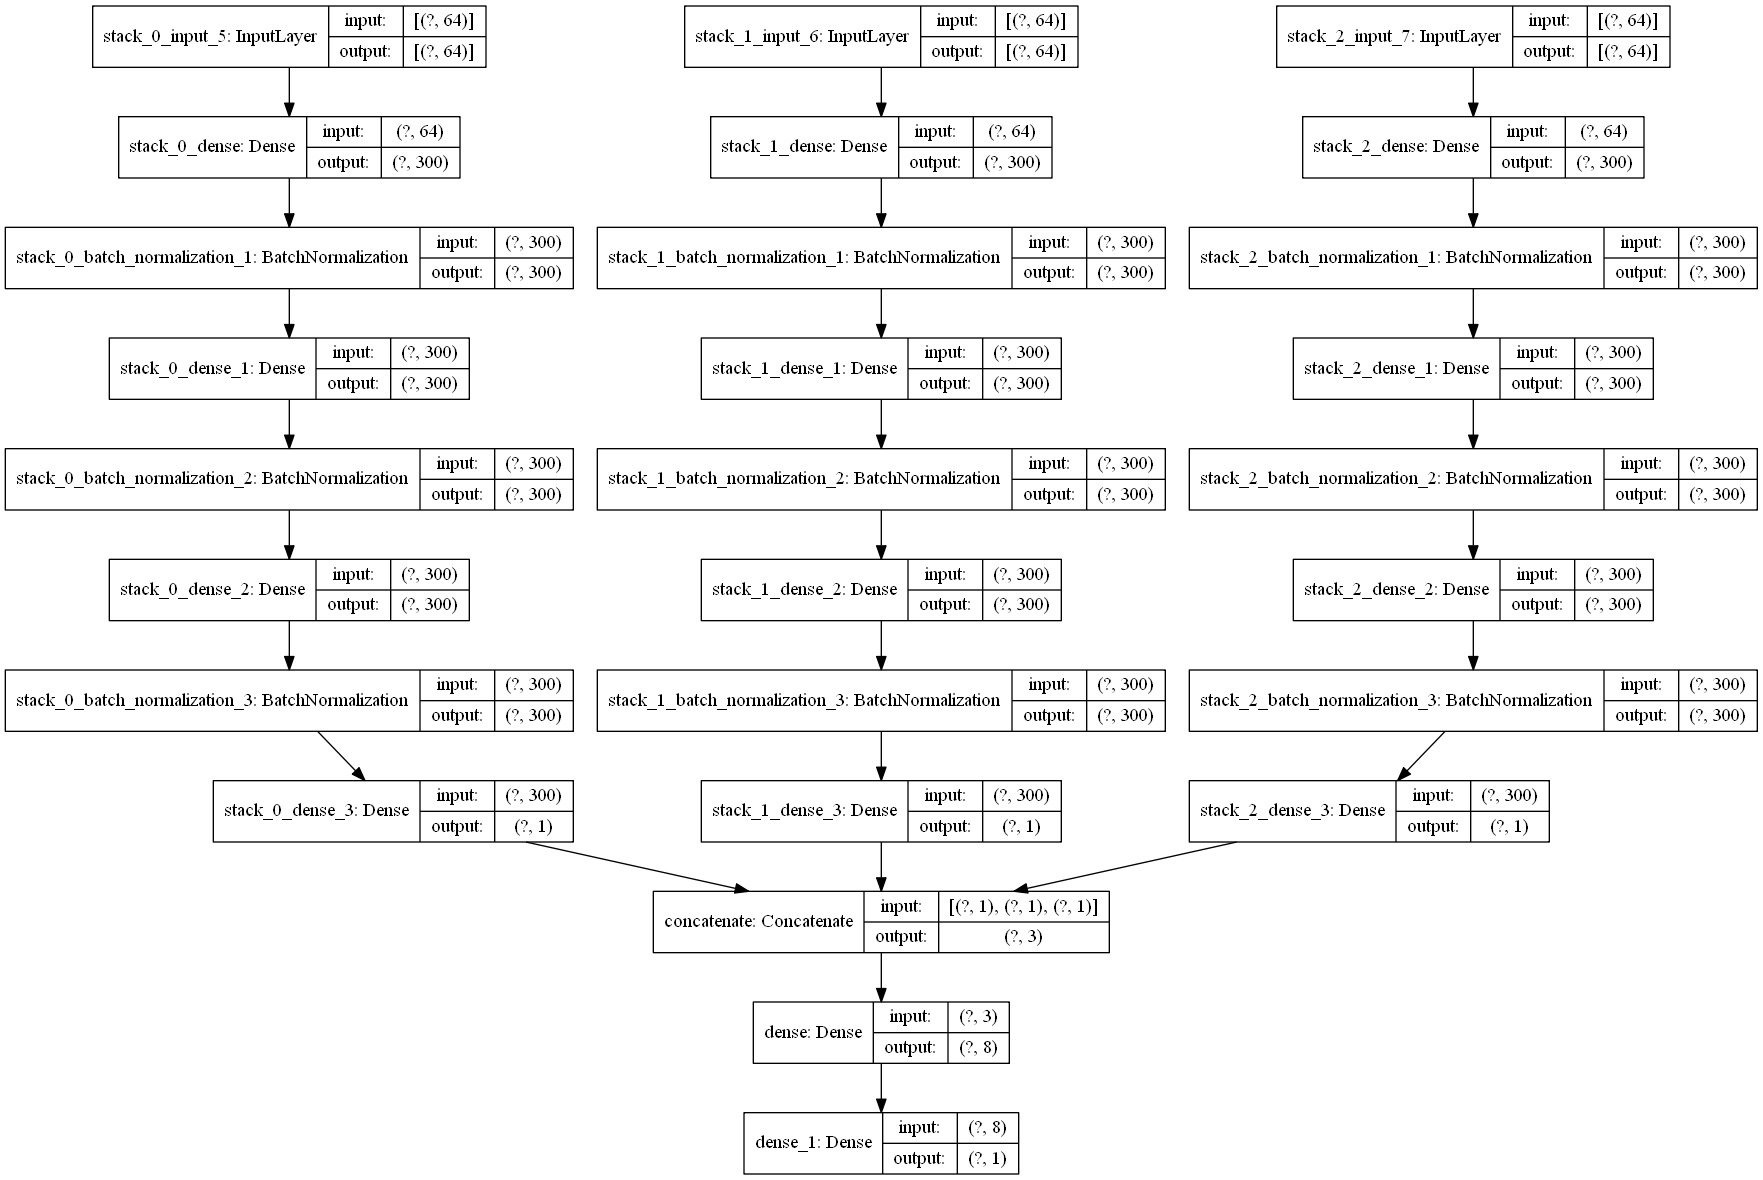

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(DNNLik_ensemble1.stacks['[50, 51, 52]'], show_shapes=True, show_layer_names=True, to_file=DNNLik_ensemble1.ensemble_results_folder+"/stack.png")

In [12]:
start = timer()
DNNLik_ensemble1.train_members_in_parallel_joblib(members_list=list(range(9)),gpus_list="all",verbose=False)
end = timer()
print(end-start)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 300)               19500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200  

../DNNLikelihood_dev\source\DNNLik.py:353: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_out = h5py.File(self.idx_filename)
The maximum opset needed by this model is only 9.


KeyError: 'metrics_15/msle/SquaredDifference'

In [12]:
DNNLik_ensemble1.data_sample.data_dictionary

{'X_train': array([[0.99865657, 1.01583869, 0.97823321, ..., 1.0025027 , 0.99705654,
         0.99738621],
        [0.99942567, 1.01542818, 0.98090083, ..., 1.00238153, 0.99674114,
         0.99803833],
        [0.99887514, 1.01561269, 0.97895845, ..., 1.00247768, 0.99698548,
         0.99754324],
        ...,
        [1.0188599 , 1.1793503 , 0.96986637, ..., 0.97140263, 0.98056649,
         1.03485195],
        [0.98619034, 1.06109114, 1.04553094, ..., 0.99224468, 0.98010572,
         0.93920227],
        [0.97388088, 1.02177948, 0.99341983, ..., 1.00407751, 0.99169389,
         1.00515832]]),
 'Y_train': array([-53.68688649, -51.56647213, -53.06784394, ..., -58.97112627,
        -56.29033357, -57.0026673 ]),
 'X_val': array([[0.99865446, 1.01566392, 0.97820658, ..., 1.00250603, 0.99706026,
         0.9973587 ],
        [0.97815214, 1.01581479, 0.99013442, ..., 1.00249148, 0.99702632,
         0.99746221],
        [0.99937066, 1.00931918, 0.99755608, ..., 1.00342158, 0.99677055,
     

### tf.Transform

In [ ]:
ensemble_folder = 'C:/Users/Admin/Dropbox/Work/09_Resources/Git/GitHub/DNNLikelihood/ATLAS/DNNLikEnsemble_lik_A_0_2020-03-26-16-38-40'
DNNLik_ensemble1 = source.DNNLik_ensemble(DNNLik_ensemble_input_folder=ensemble_folder)
DNNLik_ensemble1.members[0].generate_train_data()

In [7]:
self = DNNLik_ensemble1.members[0]

In [5]:
import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_transform.beam as tft_beam

In [6]:
def preprocessing_fn(XY_list):
    #XYlist = [X,Y]
    X_scaled, Y_scaled = [tft.scale_to_0_1(XY) for XY in XY_list]
    return [X_scaled,X_scaled]

In [9]:
tft.scale_to_0_1(self.Y_train[0:100])

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [8]:
preprocessing_fn([self.X_train[0:100],self.Y_train[0:100]])

RuntimeError: tf.placeholder() is not compatible with eager execution.

## Sampling the likelihood(s)

In [ ]:
in_file = "ATLAS_likelihood_data.pickle"
pickle_in = open(in_file,'rb')
start = timer()
statinfo = os.stat(in_file)
likelihoods = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
likelihoodsA, likelihoodsB, likelihoodsC = [np.array(likelihoods)[[i["signal_region"]==X for i in likelihoods]].tolist() for X in ["A","B","C"]]

In [ ]:
lik_n = 0
model = likelihoods[lik_n]["model"]
obs_data = likelihoods[lik_n]["obs_data"]
mus = np.linspace(0,5,1000)
p = np.asarray([model.config.suggested_init()]*1000)
p[:,model.config.poi_index] = mus
start = timer()
res = np.array(list(map(lambda p: model.logpdf(p, obs_data),p)))
end = timer()
print(end-start)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(mus,res)
plt.show()

In [ ]:
len(likelihoods[0]["pars"])

In [ ]:
likelihood_points = [[l[key] for key in ["signal_region","msb","mn2","mn1"]] for l in likelihoods]
likelihoodA_points = [[l[key] for key in ["signal_region","msb","mn2","mn1"]] for l in likelihoodsA]
likelihoodB_points = [[l[key] for key in ["signal_region","msb","mn2","mn1"]] for l in likelihoodsB]
likelihoodC_points = [[l[key] for key in ["signal_region","msb","mn2","mn1"]] for l in likelihoodsC]
len(likelihood_points)

In [ ]:
pars_distrib = [stats.uniform(loc=-1,scale=2)]+[stats.norm(loc=0,scale=1) for i in range(94)]
pars_distrib[0]()

In [ ]:
MCMC1 = source.MCMC(logprob_fn=logprob,
                    logprob_fn_args = None,
                    biased = False,
                    n_pars_phys=1,
                    n_pars_nuis=94,
                    labels = None,
                    pars_distrib = [stats.uniform(loc=-1,scale=2)]+[stats.norm(loc=0,scale=1) for i in range(94)],
                    nwalkers=200,
                    nsteps=100,
                    basefilename="../../bigfiles/toy_likelihood_prova",
                    chains_name="toy_likelihood",
                    new_sampler=False,
                    moves = None,#[(emcee.moves.StretchMove(), 0), (emcee.moves.GaussianMove(0.0005, mode='random', factor=None),1)],
                    parallel_CPU=True,
                    model=None,
                    scalerX=None,
                    scalerY=None,
                    vectorize=False)

In [ ]:
model = likelihoodsA[0]["model"]
obs_data = likelihoods[0]["obs_data"]
p = model.config.suggested_init()
print(len(p),len(obs_data))

In [ ]:
def diff(first, second):
    second = set(second)
    return 

In [ ]:
[item for item in model.config.par_order if item not in model.config.auxdata_order]

In [20]:
print("Par map length:",len(model.config.par_map.keys()),"\nPar order length:",len(model.config.par_order),"\nParameters length:",len(model.config.parameters),"\nNpars:",model.config.npars,"\nsuggested init length:",len(model.config.suggested_init()),
      "\nAuxdata order length:",len(model.config.auxdata_order),"\nAuxdata length:",len(model.config.auxdata),"\nNauxdata:",model.config.nauxdata,"\nModifiers length:",len(model.config.modifiers))

Par map length: 60 
Par order length: 60 
Parameters length: 60 
Npars: 64 
suggested init length: 64 
Auxdata order length: 58 
Auxdata length: 62 
Nauxdata: 0 
Modifiers length: 96


In [ ]:
len(model.config.modifiers)

In [ ]:
pars = pyhf.tensorlib.astensor(model.config.suggested_init())
likelihoods_tmp[i]["pars"] = pars
par_mapping = {k: v['slice'].start for k,v in model.config.par_map.items()}
likelihoods_tmp[i]["par_mapping"] = par_mapping
par_settings = {n[0]: tuple(m) for n,m in zip(sorted(reversed(list(par_mapping.items())), key=lambda x:x[1]), model.config.suggested_bounds())}
likelihoods_tmp[i]["par_settings"] = par_settings
obs_data = pyhf.tensorlib.astensor(ws.data(model))

In [ ]:
model.config.par_slice()

In [ ]:
likelihoodsA[0]["par_mapping"]

In [ ]:
np.sort(list(likelihoodsA[0]["par_mapping"].values()))

In [ ]:





model

In [79]:
len(model.make_pdf(p[0]).sample((10,))[0])

68

In [51]:
p = np.asarray([model.config.suggested_init()]*1000)

-inf

In [ ]:
def full_likelihood(p,liks):
    msb, mn2, mn1 = p[0:2]
    if msb < np.min([eval(i["msb"]) for i in liks]) and msb > np.max([eval(i["msb"]) for i in liks]):
        return -np.inf
    if mn2 < np.min([eval(i["mn2"]) for i in liks]) and mn2 > np.max([eval(i["mn2"]) for i in liks]):
        return -np.inf
    if mn1 < np.min([eval(i["mn1"]) for i in liks]) and mn1 > np.max([eval(i["mn1"]) for i in liks]):
        return -np.inf
    
    mui = p[0:len(likelihoods)]
    theta = p[len(likelihoods):]
    model = likelihoods[lik_n]["model"]
    obs_data = likelihoods[lik_n]["obs_data"]

## Backup

In [116]:
x = np.array([1,2,3,4])
#x = [1,2,3,4]
#x = "miononno"
print(id(x))
class myclass(object):
    def __init__(self,x=None):
        self.x = x
        print(id(x))
        print(id(self.x))
        #np.random.shuffle(x)
        x = np.array([4,3,2,1])
        print(id(x),str(x))
        print(id(self.x),str(self.x))
pippo = myclass(x)

1783630415632
1783630415632
1783630415632
1783624946592 [4 3 2 1]
1783630415632 [1 2 3 4]


In [112]:
x = "miononno"
print(id(x))
class myclass(object):
    def __init__(self,x=None):
        self.x = x
        print(id(x))
        print(id(self.x))
        x.replace("nonno","nonna")
        print(id(x),str(x))
        print(id(self.x),str(self.x))
pippo = myclass(x)

1783375684272
1783375684272
1783375684272
1783375684272 miononno
1783375684272 miononno


In [57]:
#for f in patch_files:
#    with open(f) as json_file: 
#        print(json_file)
#        patch = JsonPatch(json.load(json_file))
#    res = jsonpatch.apply_patch(bgonly, patch)
#    with open(f.replace("patch.",""), "w") as json_file:
#        json.dump(res,json_file)

### Giordon method

In [25]:
for i in len(likelihoods):
    file = patch_files[i].replace("patch.","")
    #print(file)
    spec = json.load(open(file))
    ws = pyhf.Workspace(spec)
    model = ws.model()
    likelihoods[i]["model"] = model
    pars = pyhf.tensorlib.astensor(model.config.suggested_init())
    likelihoods[i]["pars"] = pars
    par_mapping = {k: v['slice'].start for k,v in model.config.par_map.items()}
    likelihoods[i]["par_mapping"] = par_mapping
    par_settings = {n[0]: tuple(m) for n,m in zip(sorted(reversed(list(par_mapping.items())), key=lambda x:x[1]), model.config.suggested_bounds())}
    likelihoods[i]["par_settings"] = par_settings
    obs_data = pyhf.tensorlib.astensor(ws.data(model))
    likelihoods[i]["obs_data"] = obs_data
    ## if no exception is raised, it found and parsed the schema
    schema = requests.get('https://scikit-hep.org/pyhf/schemas/1.0.0/workspace.json').json()
    ## If no exception is raised by validate(), the instance is valid.
    jsonschema.validate(instance=spec, schema=schema)

HEPData_workspaces/RegionA/sbottom_1000_131_1.json


In [9]:
model.config.poi_index

5

In [26]:
mus = np.linspace(0,5,1000)
p = np.asarray([model.config.suggested_init()]*1000)
p[:,model.config.poi_index] = mus

In [20]:
#model.make_pdf(p[0]).sample((10,))
#model.expected_data(p[0])

In [27]:
start = timer()
res = np.array(list(map(lambda p: model.logpdf(p, obs_data),p)))
end = timer()
print(end-start)

0.22402679999993325


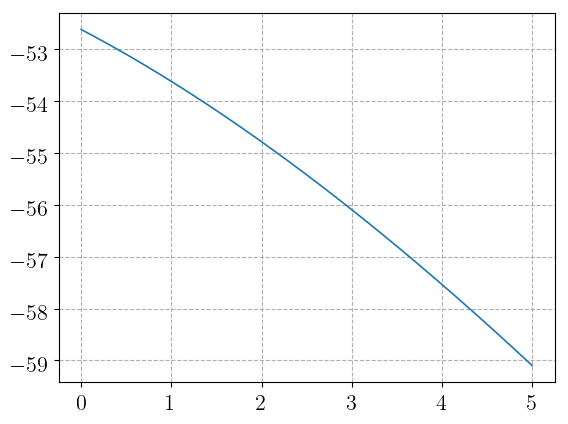

In [24]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(mus,res)
plt.show()

### Lukas method

In [30]:
file = bgonly_file
print(file)
spec = json.load(open(file))
patch = json.load(open(patch_files[0]))
#patches = [json.load(open(file)) for file in patch_files]
# if no exception is raised, it found and parsed the schema
schema = requests.get('https://diana-hep.org/pyhf/schemas/1.0.0/workspace.json').json()
# If no exception is raised by validate(), the instance is valid.
jsonschema.validate(instance=spec, schema=schema)

HEPData_workspaces/RegionA/BkgOnly.json


In [32]:
ws = pyhf.Workspace(spec)

In [33]:
model = ws.model(patches = [patch], batch_size = 1000)
pars = pyhf.tensorlib.astensor(model.config.suggested_init())
par_mapping = {k: v['slice'].start for k,v in model.config.par_map.items()}
par_settings = {n[0]: tuple(m) for n,m in zip(sorted(reversed(list(par_mapping.items())), key=lambda x:x[1]), model.config.suggested_bounds())}
obs_data = ws.data(model)

In [34]:
model.batch_size

1000

In [10]:
pars

array([1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [11]:
par_mapping

{'lumi': 0,
 'staterror_SR_meff': 1,
 'SigRad': 4,
 'mu_SIG': 5,
 'EL_EFF_ChargeIDSel_TOTAL_1NPCOR_PLUS_UNCOR': 6,
 'EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR': 7,
 'EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR': 8,
 'EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR': 9,
 'EL_EFF_TriggerEff_TOTAL_1NPCOR_PLUS_UNCOR': 10,
 'EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR': 11,
 'FT_EFF_B_systematics': 12,
 'FT_EFF_C_systematics': 13,
 'FT_EFF_Light_systematics': 14,
 'FT_EFF_extrapolation': 15,
 'FT_EFF_extrapolation_from_charm': 16,
 'JET_JvtEfficiency': 17,
 'MUON_EFF_BADMUON_STAT': 18,
 'MUON_EFF_BADMUON_SYS': 19,
 'MUON_EFF_ISO_STAT': 20,
 'MUON_EFF_ISO_SYS': 21,
 'MUON_EFF_RECO_STAT': 22,
 'MUON_EFF_RECO_SYS': 23,
 'MUON_EFF_TTVA_STAT': 24,
 'MUON_EFF_TTVA_SYS': 25,
 'MUON_EFF_TrigStatUncertainty': 26,
 'MUON_EFF_TrigSystUncertainty': 27,
 'EG_RESOLUTION_ALL': 28,
 'EG_SCALE_ALL': 29,
 'JET_EtaIntercalibration_NonClosure_highE': 30,
 'JET_EtaIntercalibration_NonClosure_negEta': 31,
 'JET_EtaIntercalibration_NonClosure_pos

In [12]:
par_settings

{'lumi': (0.915, 1.085),
 'staterror_SR_meff': (1e-10, 10.0),
 'SigRad': (1e-10, 10.0),
 'mu_SIG': (1e-10, 10.0),
 'EL_EFF_ChargeIDSel_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR': (0, 10),
 'EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_TriggerEff_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'FT_EFF_B_systematics': (-5.0, 5.0),
 'FT_EFF_C_systematics': (-5.0, 5.0),
 'FT_EFF_Light_systematics': (-5.0, 5.0),
 'FT_EFF_extrapolation': (-5.0, 5.0),
 'FT_EFF_extrapolation_from_charm': (-5.0, 5.0),
 'JET_JvtEfficiency': (-5.0, 5.0),
 'MUON_EFF_BADMUON_STAT': (-5.0, 5.0),
 'MUON_EFF_BADMUON_SYS': (-5.0, 5.0),
 'MUON_EFF_ISO_STAT': (-5.0, 5.0),
 'MUON_EFF_ISO_SYS': (-5.0, 5.0),
 'MUON_EFF_RECO_STAT': (-5.0, 5.0),
 'MUON_EFF_RECO_SYS': (-5.0, 5.0),
 'MUON_EFF_TTVA_STAT': (-5.0, 5.0),
 'MUON_EFF_TTVA_SYS': (-5.0, 5.0),
 'MUON_EFF_TrigStatUncertainty'

In [13]:
obs_data

[153.0,
 52.0,
 19.0,
 12.0,
 3.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [35]:
mus = np.linspace(0,5,model.batch_size)
mus

array([0.        , 0.00500501, 0.01001001, 0.01501502, 0.02002002,
       0.02502503, 0.03003003, 0.03503504, 0.04004004, 0.04504505,
       0.05005005, 0.05505506, 0.06006006, 0.06506507, 0.07007007,
       0.07507508, 0.08008008, 0.08508509, 0.09009009, 0.0950951 ,
       0.1001001 , 0.10510511, 0.11011011, 0.11511512, 0.12012012,
       0.12512513, 0.13013013, 0.13513514, 0.14014014, 0.14514515,
       0.15015015, 0.15515516, 0.16016016, 0.16516517, 0.17017017,
       0.17517518, 0.18018018, 0.18518519, 0.19019019, 0.1951952 ,
       0.2002002 , 0.20520521, 0.21021021, 0.21521522, 0.22022022,
       0.22522523, 0.23023023, 0.23523524, 0.24024024, 0.24524525,
       0.25025025, 0.25525526, 0.26026026, 0.26526527, 0.27027027,
       0.27527528, 0.28028028, 0.28528529, 0.29029029, 0.2952953 ,
       0.3003003 , 0.30530531, 0.31031031, 0.31531532, 0.32032032,
       0.32532533, 0.33033033, 0.33533534, 0.34034034, 0.34534535,
       0.35035035, 0.35535536, 0.36036036, 0.36536537, 0.37037

In [36]:
p = np.asarray([model.config.suggested_init()]*model.batch_size)
p[:,model.config.poi_index] = mus

In [37]:
start = timer()
res = model.logpdf(p,obs_data)
end = timer()
print(end-start)

0.30653480000000854


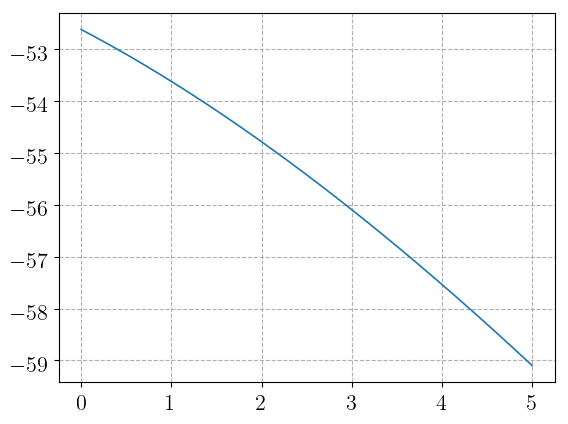

In [24]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(mus,res)
plt.show()

### TensorFlow backend

In [6]:
pyhf.get_backend()

(<pyhf.tensor.numpy_backend.numpy_backend at 0x25f8c19ea48>,
 <pyhf.optimize.opt_scipy.scipy_optimizer at 0x25f8c322488>)

In [7]:
pyhf.set_backend(pyhf.tensor.tensorflow_backend())

In [8]:
pyhf.get_backend()

(<pyhf.tensor.tensorflow_backend.tensorflow_backend at 0x25f96613b48>,
 <pyhf.optimize.opt_tflow.tflow_optimizer at 0x25f96613988>)

In [9]:
file = bgonly_file
print(file)
spec = json.load(open(file))
patch = json.load(open(patch_files[0]))
#patches = [json.load(open(file)) for file in patch_files]
# if no exception is raised, it found and parsed the schema
schema = requests.get('https://diana-hep.org/pyhf/schemas/1.0.0/workspace.json').json()
# If no exception is raised by validate(), the instance is valid.
jsonschema.validate(instance=spec, schema=schema)

HEPData_workspaces/RegionA/BkgOnly.json


In [10]:
ws = pyhf.Workspace(spec)

In [16]:
model = ws.model(patches = [patch], batch_size = 10000)
pars = pyhf.tensorlib.astensor(model.config.suggested_init())
par_mapping = {k: v['slice'].start for k,v in model.config.par_map.items()}
par_settings = {n[0]: tuple(m) for n,m in zip(sorted(reversed(list(par_mapping.items())), key=lambda x:x[1]), model.config.suggested_bounds())}
obs_data = ws.data(model)

In [51]:
model.batch_size

1000

In [52]:
pars

<tf.Tensor 'Const_112:0' shape=(64,) dtype=float32>

In [53]:
par_mapping

{'lumi': 0,
 'staterror_SR_meff': 1,
 'SigRad': 4,
 'mu_SIG': 5,
 'EL_EFF_ChargeIDSel_TOTAL_1NPCOR_PLUS_UNCOR': 6,
 'EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR': 7,
 'EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR': 8,
 'EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR': 9,
 'EL_EFF_TriggerEff_TOTAL_1NPCOR_PLUS_UNCOR': 10,
 'EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR': 11,
 'FT_EFF_B_systematics': 12,
 'FT_EFF_C_systematics': 13,
 'FT_EFF_Light_systematics': 14,
 'FT_EFF_extrapolation': 15,
 'FT_EFF_extrapolation_from_charm': 16,
 'JET_JvtEfficiency': 17,
 'MUON_EFF_BADMUON_STAT': 18,
 'MUON_EFF_BADMUON_SYS': 19,
 'MUON_EFF_ISO_STAT': 20,
 'MUON_EFF_ISO_SYS': 21,
 'MUON_EFF_RECO_STAT': 22,
 'MUON_EFF_RECO_SYS': 23,
 'MUON_EFF_TTVA_STAT': 24,
 'MUON_EFF_TTVA_SYS': 25,
 'MUON_EFF_TrigStatUncertainty': 26,
 'MUON_EFF_TrigSystUncertainty': 27,
 'EG_RESOLUTION_ALL': 28,
 'EG_SCALE_ALL': 29,
 'JET_EtaIntercalibration_NonClosure_highE': 30,
 'JET_EtaIntercalibration_NonClosure_negEta': 31,
 'JET_EtaIntercalibration_NonClosure_pos

In [54]:
par_settings

{'lumi': (0.915, 1.085),
 'staterror_SR_meff': (1e-10, 10.0),
 'SigRad': (1e-10, 10.0),
 'mu_SIG': (1e-10, 10.0),
 'EL_EFF_ChargeIDSel_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR': (0, 10),
 'EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_TriggerEff_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR': (-5.0, 5.0),
 'FT_EFF_B_systematics': (-5.0, 5.0),
 'FT_EFF_C_systematics': (-5.0, 5.0),
 'FT_EFF_Light_systematics': (-5.0, 5.0),
 'FT_EFF_extrapolation': (-5.0, 5.0),
 'FT_EFF_extrapolation_from_charm': (-5.0, 5.0),
 'JET_JvtEfficiency': (-5.0, 5.0),
 'MUON_EFF_BADMUON_STAT': (-5.0, 5.0),
 'MUON_EFF_BADMUON_SYS': (-5.0, 5.0),
 'MUON_EFF_ISO_STAT': (-5.0, 5.0),
 'MUON_EFF_ISO_SYS': (-5.0, 5.0),
 'MUON_EFF_RECO_STAT': (-5.0, 5.0),
 'MUON_EFF_RECO_SYS': (-5.0, 5.0),
 'MUON_EFF_TTVA_STAT': (-5.0, 5.0),
 'MUON_EFF_TTVA_SYS': (-5.0, 5.0),
 'MUON_EFF_TrigStatUncertainty'

In [55]:
obs_data

[153.0,
 52.0,
 19.0,
 12.0,
 3.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [17]:
mus = np.linspace(0,5,model.batch_size)
mus

array([0.00000000e+00, 5.00050005e-04, 1.00010001e-03, ...,
       4.99899990e+00, 4.99949995e+00, 5.00000000e+00])

In [18]:
p = np.asarray([model.config.suggested_init()]*model.batch_size)
p[:,model.config.poi_index] = mus

In [19]:
ptf = tf.placeholder(tf.float32, np.shape(p))
obs_datatf = tf.placeholder(tf.float32,np.shape(obs_data))
logprob_tf = model.logpdf(ptf,obs_datatf)

In [20]:
with tf.Session() as sess:
    start = timer()
    res = sess.run(logprob_tf, feed_dict = {ptf: p,obs_datatf: obs_data})
    end = timer()
print(end-start)

3.0138013000000115


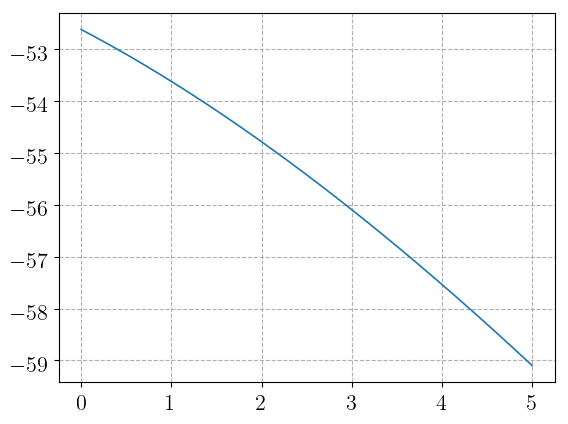

In [38]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(mus,res)
plt.show()

## Tutotials

### Histfactory

### Likelihood

In [2]:
import numpy as np

In [3]:
nbI_nominal = np.array(list(reversed([i for i in range(100,1100,100)])))
nbI_obs = np.random.poisson(nbI_nominal)
nsI_reference = np.array(list(reversed([i for i in range(10,110,10)])))
[len(nbI_nominal),len(nbI_obs),len(nsI_reference)]

[10, 10, 10]

In [4]:
def nbI(delta):
    delta = np.array(delta)
    return np.array([nbI_nominal[i]*(1+0.1)**delta[i] for i in range(len(delta))])
def nsI(mu):
    return mu*nsI_reference
def nI(pars):
    mu = pars[0]
    delta = pars[1:]
    return np.array(nsI(mu)+nbI(delta))
def loglik(pars, obs):
    exp = nI(pars)
    logfact = np.array(list(map(lambda x: np.math.lgamma(x+1), obs)))
    return np.sum(-1*logfact+obs*np.log(exp)-exp)
def logprior(pars):
    mu = pars[0]
    delta = pars[1:]
    delta_prior = -1/2*np.sum(delta**2+np.full(len(delta),np.log(2*np.pi)))
    return delta_prior-np.log(1/(10))
def logpdf(pars, obs):
    return loglik(pars, obs)+logprior(pars)

In [5]:
nbI(np.random.normal(0,1,10))

array([863.01718036, 808.78154519, 856.99159491, 683.88937606,
       600.97478483, 460.78768419, 436.44210714, 319.89440282,
       175.93929767,  99.98119285])

In [6]:
nsI(1.1)

array([110.,  99.,  88.,  77.,  66.,  55.,  44.,  33.,  22.,  11.])

In [7]:
nI(np.insert(np.random.normal(0,1,10),0,1.1))

array([1010.95268077, 1161.54589655,  824.26910005,  909.3676562 ,
        569.7921682 ,  570.62147616,  442.94958387,  291.34519143,
        210.03564897,  139.63975909])

In [8]:
logpdf(np.insert(np.random.normal(0,1,10),0,1.1), nbI_obs)

-109.92217073830038

In [9]:
pars_pos_poi = [0]
pars_pos_nuis = range(1,11)
pars_init = np.insert(np.full(10,0),0,1)
pars_bounds = np.concatenate((np.array([[-5,5]]),
                              np.vstack([np.full(10,-np.inf),
                                         np.full(10,np.inf)]).T))

In [10]:
np.concatenate((np.array([[-5,5]]),np.vstack([np.full(10,-np.inf),np.full(10,np.inf)]).T))

array([[ -5.,   5.],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf],
       [-inf,  inf]])

In [11]:
likelihood = DNNLikelihood.Likelihood(name = 'toy',
                                      logpdf = logpdf,
                                      logpdf_args = [nbI_obs],
                                      pars_pos_poi = pars_pos_poi,
                                      pars_pos_nuis = pars_pos_nuis,
                                      pars_init = pars_init,
                                      pars_labels = None,
                                      pars_bounds = pars_bounds,
                                      output_folder = "outfiles")

Likelihood pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.pickle saved in 0.009329000000001031 s.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.json saved in 0.0016309000000021001 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.log saved in 0.0009211000000028946 s.


In [2]:
likelihood = DNNLikelihood.Likelihood(likelihood_input_file="outfiles/toy_likelihood")

Likelihood loaded in 0.006855100000001002 .
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.log saved in 0.0012769999999999726 s.


In [3]:
likelihood.logpdf_fn(likelihood.pars_init,*likelihood.logpdf_args)

-72.4015602242102

Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood_figure_par_0.pdf.


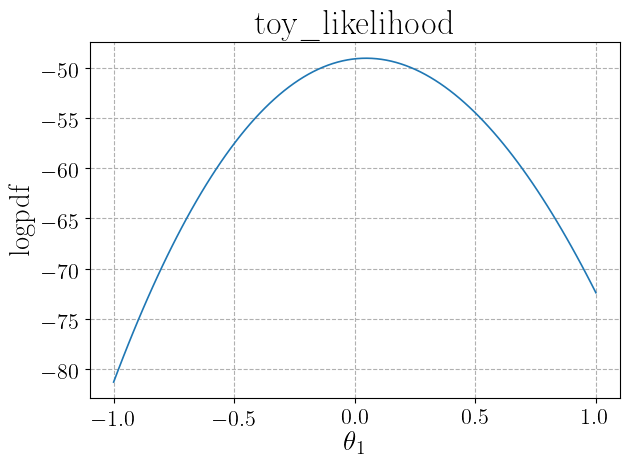

Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.log saved in 0.0013214000000019155 s.
Saved figure C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood_figure_par_5.pdf.


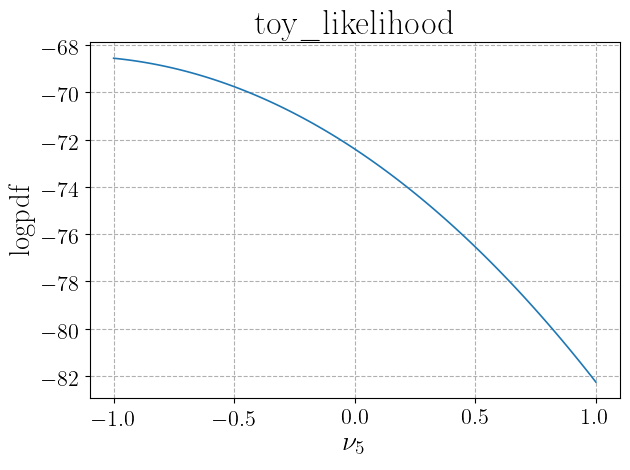

Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.log saved in 0.001331300000003921 s.


In [4]:
likelihood.plot_logpdf_par([[0,-1,1],[5,-1,1]],overwrite=True)

In [6]:
likelihood.compute_maximum_logpdf()
print(likelihood.X_logpdf_max)
print(likelihood.Y_logpdf_max)

Maximum likelihood already stored in self.X_logpdf_max and self.Y_logpdf_max
[ 0.04380427  0.27652363  0.02134356 -0.15662528 -0.0267759  -0.30837557
  0.35269854 -0.36984361 -0.08494277 -0.13147428  0.52011438]
47.26988825197074


In [ ]:
likelihood.compute_maximum_logpdf()
print(likelihood.X_logpdf_max)
print(likelihood.Y_logpdf_max)

In [9]:
likelihood.compute_profiled_maxima(pars=[0],pars_ranges=[[-1,1,10]],spacing="grid",verbose=2)
print(likelihood.X_prof_logpdf_max)
print(likelihood.Y_prof_logpdf_max)

FloatProgress(value=0.0, layout=Layout(height='14px', margin='-5px 0px -20px 0px', padding='0px', width='500px…

Total number of points: 10 .
Log-pdf values lie in the range [ 47.28808819443674 , 51.71637546558055 ]
10 local maxima computed in 0.2853599000000031 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.log saved in 0.0017032999999173626 s.
[[-1.          1.21169326  0.96592494  0.7891095   0.89669271  0.61408032
   1.21501547  0.49455945  0.71604701  0.58415075  1.07251509]
 [-0.77777778  1.01767165  0.76971591  0.59234143  0.7041785   0.42121161
   1.03431711  0.31223278  0.54606212  0.430467    0.95205154]
 [-0.55555556  0.82092492  0.57087099  0.39308886  0.50943558  0.22639195
   0.85200361  0.1288899   0.37567555  0.27738803  0.83305655]
 [-0.33333333  0.6214332   0.36937699  0.19135896  0.31247408  0.02966904
   0.66813772 -0.05536624  0.20500566  0.12504623  0.7156285 ]
 [-0.11111111  0.41917142  0.16522872 -0.01283381  0.11332678 -0.16889744
   0.48277159 -0.24042337  0.03417443 -0.02644314  0.59982344]
 [ 0.111

In [10]:
likelihood.save_likelihood(overwrite=True)

Likelihood pickle file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.pickle saved in 0.01040740000007645 s.
Likelihood json file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.json saved in 0.0017879999995784601 s.
Likelihood log file C:\Users\Admin\Dropbox\Work\09_Resources\Git\GitHub\DNNLikelihood\ATLAS\outfiles\toy_likelihood.log saved in 0.0015715999998064945 s.
